In [1]:
import re
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/mnt/efs/home/iet5740/Projects/UKBPPP/torch_venv/lib64/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%time
training_embedding = torch.load('embedding_tensors.training.pt')
testing_embedding = torch.load('embedding_tensors.testing.pt')
wt_embedding = torch.load('embedding_tensors.wildtype.pt')

CPU times: user 601 ms, sys: 89.7 ms, total: 691 ms
Wall time: 768 ms


In [3]:
df1 = pd.read_csv('Orphanet_LoF_GoF_clinvarVariants.csv',index_col=0)
df2 = pd.read_csv('Benign_clinvarVariants.csv',index_col=0)
df2['direction'] = ['Benign'] * df2.shape[0]
training = pd.concat([df1,df2],join='inner',axis=0)
training.shape

(38559, 6)

In [4]:
df1 = pd.read_csv('OMIM_LoF_GoF_clinvarVariants.csv',index_col=0)
df2 = pd.read_csv('Benign_clinvarVariants_OMIM.csv',index_col=0)
df2['direction'] = ['Benign'] * df2.shape[0]
testing = pd.concat([df1,df2],join='inner',axis=0)
testing.shape

(24176, 5)

In [5]:
training.index.dtype

dtype('int64')

In [6]:
label_mapping = {'Benign': 0, 'LoF':1, 'GoF':2}

In [7]:
class variantDataset(Dataset):
    def __init__(self,tensor_dict,wt_tensor_dict,label_df):
        tensor_array = []
        labels = []
        for key,embedding in tensor_dict.items():
            vid,txID,sub = key.split(':')
            direction = label_df.loc[int(vid),'direction']
            if direction != 'conflicted':
                wt_embedding = wt_tensor_dict[txID+'_WT']
                tensor_array.append(torch.cat((embedding,wt_embedding),dim=-1))
                labels.append(label_mapping[direction])
            
        self.embeddings = tensor_array
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        return embedding,label

In [8]:
training_data = variantDataset(training_embedding,wt_embedding,training)
print(len(training_data))

10990


In [9]:
training_data[15]

(tensor([ 0.1094,  0.0968,  0.1457,  ...,  0.0722, -0.0161,  0.0375]), 1)

In [10]:
testing_data = variantDataset(testing_embedding,wt_embedding,testing)
print(len(testing_data))

7362


In [11]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
INPUT_DIM = 2560
Z_DIM = 3
H1_DIM = 128
H2_DIM = 16
NUM_EPOCHS = 300
BATCH_SIZE = 64
LR_RATE = 1e-4

cpu


In [12]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE)

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, z_dim, h1_dim, h2_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, h1_dim),
            nn.ReLU(),
            nn.Linear(h1_dim, h2_dim),
            nn.ReLU(),
            nn.Linear(h2_dim, z_dim)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

#model = NeuralNetwork(INPUT_DIM, Z_DIM, H1_DIM, H2_DIM).to(device)
#print(model)

## Training and testing

In [33]:
# Define train function
def train(num_epochs, dataloader, model, optimizer, loss_fn):
    trainingEpoch_loss = []
    n_total_steps = len(dataloader)
    # Start training
    for epoch in range(num_epochs):
        step_loss = []
        for i, (X,y) in enumerate(dataloader):
            # Forward pass
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred,y)

            # Backprop and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            #record loss
            step_loss.append(loss.item())
            if (i+1) % 1 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
                
        trainingEpoch_loss.append(np.array(step_loss).mean())
        
    return trainingEpoch_loss

In [34]:
# Initialize model, optimizer, loss
model = NeuralNetwork(INPUT_DIM, Z_DIM, H1_DIM, H2_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

In [35]:
# Run training
training_loss = train(NUM_EPOCHS, train_dataloader, model, optimizer, loss_fn)

Epoch [1/300], Step [1/172], Loss: 68.9848
Epoch [1/300], Step [2/172], Loss: 67.8992
Epoch [1/300], Step [3/172], Loss: 68.4125
Epoch [1/300], Step [4/172], Loss: 66.7385
Epoch [1/300], Step [5/172], Loss: 67.0300
Epoch [1/300], Step [6/172], Loss: 64.7885
Epoch [1/300], Step [7/172], Loss: 62.4279
Epoch [1/300], Step [8/172], Loss: 62.6803
Epoch [1/300], Step [9/172], Loss: 61.5183
Epoch [1/300], Step [10/172], Loss: 61.9408
Epoch [1/300], Step [11/172], Loss: 61.5468
Epoch [1/300], Step [12/172], Loss: 59.2755
Epoch [1/300], Step [13/172], Loss: 58.4219
Epoch [1/300], Step [14/172], Loss: 57.8058
Epoch [1/300], Step [15/172], Loss: 56.2284
Epoch [1/300], Step [16/172], Loss: 54.2144
Epoch [1/300], Step [17/172], Loss: 52.6863
Epoch [1/300], Step [18/172], Loss: 53.5813
Epoch [1/300], Step [19/172], Loss: 51.0874
Epoch [1/300], Step [20/172], Loss: 72.0540
Epoch [1/300], Step [21/172], Loss: 49.2530
Epoch [1/300], Step [22/172], Loss: 51.6451
Epoch [1/300], Step [23/172], Loss: 44.70

Epoch [2/300], Step [48/172], Loss: 93.8703
Epoch [2/300], Step [49/172], Loss: 51.9793
Epoch [2/300], Step [50/172], Loss: 61.7483
Epoch [2/300], Step [51/172], Loss: 45.8520
Epoch [2/300], Step [52/172], Loss: 45.8161
Epoch [2/300], Step [53/172], Loss: 49.3775
Epoch [2/300], Step [54/172], Loss: 44.7260
Epoch [2/300], Step [55/172], Loss: 43.5120
Epoch [2/300], Step [56/172], Loss: 41.8833
Epoch [2/300], Step [57/172], Loss: 63.9382
Epoch [2/300], Step [58/172], Loss: 46.2879
Epoch [2/300], Step [59/172], Loss: 52.8371
Epoch [2/300], Step [60/172], Loss: 78.6928
Epoch [2/300], Step [61/172], Loss: 40.1889
Epoch [2/300], Step [62/172], Loss: 41.2628
Epoch [2/300], Step [63/172], Loss: 34.1597
Epoch [2/300], Step [64/172], Loss: 32.8355
Epoch [2/300], Step [65/172], Loss: 43.5268
Epoch [2/300], Step [66/172], Loss: 33.0164
Epoch [2/300], Step [67/172], Loss: 40.8700
Epoch [2/300], Step [68/172], Loss: 30.5829
Epoch [2/300], Step [69/172], Loss: 67.7271
Epoch [2/300], Step [70/172], Lo

Epoch [3/300], Step [61/172], Loss: 41.2769
Epoch [3/300], Step [62/172], Loss: 44.7489
Epoch [3/300], Step [63/172], Loss: 34.5520
Epoch [3/300], Step [64/172], Loss: 32.7220
Epoch [3/300], Step [65/172], Loss: 46.3984
Epoch [3/300], Step [66/172], Loss: 33.0370
Epoch [3/300], Step [67/172], Loss: 45.8024
Epoch [3/300], Step [68/172], Loss: 37.0944
Epoch [3/300], Step [69/172], Loss: 68.6731
Epoch [3/300], Step [70/172], Loss: 73.3040
Epoch [3/300], Step [71/172], Loss: 73.1814
Epoch [3/300], Step [72/172], Loss: 73.4603
Epoch [3/300], Step [73/172], Loss: 74.6144
Epoch [3/300], Step [74/172], Loss: 73.0796
Epoch [3/300], Step [75/172], Loss: 68.0342
Epoch [3/300], Step [76/172], Loss: 70.9018
Epoch [3/300], Step [77/172], Loss: 71.4391
Epoch [3/300], Step [78/172], Loss: 71.5484
Epoch [3/300], Step [79/172], Loss: 69.8667
Epoch [3/300], Step [80/172], Loss: 69.2100
Epoch [3/300], Step [81/172], Loss: 66.9071
Epoch [3/300], Step [82/172], Loss: 66.2441
Epoch [3/300], Step [83/172], Lo

Epoch [4/300], Step [112/172], Loss: 36.3763
Epoch [4/300], Step [113/172], Loss: 34.7224
Epoch [4/300], Step [114/172], Loss: 34.1091
Epoch [4/300], Step [115/172], Loss: 33.7394
Epoch [4/300], Step [116/172], Loss: 33.1036
Epoch [4/300], Step [117/172], Loss: 32.3923
Epoch [4/300], Step [118/172], Loss: 32.5810
Epoch [4/300], Step [119/172], Loss: 31.2197
Epoch [4/300], Step [120/172], Loss: 31.4347
Epoch [4/300], Step [121/172], Loss: 30.7411
Epoch [4/300], Step [122/172], Loss: 29.0147
Epoch [4/300], Step [123/172], Loss: 28.8497
Epoch [4/300], Step [124/172], Loss: 29.0378
Epoch [4/300], Step [125/172], Loss: 28.9674
Epoch [4/300], Step [126/172], Loss: 28.4758
Epoch [4/300], Step [127/172], Loss: 28.1748
Epoch [4/300], Step [128/172], Loss: 27.6776
Epoch [4/300], Step [129/172], Loss: 26.7875
Epoch [4/300], Step [130/172], Loss: 27.2712
Epoch [4/300], Step [131/172], Loss: 26.2971
Epoch [4/300], Step [132/172], Loss: 25.7795
Epoch [4/300], Step [133/172], Loss: 25.4893
Epoch [4/3

Epoch [5/300], Step [142/172], Loss: 22.9551
Epoch [5/300], Step [143/172], Loss: 21.7900
Epoch [5/300], Step [144/172], Loss: 21.2438
Epoch [5/300], Step [145/172], Loss: 21.0516
Epoch [5/300], Step [146/172], Loss: 20.4204
Epoch [5/300], Step [147/172], Loss: 21.6252
Epoch [5/300], Step [148/172], Loss: 20.6782
Epoch [5/300], Step [149/172], Loss: 20.2783
Epoch [5/300], Step [150/172], Loss: 20.4360
Epoch [5/300], Step [151/172], Loss: 19.2289
Epoch [5/300], Step [152/172], Loss: 18.8516
Epoch [5/300], Step [153/172], Loss: 19.1268
Epoch [5/300], Step [154/172], Loss: 18.5064
Epoch [5/300], Step [155/172], Loss: 18.3599
Epoch [5/300], Step [156/172], Loss: 18.2820
Epoch [5/300], Step [157/172], Loss: 18.0004
Epoch [5/300], Step [158/172], Loss: 17.7592
Epoch [5/300], Step [159/172], Loss: 17.4194
Epoch [5/300], Step [160/172], Loss: 17.5088
Epoch [5/300], Step [161/172], Loss: 16.6422
Epoch [5/300], Step [162/172], Loss: 16.5518
Epoch [5/300], Step [163/172], Loss: 16.2950
Epoch [5/3

Epoch [6/300], Step [169/172], Loss: 15.6850
Epoch [6/300], Step [170/172], Loss: 15.4968
Epoch [6/300], Step [171/172], Loss: 14.1959
Epoch [6/300], Step [172/172], Loss: 10.5035
Epoch [7/300], Step [1/172], Loss: 106.2588
Epoch [7/300], Step [2/172], Loss: 105.6626
Epoch [7/300], Step [3/172], Loss: 156.3377
Epoch [7/300], Step [4/172], Loss: 114.0030
Epoch [7/300], Step [5/172], Loss: 137.6820
Epoch [7/300], Step [6/172], Loss: 82.3841
Epoch [7/300], Step [7/172], Loss: 93.2388
Epoch [7/300], Step [8/172], Loss: 79.7362
Epoch [7/300], Step [9/172], Loss: 89.9688
Epoch [7/300], Step [10/172], Loss: 101.1221
Epoch [7/300], Step [11/172], Loss: 96.7064
Epoch [7/300], Step [12/172], Loss: 90.7963
Epoch [7/300], Step [13/172], Loss: 78.7051
Epoch [7/300], Step [14/172], Loss: 105.7000
Epoch [7/300], Step [15/172], Loss: 100.5444
Epoch [7/300], Step [16/172], Loss: 81.4530
Epoch [7/300], Step [17/172], Loss: 79.1179
Epoch [7/300], Step [18/172], Loss: 90.2931
Epoch [7/300], Step [19/172],

Epoch [8/300], Step [22/172], Loss: 98.5178
Epoch [8/300], Step [23/172], Loss: 80.7213
Epoch [8/300], Step [24/172], Loss: 90.4241
Epoch [8/300], Step [25/172], Loss: 72.2148
Epoch [8/300], Step [26/172], Loss: 76.3773
Epoch [8/300], Step [27/172], Loss: 92.1521
Epoch [8/300], Step [28/172], Loss: 76.5386
Epoch [8/300], Step [29/172], Loss: 94.4872
Epoch [8/300], Step [30/172], Loss: 84.3459
Epoch [8/300], Step [31/172], Loss: 68.8409
Epoch [8/300], Step [32/172], Loss: 63.5222
Epoch [8/300], Step [33/172], Loss: 83.4797
Epoch [8/300], Step [34/172], Loss: 62.2371
Epoch [8/300], Step [35/172], Loss: 84.3178
Epoch [8/300], Step [36/172], Loss: 52.9105
Epoch [8/300], Step [37/172], Loss: 41.2095
Epoch [8/300], Step [38/172], Loss: 54.3285
Epoch [8/300], Step [39/172], Loss: 64.8935
Epoch [8/300], Step [40/172], Loss: 53.4213
Epoch [8/300], Step [41/172], Loss: 56.3951
Epoch [8/300], Step [42/172], Loss: 55.8711
Epoch [8/300], Step [43/172], Loss: 49.5629
Epoch [8/300], Step [44/172], Lo

Epoch [9/300], Step [46/172], Loss: 73.6208
Epoch [9/300], Step [47/172], Loss: 81.2304
Epoch [9/300], Step [48/172], Loss: 98.8628
Epoch [9/300], Step [49/172], Loss: 47.7900
Epoch [9/300], Step [50/172], Loss: 69.6973
Epoch [9/300], Step [51/172], Loss: 30.1373
Epoch [9/300], Step [52/172], Loss: 40.6326
Epoch [9/300], Step [53/172], Loss: 49.1219
Epoch [9/300], Step [54/172], Loss: 44.9489
Epoch [9/300], Step [55/172], Loss: 42.4851
Epoch [9/300], Step [56/172], Loss: 34.4635
Epoch [9/300], Step [57/172], Loss: 70.4641
Epoch [9/300], Step [58/172], Loss: 39.2397
Epoch [9/300], Step [59/172], Loss: 58.2250
Epoch [9/300], Step [60/172], Loss: 93.0947
Epoch [9/300], Step [61/172], Loss: 34.8846
Epoch [9/300], Step [62/172], Loss: 44.4679
Epoch [9/300], Step [63/172], Loss: 28.0019
Epoch [9/300], Step [64/172], Loss: 22.4972
Epoch [9/300], Step [65/172], Loss: 42.0463
Epoch [9/300], Step [66/172], Loss: 24.4349
Epoch [9/300], Step [67/172], Loss: 47.4313
Epoch [9/300], Step [68/172], Lo

Epoch [10/300], Step [69/172], Loss: 76.4653
Epoch [10/300], Step [70/172], Loss: 86.1936
Epoch [10/300], Step [71/172], Loss: 85.6548
Epoch [10/300], Step [72/172], Loss: 82.1338
Epoch [10/300], Step [73/172], Loss: 86.0988
Epoch [10/300], Step [74/172], Loss: 75.9572
Epoch [10/300], Step [75/172], Loss: 56.9396
Epoch [10/300], Step [76/172], Loss: 70.3991
Epoch [10/300], Step [77/172], Loss: 74.7633
Epoch [10/300], Step [78/172], Loss: 75.1978
Epoch [10/300], Step [79/172], Loss: 69.5830
Epoch [10/300], Step [80/172], Loss: 68.1976
Epoch [10/300], Step [81/172], Loss: 62.2362
Epoch [10/300], Step [82/172], Loss: 60.3623
Epoch [10/300], Step [83/172], Loss: 59.4793
Epoch [10/300], Step [84/172], Loss: 59.0000
Epoch [10/300], Step [85/172], Loss: 60.1900
Epoch [10/300], Step [86/172], Loss: 49.4807
Epoch [10/300], Step [87/172], Loss: 45.1400
Epoch [10/300], Step [88/172], Loss: 46.6190
Epoch [10/300], Step [89/172], Loss: 47.7193
Epoch [10/300], Step [90/172], Loss: 42.7013
Epoch [10/

Epoch [11/300], Step [87/172], Loss: 44.7016
Epoch [11/300], Step [88/172], Loss: 47.4868
Epoch [11/300], Step [89/172], Loss: 48.8386
Epoch [11/300], Step [90/172], Loss: 43.3901
Epoch [11/300], Step [91/172], Loss: 43.5272
Epoch [11/300], Step [92/172], Loss: 39.5279
Epoch [11/300], Step [93/172], Loss: 41.0029
Epoch [11/300], Step [94/172], Loss: 42.6871
Epoch [11/300], Step [95/172], Loss: 40.4355
Epoch [11/300], Step [96/172], Loss: 39.5145
Epoch [11/300], Step [97/172], Loss: 41.5108
Epoch [11/300], Step [98/172], Loss: 39.3443
Epoch [11/300], Step [99/172], Loss: 38.0017
Epoch [11/300], Step [100/172], Loss: 37.9362
Epoch [11/300], Step [101/172], Loss: 36.2340
Epoch [11/300], Step [102/172], Loss: 36.7530
Epoch [11/300], Step [103/172], Loss: 36.5870
Epoch [11/300], Step [104/172], Loss: 34.9640
Epoch [11/300], Step [105/172], Loss: 35.1470
Epoch [11/300], Step [106/172], Loss: 33.8886
Epoch [11/300], Step [107/172], Loss: 31.0615
Epoch [11/300], Step [108/172], Loss: 34.9980
E

Epoch [12/300], Step [123/172], Loss: 25.0419
Epoch [12/300], Step [124/172], Loss: 24.6875
Epoch [12/300], Step [125/172], Loss: 26.0809
Epoch [12/300], Step [126/172], Loss: 25.9565
Epoch [12/300], Step [127/172], Loss: 26.8343
Epoch [12/300], Step [128/172], Loss: 27.0062
Epoch [12/300], Step [129/172], Loss: 23.4728
Epoch [12/300], Step [130/172], Loss: 24.8421
Epoch [12/300], Step [131/172], Loss: 23.2252
Epoch [12/300], Step [132/172], Loss: 23.2567
Epoch [12/300], Step [133/172], Loss: 22.9078
Epoch [12/300], Step [134/172], Loss: 22.9776
Epoch [12/300], Step [135/172], Loss: 20.9187
Epoch [12/300], Step [136/172], Loss: 21.9443
Epoch [12/300], Step [137/172], Loss: 22.3259
Epoch [12/300], Step [138/172], Loss: 21.1539
Epoch [12/300], Step [139/172], Loss: 22.1459
Epoch [12/300], Step [140/172], Loss: 21.5662
Epoch [12/300], Step [141/172], Loss: 22.5078
Epoch [12/300], Step [142/172], Loss: 22.0111
Epoch [12/300], Step [143/172], Loss: 20.2534
Epoch [12/300], Step [144/172], Lo

Epoch [13/300], Step [158/172], Loss: 17.8174
Epoch [13/300], Step [159/172], Loss: 17.3863
Epoch [13/300], Step [160/172], Loss: 17.4921
Epoch [13/300], Step [161/172], Loss: 16.6816
Epoch [13/300], Step [162/172], Loss: 16.2776
Epoch [13/300], Step [163/172], Loss: 16.2015
Epoch [13/300], Step [164/172], Loss: 16.5431
Epoch [13/300], Step [165/172], Loss: 15.0884
Epoch [13/300], Step [166/172], Loss: 16.3192
Epoch [13/300], Step [167/172], Loss: 15.8805
Epoch [13/300], Step [168/172], Loss: 16.2427
Epoch [13/300], Step [169/172], Loss: 14.7211
Epoch [13/300], Step [170/172], Loss: 14.8562
Epoch [13/300], Step [171/172], Loss: 13.3303
Epoch [13/300], Step [172/172], Loss: 10.2456
Epoch [14/300], Step [1/172], Loss: 96.9180
Epoch [14/300], Step [2/172], Loss: 99.7097
Epoch [14/300], Step [3/172], Loss: 136.3992
Epoch [14/300], Step [4/172], Loss: 95.4869
Epoch [14/300], Step [5/172], Loss: 115.1875
Epoch [14/300], Step [6/172], Loss: 62.7454
Epoch [14/300], Step [7/172], Loss: 79.1397


Epoch [15/300], Step [17/172], Loss: 66.8533
Epoch [15/300], Step [18/172], Loss: 88.3797
Epoch [15/300], Step [19/172], Loss: 78.4103
Epoch [15/300], Step [20/172], Loss: 139.7222
Epoch [15/300], Step [21/172], Loss: 97.6813
Epoch [15/300], Step [22/172], Loss: 96.9004
Epoch [15/300], Step [23/172], Loss: 73.2619
Epoch [15/300], Step [24/172], Loss: 90.0342
Epoch [15/300], Step [25/172], Loss: 66.6796
Epoch [15/300], Step [26/172], Loss: 71.8390
Epoch [15/300], Step [27/172], Loss: 92.0643
Epoch [15/300], Step [28/172], Loss: 81.3446
Epoch [15/300], Step [29/172], Loss: 99.8832
Epoch [15/300], Step [30/172], Loss: 85.1232
Epoch [15/300], Step [31/172], Loss: 64.4534
Epoch [15/300], Step [32/172], Loss: 55.7283
Epoch [15/300], Step [33/172], Loss: 84.8796
Epoch [15/300], Step [34/172], Loss: 52.0423
Epoch [15/300], Step [35/172], Loss: 77.9631
Epoch [15/300], Step [36/172], Loss: 43.1252
Epoch [15/300], Step [37/172], Loss: 31.5539
Epoch [15/300], Step [38/172], Loss: 51.1912
Epoch [15

Epoch [16/300], Step [49/172], Loss: 32.7368
Epoch [16/300], Step [50/172], Loss: 64.3021
Epoch [16/300], Step [51/172], Loss: 15.0182
Epoch [16/300], Step [52/172], Loss: 29.0181
Epoch [16/300], Step [53/172], Loss: 37.9288
Epoch [16/300], Step [54/172], Loss: 30.1558
Epoch [16/300], Step [55/172], Loss: 27.2206
Epoch [16/300], Step [56/172], Loss: 19.0971
Epoch [16/300], Step [57/172], Loss: 59.5671
Epoch [16/300], Step [58/172], Loss: 26.4715
Epoch [16/300], Step [59/172], Loss: 46.2640
Epoch [16/300], Step [60/172], Loss: 83.7784
Epoch [16/300], Step [61/172], Loss: 19.4585
Epoch [16/300], Step [62/172], Loss: 26.0536
Epoch [16/300], Step [63/172], Loss: 14.8708
Epoch [16/300], Step [64/172], Loss: 9.5060
Epoch [16/300], Step [65/172], Loss: 31.9994
Epoch [16/300], Step [66/172], Loss: 13.5021
Epoch [16/300], Step [67/172], Loss: 35.4646
Epoch [16/300], Step [68/172], Loss: 36.3195
Epoch [16/300], Step [69/172], Loss: 82.4662
Epoch [16/300], Step [70/172], Loss: 83.5430
Epoch [16/3

Epoch [17/300], Step [90/172], Loss: 44.1917
Epoch [17/300], Step [91/172], Loss: 44.0577
Epoch [17/300], Step [92/172], Loss: 39.2922
Epoch [17/300], Step [93/172], Loss: 42.0422
Epoch [17/300], Step [94/172], Loss: 43.6330
Epoch [17/300], Step [95/172], Loss: 40.8917
Epoch [17/300], Step [96/172], Loss: 38.3568
Epoch [17/300], Step [97/172], Loss: 40.4608
Epoch [17/300], Step [98/172], Loss: 37.8715
Epoch [17/300], Step [99/172], Loss: 35.6969
Epoch [17/300], Step [100/172], Loss: 35.6657
Epoch [17/300], Step [101/172], Loss: 34.3992
Epoch [17/300], Step [102/172], Loss: 33.8521
Epoch [17/300], Step [103/172], Loss: 34.2487
Epoch [17/300], Step [104/172], Loss: 32.9666
Epoch [17/300], Step [105/172], Loss: 32.4405
Epoch [17/300], Step [106/172], Loss: 31.9228
Epoch [17/300], Step [107/172], Loss: 28.0150
Epoch [17/300], Step [108/172], Loss: 32.7159
Epoch [17/300], Step [109/172], Loss: 31.2184
Epoch [17/300], Step [110/172], Loss: 30.6098
Epoch [17/300], Step [111/172], Loss: 29.109

Epoch [18/300], Step [127/172], Loss: 24.2506
Epoch [18/300], Step [128/172], Loss: 24.7966
Epoch [18/300], Step [129/172], Loss: 20.1712
Epoch [18/300], Step [130/172], Loss: 21.8147
Epoch [18/300], Step [131/172], Loss: 20.0080
Epoch [18/300], Step [132/172], Loss: 20.1363
Epoch [18/300], Step [133/172], Loss: 19.6061
Epoch [18/300], Step [134/172], Loss: 19.8637
Epoch [18/300], Step [135/172], Loss: 17.7374
Epoch [18/300], Step [136/172], Loss: 19.0438
Epoch [18/300], Step [137/172], Loss: 19.5536
Epoch [18/300], Step [138/172], Loss: 18.1513
Epoch [18/300], Step [139/172], Loss: 19.3072
Epoch [18/300], Step [140/172], Loss: 18.8609
Epoch [18/300], Step [141/172], Loss: 20.4676
Epoch [18/300], Step [142/172], Loss: 19.5670
Epoch [18/300], Step [143/172], Loss: 17.4540
Epoch [18/300], Step [144/172], Loss: 16.4358
Epoch [18/300], Step [145/172], Loss: 16.6401
Epoch [18/300], Step [146/172], Loss: 16.6502
Epoch [18/300], Step [147/172], Loss: 16.4979
Epoch [18/300], Step [148/172], Lo

Epoch [19/300], Step [166/172], Loss: 14.0098
Epoch [19/300], Step [167/172], Loss: 13.8830
Epoch [19/300], Step [168/172], Loss: 13.9955
Epoch [19/300], Step [169/172], Loss: 12.3864
Epoch [19/300], Step [170/172], Loss: 12.7403
Epoch [19/300], Step [171/172], Loss: 11.1477
Epoch [19/300], Step [172/172], Loss: 8.8454
Epoch [20/300], Step [1/172], Loss: 99.8276
Epoch [20/300], Step [2/172], Loss: 102.3758
Epoch [20/300], Step [3/172], Loss: 131.5480
Epoch [20/300], Step [4/172], Loss: 88.9073
Epoch [20/300], Step [5/172], Loss: 109.5454
Epoch [20/300], Step [6/172], Loss: 57.4252
Epoch [20/300], Step [7/172], Loss: 74.5789
Epoch [20/300], Step [8/172], Loss: 51.1405
Epoch [20/300], Step [9/172], Loss: 74.3669
Epoch [20/300], Step [10/172], Loss: 78.2798
Epoch [20/300], Step [11/172], Loss: 91.0732
Epoch [20/300], Step [12/172], Loss: 87.8209
Epoch [20/300], Step [13/172], Loss: 62.8353
Epoch [20/300], Step [14/172], Loss: 103.5505
Epoch [20/300], Step [15/172], Loss: 94.4631
Epoch [20

Epoch [21/300], Step [31/172], Loss: 61.4609
Epoch [21/300], Step [32/172], Loss: 50.5692
Epoch [21/300], Step [33/172], Loss: 85.1937
Epoch [21/300], Step [34/172], Loss: 41.0557
Epoch [21/300], Step [35/172], Loss: 75.2843
Epoch [21/300], Step [36/172], Loss: 40.2619
Epoch [21/300], Step [37/172], Loss: 28.2924
Epoch [21/300], Step [38/172], Loss: 47.4642
Epoch [21/300], Step [39/172], Loss: 60.1254
Epoch [21/300], Step [40/172], Loss: 46.1085
Epoch [21/300], Step [41/172], Loss: 50.0346
Epoch [21/300], Step [42/172], Loss: 49.6310
Epoch [21/300], Step [43/172], Loss: 44.0886
Epoch [21/300], Step [44/172], Loss: 45.5206
Epoch [21/300], Step [45/172], Loss: 35.2455
Epoch [21/300], Step [46/172], Loss: 58.8072
Epoch [21/300], Step [47/172], Loss: 77.8549
Epoch [21/300], Step [48/172], Loss: 88.7061
Epoch [21/300], Step [49/172], Loss: 32.6865
Epoch [21/300], Step [50/172], Loss: 68.7611
Epoch [21/300], Step [51/172], Loss: 14.3985
Epoch [21/300], Step [52/172], Loss: 32.2773
Epoch [21/

Epoch [22/300], Step [70/172], Loss: 73.2491
Epoch [22/300], Step [71/172], Loss: 71.4660
Epoch [22/300], Step [72/172], Loss: 67.6229
Epoch [22/300], Step [73/172], Loss: 71.8043
Epoch [22/300], Step [74/172], Loss: 58.1093
Epoch [22/300], Step [75/172], Loss: 35.6668
Epoch [22/300], Step [76/172], Loss: 54.4265
Epoch [22/300], Step [77/172], Loss: 60.4956
Epoch [22/300], Step [78/172], Loss: 63.7412
Epoch [22/300], Step [79/172], Loss: 53.8548
Epoch [22/300], Step [80/172], Loss: 57.9997
Epoch [22/300], Step [81/172], Loss: 52.1485
Epoch [22/300], Step [82/172], Loss: 49.5477
Epoch [22/300], Step [83/172], Loss: 51.9818
Epoch [22/300], Step [84/172], Loss: 49.3111
Epoch [22/300], Step [85/172], Loss: 58.3623
Epoch [22/300], Step [86/172], Loss: 43.7794
Epoch [22/300], Step [87/172], Loss: 37.1359
Epoch [22/300], Step [88/172], Loss: 40.5201
Epoch [22/300], Step [89/172], Loss: 42.1222
Epoch [22/300], Step [90/172], Loss: 37.3544
Epoch [22/300], Step [91/172], Loss: 37.1508
Epoch [22/

Epoch [23/300], Step [107/172], Loss: 24.4614
Epoch [23/300], Step [108/172], Loss: 29.2417
Epoch [23/300], Step [109/172], Loss: 28.6011
Epoch [23/300], Step [110/172], Loss: 27.1858
Epoch [23/300], Step [111/172], Loss: 26.0596
Epoch [23/300], Step [112/172], Loss: 31.3562
Epoch [23/300], Step [113/172], Loss: 25.4398
Epoch [23/300], Step [114/172], Loss: 26.5001
Epoch [23/300], Step [115/172], Loss: 31.8149
Epoch [23/300], Step [116/172], Loss: 26.3633
Epoch [23/300], Step [117/172], Loss: 23.1913
Epoch [23/300], Step [118/172], Loss: 25.4123
Epoch [23/300], Step [119/172], Loss: 22.9035
Epoch [23/300], Step [120/172], Loss: 22.2291
Epoch [23/300], Step [121/172], Loss: 23.1711
Epoch [23/300], Step [122/172], Loss: 19.7895
Epoch [23/300], Step [123/172], Loss: 20.8694
Epoch [23/300], Step [124/172], Loss: 19.8319
Epoch [23/300], Step [125/172], Loss: 22.7319
Epoch [23/300], Step [126/172], Loss: 22.4180
Epoch [23/300], Step [127/172], Loss: 23.9201
Epoch [23/300], Step [128/172], Lo

Epoch [24/300], Step [149/172], Loss: 16.4544
Epoch [24/300], Step [150/172], Loss: 16.7515
Epoch [24/300], Step [151/172], Loss: 14.5220
Epoch [24/300], Step [152/172], Loss: 14.9747
Epoch [24/300], Step [153/172], Loss: 15.0608
Epoch [24/300], Step [154/172], Loss: 16.2542
Epoch [24/300], Step [155/172], Loss: 14.4101
Epoch [24/300], Step [156/172], Loss: 14.9292
Epoch [24/300], Step [157/172], Loss: 16.2173
Epoch [24/300], Step [158/172], Loss: 15.0343
Epoch [24/300], Step [159/172], Loss: 14.7098
Epoch [24/300], Step [160/172], Loss: 14.6638
Epoch [24/300], Step [161/172], Loss: 13.8043
Epoch [24/300], Step [162/172], Loss: 13.4437
Epoch [24/300], Step [163/172], Loss: 13.4245
Epoch [24/300], Step [164/172], Loss: 14.2340
Epoch [24/300], Step [165/172], Loss: 12.4863
Epoch [24/300], Step [166/172], Loss: 13.5039
Epoch [24/300], Step [167/172], Loss: 13.4894
Epoch [24/300], Step [168/172], Loss: 13.4734
Epoch [24/300], Step [169/172], Loss: 11.8869
Epoch [24/300], Step [170/172], Lo

Epoch [26/300], Step [16/172], Loss: 74.1661
Epoch [26/300], Step [17/172], Loss: 62.7245
Epoch [26/300], Step [18/172], Loss: 87.3431
Epoch [26/300], Step [19/172], Loss: 78.5237
Epoch [26/300], Step [20/172], Loss: 125.6054
Epoch [26/300], Step [21/172], Loss: 98.0132
Epoch [26/300], Step [22/172], Loss: 94.8909
Epoch [26/300], Step [23/172], Loss: 59.1463
Epoch [26/300], Step [24/172], Loss: 89.6349
Epoch [26/300], Step [25/172], Loss: 61.3751
Epoch [26/300], Step [26/172], Loss: 67.5864
Epoch [26/300], Step [27/172], Loss: 90.9742
Epoch [26/300], Step [28/172], Loss: 84.8275
Epoch [26/300], Step [29/172], Loss: 100.9895
Epoch [26/300], Step [30/172], Loss: 83.2385
Epoch [26/300], Step [31/172], Loss: 58.2243
Epoch [26/300], Step [32/172], Loss: 46.9093
Epoch [26/300], Step [33/172], Loss: 82.9946
Epoch [26/300], Step [34/172], Loss: 32.0013
Epoch [26/300], Step [35/172], Loss: 72.6420
Epoch [26/300], Step [36/172], Loss: 38.2042
Epoch [26/300], Step [37/172], Loss: 26.4768
Epoch [2

Epoch [27/300], Step [56/172], Loss: 15.6490
Epoch [27/300], Step [57/172], Loss: 57.3301
Epoch [27/300], Step [58/172], Loss: 23.9940
Epoch [27/300], Step [59/172], Loss: 43.2090
Epoch [27/300], Step [60/172], Loss: 76.5320
Epoch [27/300], Step [61/172], Loss: 15.7654
Epoch [27/300], Step [62/172], Loss: 21.7120
Epoch [27/300], Step [63/172], Loss: 12.2457
Epoch [27/300], Step [64/172], Loss: 7.7890
Epoch [27/300], Step [65/172], Loss: 32.0581
Epoch [27/300], Step [66/172], Loss: 13.6706
Epoch [27/300], Step [67/172], Loss: 32.6118
Epoch [27/300], Step [68/172], Loss: 29.2778
Epoch [27/300], Step [69/172], Loss: 84.1814
Epoch [27/300], Step [70/172], Loss: 72.7153
Epoch [27/300], Step [71/172], Loss: 71.4659
Epoch [27/300], Step [72/172], Loss: 67.7513
Epoch [27/300], Step [73/172], Loss: 72.4507
Epoch [27/300], Step [74/172], Loss: 55.9824
Epoch [27/300], Step [75/172], Loss: 34.1378
Epoch [27/300], Step [76/172], Loss: 53.0492
Epoch [27/300], Step [77/172], Loss: 59.9168
Epoch [27/3

Epoch [28/300], Step [91/172], Loss: 34.8849
Epoch [28/300], Step [92/172], Loss: 30.2239
Epoch [28/300], Step [93/172], Loss: 33.3511
Epoch [28/300], Step [94/172], Loss: 35.3740
Epoch [28/300], Step [95/172], Loss: 33.0328
Epoch [28/300], Step [96/172], Loss: 29.9935
Epoch [28/300], Step [97/172], Loss: 33.4743
Epoch [28/300], Step [98/172], Loss: 30.3481
Epoch [28/300], Step [99/172], Loss: 28.1983
Epoch [28/300], Step [100/172], Loss: 27.9092
Epoch [28/300], Step [101/172], Loss: 28.6378
Epoch [28/300], Step [102/172], Loss: 26.6892
Epoch [28/300], Step [103/172], Loss: 27.3910
Epoch [28/300], Step [104/172], Loss: 26.8639
Epoch [28/300], Step [105/172], Loss: 26.4882
Epoch [28/300], Step [106/172], Loss: 26.4138
Epoch [28/300], Step [107/172], Loss: 22.8232
Epoch [28/300], Step [108/172], Loss: 27.2834
Epoch [28/300], Step [109/172], Loss: 27.2892
Epoch [28/300], Step [110/172], Loss: 25.1313
Epoch [28/300], Step [111/172], Loss: 24.2716
Epoch [28/300], Step [112/172], Loss: 29.77

Epoch [29/300], Step [129/172], Loss: 17.8311
Epoch [29/300], Step [130/172], Loss: 19.8664
Epoch [29/300], Step [131/172], Loss: 17.8220
Epoch [29/300], Step [132/172], Loss: 18.0156
Epoch [29/300], Step [133/172], Loss: 17.5573
Epoch [29/300], Step [134/172], Loss: 17.9807
Epoch [29/300], Step [135/172], Loss: 15.8368
Epoch [29/300], Step [136/172], Loss: 17.0368
Epoch [29/300], Step [137/172], Loss: 17.9940
Epoch [29/300], Step [138/172], Loss: 16.1656
Epoch [29/300], Step [139/172], Loss: 17.6250
Epoch [29/300], Step [140/172], Loss: 17.4041
Epoch [29/300], Step [141/172], Loss: 19.8805
Epoch [29/300], Step [142/172], Loss: 18.4621
Epoch [29/300], Step [143/172], Loss: 15.9261
Epoch [29/300], Step [144/172], Loss: 14.9767
Epoch [29/300], Step [145/172], Loss: 15.2232
Epoch [29/300], Step [146/172], Loss: 15.5626
Epoch [29/300], Step [147/172], Loss: 14.0492
Epoch [29/300], Step [148/172], Loss: 14.2990
Epoch [29/300], Step [149/172], Loss: 15.5072
Epoch [29/300], Step [150/172], Lo

Epoch [30/300], Step [166/172], Loss: 12.3506
Epoch [30/300], Step [167/172], Loss: 12.3897
Epoch [30/300], Step [168/172], Loss: 12.2292
Epoch [30/300], Step [169/172], Loss: 10.8755
Epoch [30/300], Step [170/172], Loss: 11.3315
Epoch [30/300], Step [171/172], Loss: 9.7372
Epoch [30/300], Step [172/172], Loss: 8.0420
Epoch [31/300], Step [1/172], Loss: 100.0062
Epoch [31/300], Step [2/172], Loss: 100.5103
Epoch [31/300], Step [3/172], Loss: 125.9800
Epoch [31/300], Step [4/172], Loss: 80.1484
Epoch [31/300], Step [5/172], Loss: 100.6504
Epoch [31/300], Step [6/172], Loss: 47.7542
Epoch [31/300], Step [7/172], Loss: 63.1292
Epoch [31/300], Step [8/172], Loss: 32.4423
Epoch [31/300], Step [9/172], Loss: 63.0015
Epoch [31/300], Step [10/172], Loss: 68.8776
Epoch [31/300], Step [11/172], Loss: 93.8928
Epoch [31/300], Step [12/172], Loss: 86.8287
Epoch [31/300], Step [13/172], Loss: 56.4745
Epoch [31/300], Step [14/172], Loss: 100.7228
Epoch [31/300], Step [15/172], Loss: 91.2630
Epoch [31

Epoch [32/300], Step [30/172], Loss: 81.2126
Epoch [32/300], Step [31/172], Loss: 53.8827
Epoch [32/300], Step [32/172], Loss: 44.3703
Epoch [32/300], Step [33/172], Loss: 80.7278
Epoch [32/300], Step [34/172], Loss: 22.9813
Epoch [32/300], Step [35/172], Loss: 68.7860
Epoch [32/300], Step [36/172], Loss: 35.8380
Epoch [32/300], Step [37/172], Loss: 24.5800
Epoch [32/300], Step [38/172], Loss: 39.9108
Epoch [32/300], Step [39/172], Loss: 57.4188
Epoch [32/300], Step [40/172], Loss: 37.9416
Epoch [32/300], Step [41/172], Loss: 46.0577
Epoch [32/300], Step [42/172], Loss: 44.7115
Epoch [32/300], Step [43/172], Loss: 37.7319
Epoch [32/300], Step [44/172], Loss: 35.5164
Epoch [32/300], Step [45/172], Loss: 27.3539
Epoch [32/300], Step [46/172], Loss: 53.1605
Epoch [32/300], Step [47/172], Loss: 73.9794
Epoch [32/300], Step [48/172], Loss: 80.8973
Epoch [32/300], Step [49/172], Loss: 25.6485
Epoch [32/300], Step [50/172], Loss: 61.5271
Epoch [32/300], Step [51/172], Loss: 9.9905
Epoch [32/3

Epoch [33/300], Step [70/172], Loss: 72.3885
Epoch [33/300], Step [71/172], Loss: 70.7399
Epoch [33/300], Step [72/172], Loss: 67.8976
Epoch [33/300], Step [73/172], Loss: 72.9895
Epoch [33/300], Step [74/172], Loss: 53.5652
Epoch [33/300], Step [75/172], Loss: 33.1540
Epoch [33/300], Step [76/172], Loss: 52.1093
Epoch [33/300], Step [77/172], Loss: 60.5728
Epoch [33/300], Step [78/172], Loss: 63.0657
Epoch [33/300], Step [79/172], Loss: 53.1338
Epoch [33/300], Step [80/172], Loss: 57.3020
Epoch [33/300], Step [81/172], Loss: 53.1768
Epoch [33/300], Step [82/172], Loss: 48.0727
Epoch [33/300], Step [83/172], Loss: 51.4840
Epoch [33/300], Step [84/172], Loss: 46.3548
Epoch [33/300], Step [85/172], Loss: 55.3930
Epoch [33/300], Step [86/172], Loss: 41.3253
Epoch [33/300], Step [87/172], Loss: 34.3830
Epoch [33/300], Step [88/172], Loss: 37.3358
Epoch [33/300], Step [89/172], Loss: 37.3796
Epoch [33/300], Step [90/172], Loss: 35.3516
Epoch [33/300], Step [91/172], Loss: 33.9019
Epoch [33/

Epoch [34/300], Step [110/172], Loss: 23.1444
Epoch [34/300], Step [111/172], Loss: 22.4411
Epoch [34/300], Step [112/172], Loss: 28.0855
Epoch [34/300], Step [113/172], Loss: 22.4024
Epoch [34/300], Step [114/172], Loss: 23.1817
Epoch [34/300], Step [115/172], Loss: 30.1346
Epoch [34/300], Step [116/172], Loss: 22.9685
Epoch [34/300], Step [117/172], Loss: 19.8813
Epoch [34/300], Step [118/172], Loss: 22.7957
Epoch [34/300], Step [119/172], Loss: 19.8857
Epoch [34/300], Step [120/172], Loss: 18.7399
Epoch [34/300], Step [121/172], Loss: 19.5587
Epoch [34/300], Step [122/172], Loss: 16.8535
Epoch [34/300], Step [123/172], Loss: 17.8779
Epoch [34/300], Step [124/172], Loss: 16.2131
Epoch [34/300], Step [125/172], Loss: 19.7683
Epoch [34/300], Step [126/172], Loss: 19.0760
Epoch [34/300], Step [127/172], Loss: 21.0435
Epoch [34/300], Step [128/172], Loss: 21.8455
Epoch [34/300], Step [129/172], Loss: 16.4203
Epoch [34/300], Step [130/172], Loss: 18.5002
Epoch [34/300], Step [131/172], Lo

Epoch [35/300], Step [152/172], Loss: 12.6480
Epoch [35/300], Step [153/172], Loss: 12.6391
Epoch [35/300], Step [154/172], Loss: 13.9411
Epoch [35/300], Step [155/172], Loss: 12.1759
Epoch [35/300], Step [156/172], Loss: 13.1441
Epoch [35/300], Step [157/172], Loss: 14.3856
Epoch [35/300], Step [158/172], Loss: 12.8678
Epoch [35/300], Step [159/172], Loss: 12.7347
Epoch [35/300], Step [160/172], Loss: 12.5550
Epoch [35/300], Step [161/172], Loss: 11.5704
Epoch [35/300], Step [162/172], Loss: 11.4960
Epoch [35/300], Step [163/172], Loss: 11.4152
Epoch [35/300], Step [164/172], Loss: 12.7070
Epoch [35/300], Step [165/172], Loss: 10.5521
Epoch [35/300], Step [166/172], Loss: 11.3746
Epoch [35/300], Step [167/172], Loss: 11.4639
Epoch [35/300], Step [168/172], Loss: 11.1842
Epoch [35/300], Step [169/172], Loss: 10.0613
Epoch [35/300], Step [170/172], Loss: 10.4442
Epoch [35/300], Step [171/172], Loss: 8.9196
Epoch [35/300], Step [172/172], Loss: 7.5382
Epoch [36/300], Step [1/172], Loss: 

Epoch [37/300], Step [17/172], Loss: 61.7229
Epoch [37/300], Step [18/172], Loss: 82.0524
Epoch [37/300], Step [19/172], Loss: 79.5495
Epoch [37/300], Step [20/172], Loss: 119.1686
Epoch [37/300], Step [21/172], Loss: 97.7073
Epoch [37/300], Step [22/172], Loss: 94.3017
Epoch [37/300], Step [23/172], Loss: 39.3397
Epoch [37/300], Step [24/172], Loss: 84.8628
Epoch [37/300], Step [25/172], Loss: 58.1667
Epoch [37/300], Step [26/172], Loss: 65.1632
Epoch [37/300], Step [27/172], Loss: 89.0515
Epoch [37/300], Step [28/172], Loss: 75.5687
Epoch [37/300], Step [29/172], Loss: 88.8733
Epoch [37/300], Step [30/172], Loss: 79.7551
Epoch [37/300], Step [31/172], Loss: 51.0580
Epoch [37/300], Step [32/172], Loss: 43.4252
Epoch [37/300], Step [33/172], Loss: 79.4060
Epoch [37/300], Step [34/172], Loss: 18.0702
Epoch [37/300], Step [35/172], Loss: 65.3313
Epoch [37/300], Step [36/172], Loss: 33.6510
Epoch [37/300], Step [37/172], Loss: 23.4095
Epoch [37/300], Step [38/172], Loss: 36.8037
Epoch [37

Epoch [38/300], Step [57/172], Loss: 51.3159
Epoch [38/300], Step [58/172], Loss: 21.5676
Epoch [38/300], Step [59/172], Loss: 38.9178
Epoch [38/300], Step [60/172], Loss: 68.1545
Epoch [38/300], Step [61/172], Loss: 13.0378
Epoch [38/300], Step [62/172], Loss: 19.9040
Epoch [38/300], Step [63/172], Loss: 9.4928
Epoch [38/300], Step [64/172], Loss: 6.6924
Epoch [38/300], Step [65/172], Loss: 30.1903
Epoch [38/300], Step [66/172], Loss: 9.8982
Epoch [38/300], Step [67/172], Loss: 28.9478
Epoch [38/300], Step [68/172], Loss: 19.0668
Epoch [38/300], Step [69/172], Loss: 82.9547
Epoch [38/300], Step [70/172], Loss: 73.3784
Epoch [38/300], Step [71/172], Loss: 70.1247
Epoch [38/300], Step [72/172], Loss: 68.0868
Epoch [38/300], Step [73/172], Loss: 73.9583
Epoch [38/300], Step [74/172], Loss: 51.6150
Epoch [38/300], Step [75/172], Loss: 32.7005
Epoch [38/300], Step [76/172], Loss: 51.8256
Epoch [38/300], Step [77/172], Loss: 61.6627
Epoch [38/300], Step [78/172], Loss: 62.7018
Epoch [38/300

Epoch [39/300], Step [96/172], Loss: 26.8167
Epoch [39/300], Step [97/172], Loss: 30.2272
Epoch [39/300], Step [98/172], Loss: 26.2893
Epoch [39/300], Step [99/172], Loss: 24.0282
Epoch [39/300], Step [100/172], Loss: 23.3381
Epoch [39/300], Step [101/172], Loss: 24.6473
Epoch [39/300], Step [102/172], Loss: 22.8314
Epoch [39/300], Step [103/172], Loss: 22.6623
Epoch [39/300], Step [104/172], Loss: 22.3912
Epoch [39/300], Step [105/172], Loss: 22.7248
Epoch [39/300], Step [106/172], Loss: 22.9009
Epoch [39/300], Step [107/172], Loss: 19.3624
Epoch [39/300], Step [108/172], Loss: 23.0405
Epoch [39/300], Step [109/172], Loss: 24.1952
Epoch [39/300], Step [110/172], Loss: 20.9937
Epoch [39/300], Step [111/172], Loss: 20.3563
Epoch [39/300], Step [112/172], Loss: 26.4910
Epoch [39/300], Step [113/172], Loss: 20.5451
Epoch [39/300], Step [114/172], Loss: 21.0560
Epoch [39/300], Step [115/172], Loss: 28.4696
Epoch [39/300], Step [116/172], Loss: 20.9596
Epoch [39/300], Step [117/172], Loss: 

Epoch [40/300], Step [135/172], Loss: 13.2944
Epoch [40/300], Step [136/172], Loss: 14.1222
Epoch [40/300], Step [137/172], Loss: 15.5423
Epoch [40/300], Step [138/172], Loss: 13.5228
Epoch [40/300], Step [139/172], Loss: 14.9650
Epoch [40/300], Step [140/172], Loss: 14.8254
Epoch [40/300], Step [141/172], Loss: 17.9136
Epoch [40/300], Step [142/172], Loss: 16.4424
Epoch [40/300], Step [143/172], Loss: 13.6058
Epoch [40/300], Step [144/172], Loss: 12.7732
Epoch [40/300], Step [145/172], Loss: 12.9794
Epoch [40/300], Step [146/172], Loss: 13.4348
Epoch [40/300], Step [147/172], Loss: 11.0272
Epoch [40/300], Step [148/172], Loss: 11.4636
Epoch [40/300], Step [149/172], Loss: 13.3703
Epoch [40/300], Step [150/172], Loss: 13.1930
Epoch [40/300], Step [151/172], Loss: 11.4313
Epoch [40/300], Step [152/172], Loss: 11.6271
Epoch [40/300], Step [153/172], Loss: 11.6217
Epoch [40/300], Step [154/172], Loss: 12.9343
Epoch [40/300], Step [155/172], Loss: 11.2308
Epoch [40/300], Step [156/172], Lo

Epoch [42/300], Step [3/172], Loss: 122.5815
Epoch [42/300], Step [4/172], Loss: 75.0390
Epoch [42/300], Step [5/172], Loss: 96.5118
Epoch [42/300], Step [6/172], Loss: 41.1741
Epoch [42/300], Step [7/172], Loss: 51.9555
Epoch [42/300], Step [8/172], Loss: 20.2782
Epoch [42/300], Step [9/172], Loss: 57.4420
Epoch [42/300], Step [10/172], Loss: 63.7790
Epoch [42/300], Step [11/172], Loss: 98.8238
Epoch [42/300], Step [12/172], Loss: 88.9101
Epoch [42/300], Step [13/172], Loss: 51.9063
Epoch [42/300], Step [14/172], Loss: 101.0724
Epoch [42/300], Step [15/172], Loss: 91.1087
Epoch [42/300], Step [16/172], Loss: 69.2626
Epoch [42/300], Step [17/172], Loss: 62.1474
Epoch [42/300], Step [18/172], Loss: 78.8511
Epoch [42/300], Step [19/172], Loss: 80.3337
Epoch [42/300], Step [20/172], Loss: 116.0930
Epoch [42/300], Step [21/172], Loss: 97.6392
Epoch [42/300], Step [22/172], Loss: 94.4425
Epoch [42/300], Step [23/172], Loss: 32.1295
Epoch [42/300], Step [24/172], Loss: 83.6316
Epoch [42/300]

Epoch [43/300], Step [42/172], Loss: 43.2060
Epoch [43/300], Step [43/172], Loss: 34.1803
Epoch [43/300], Step [44/172], Loss: 29.9504
Epoch [43/300], Step [45/172], Loss: 24.9153
Epoch [43/300], Step [46/172], Loss: 47.1152
Epoch [43/300], Step [47/172], Loss: 68.5628
Epoch [43/300], Step [48/172], Loss: 72.2172
Epoch [43/300], Step [49/172], Loss: 23.7037
Epoch [43/300], Step [50/172], Loss: 54.3761
Epoch [43/300], Step [51/172], Loss: 9.0785
Epoch [43/300], Step [52/172], Loss: 24.8068
Epoch [43/300], Step [53/172], Loss: 30.1522
Epoch [43/300], Step [54/172], Loss: 20.7921
Epoch [43/300], Step [55/172], Loss: 17.1425
Epoch [43/300], Step [56/172], Loss: 12.1235
Epoch [43/300], Step [57/172], Loss: 48.0282
Epoch [43/300], Step [58/172], Loss: 20.9410
Epoch [43/300], Step [59/172], Loss: 38.0946
Epoch [43/300], Step [60/172], Loss: 63.7123
Epoch [43/300], Step [61/172], Loss: 12.5220
Epoch [43/300], Step [62/172], Loss: 20.2633
Epoch [43/300], Step [63/172], Loss: 9.5398
Epoch [43/30

Epoch [44/300], Step [81/172], Loss: 54.4794
Epoch [44/300], Step [82/172], Loss: 47.5543
Epoch [44/300], Step [83/172], Loss: 52.8441
Epoch [44/300], Step [84/172], Loss: 45.4918
Epoch [44/300], Step [85/172], Loss: 53.0783
Epoch [44/300], Step [86/172], Loss: 40.4112
Epoch [44/300], Step [87/172], Loss: 33.1388
Epoch [44/300], Step [88/172], Loss: 36.1626
Epoch [44/300], Step [89/172], Loss: 35.3924
Epoch [44/300], Step [90/172], Loss: 34.5150
Epoch [44/300], Step [91/172], Loss: 33.3153
Epoch [44/300], Step [92/172], Loss: 27.8028
Epoch [44/300], Step [93/172], Loss: 29.5919
Epoch [44/300], Step [94/172], Loss: 32.8985
Epoch [44/300], Step [95/172], Loss: 29.7350
Epoch [44/300], Step [96/172], Loss: 26.0405
Epoch [44/300], Step [97/172], Loss: 30.8319
Epoch [44/300], Step [98/172], Loss: 26.4138
Epoch [44/300], Step [99/172], Loss: 23.9946
Epoch [44/300], Step [100/172], Loss: 23.0689
Epoch [44/300], Step [101/172], Loss: 24.8391
Epoch [44/300], Step [102/172], Loss: 22.8488
Epoch [

Epoch [45/300], Step [119/172], Loss: 18.1238
Epoch [45/300], Step [120/172], Loss: 16.5307
Epoch [45/300], Step [121/172], Loss: 17.2220
Epoch [45/300], Step [122/172], Loss: 15.1949
Epoch [45/300], Step [123/172], Loss: 15.8419
Epoch [45/300], Step [124/172], Loss: 13.5458
Epoch [45/300], Step [125/172], Loss: 17.7707
Epoch [45/300], Step [126/172], Loss: 16.5964
Epoch [45/300], Step [127/172], Loss: 18.8819
Epoch [45/300], Step [128/172], Loss: 19.5708
Epoch [45/300], Step [129/172], Loss: 14.0350
Epoch [45/300], Step [130/172], Loss: 16.2112
Epoch [45/300], Step [131/172], Loss: 14.2488
Epoch [45/300], Step [132/172], Loss: 14.2688
Epoch [45/300], Step [133/172], Loss: 14.3195
Epoch [45/300], Step [134/172], Loss: 14.9256
Epoch [45/300], Step [135/172], Loss: 12.5266
Epoch [45/300], Step [136/172], Loss: 13.1477
Epoch [45/300], Step [137/172], Loss: 14.7634
Epoch [45/300], Step [138/172], Loss: 12.7194
Epoch [45/300], Step [139/172], Loss: 14.1438
Epoch [45/300], Step [140/172], Lo

Epoch [46/300], Step [160/172], Loss: 11.2229
Epoch [46/300], Step [161/172], Loss: 9.8261
Epoch [46/300], Step [162/172], Loss: 10.1355
Epoch [46/300], Step [163/172], Loss: 9.8664
Epoch [46/300], Step [164/172], Loss: 11.7781
Epoch [46/300], Step [165/172], Loss: 9.0227
Epoch [46/300], Step [166/172], Loss: 9.6684
Epoch [46/300], Step [167/172], Loss: 10.0084
Epoch [46/300], Step [168/172], Loss: 9.4338
Epoch [46/300], Step [169/172], Loss: 8.8321
Epoch [46/300], Step [170/172], Loss: 8.8498
Epoch [46/300], Step [171/172], Loss: 7.5874
Epoch [46/300], Step [172/172], Loss: 6.7465
Epoch [47/300], Step [1/172], Loss: 101.1847
Epoch [47/300], Step [2/172], Loss: 99.2823
Epoch [47/300], Step [3/172], Loss: 117.7085
Epoch [47/300], Step [4/172], Loss: 71.3267
Epoch [47/300], Step [5/172], Loss: 92.5976
Epoch [47/300], Step [6/172], Loss: 37.2070
Epoch [47/300], Step [7/172], Loss: 46.5612
Epoch [47/300], Step [8/172], Loss: 15.5414
Epoch [47/300], Step [9/172], Loss: 54.5901
Epoch [47/300

Epoch [48/300], Step [31/172], Loss: 46.9984
Epoch [48/300], Step [32/172], Loss: 42.8518
Epoch [48/300], Step [33/172], Loss: 78.1304
Epoch [48/300], Step [34/172], Loss: 11.8614
Epoch [48/300], Step [35/172], Loss: 56.3129
Epoch [48/300], Step [36/172], Loss: 29.8323
Epoch [48/300], Step [37/172], Loss: 21.6827
Epoch [48/300], Step [38/172], Loss: 31.7309
Epoch [48/300], Step [39/172], Loss: 55.5837
Epoch [48/300], Step [40/172], Loss: 30.8334
Epoch [48/300], Step [41/172], Loss: 43.2495
Epoch [48/300], Step [42/172], Loss: 43.4379
Epoch [48/300], Step [43/172], Loss: 33.2326
Epoch [48/300], Step [44/172], Loss: 28.6859
Epoch [48/300], Step [45/172], Loss: 24.4340
Epoch [48/300], Step [46/172], Loss: 44.1404
Epoch [48/300], Step [47/172], Loss: 66.6064
Epoch [48/300], Step [48/172], Loss: 69.5793
Epoch [48/300], Step [49/172], Loss: 23.4398
Epoch [48/300], Step [50/172], Loss: 52.9076
Epoch [48/300], Step [51/172], Loss: 8.9100
Epoch [48/300], Step [52/172], Loss: 24.1960
Epoch [48/3

Epoch [49/300], Step [69/172], Loss: 79.5592
Epoch [49/300], Step [70/172], Loss: 71.4869
Epoch [49/300], Step [71/172], Loss: 64.8357
Epoch [49/300], Step [72/172], Loss: 65.4919
Epoch [49/300], Step [73/172], Loss: 72.0558
Epoch [49/300], Step [74/172], Loss: 46.8485
Epoch [49/300], Step [75/172], Loss: 32.0246
Epoch [49/300], Step [76/172], Loss: 49.8030
Epoch [49/300], Step [77/172], Loss: 62.4202
Epoch [49/300], Step [78/172], Loss: 60.6046
Epoch [49/300], Step [79/172], Loss: 54.1463
Epoch [49/300], Step [80/172], Loss: 57.2132
Epoch [49/300], Step [81/172], Loss: 53.7885
Epoch [49/300], Step [82/172], Loss: 46.4574
Epoch [49/300], Step [83/172], Loss: 53.2828
Epoch [49/300], Step [84/172], Loss: 44.7782
Epoch [49/300], Step [85/172], Loss: 51.7297
Epoch [49/300], Step [86/172], Loss: 39.9430
Epoch [49/300], Step [87/172], Loss: 32.6313
Epoch [49/300], Step [88/172], Loss: 35.5646
Epoch [49/300], Step [89/172], Loss: 34.5120
Epoch [49/300], Step [90/172], Loss: 34.2184
Epoch [49/

Epoch [50/300], Step [109/172], Loss: 24.5020
Epoch [50/300], Step [110/172], Loss: 20.5005
Epoch [50/300], Step [111/172], Loss: 19.2119
Epoch [50/300], Step [112/172], Loss: 25.1450
Epoch [50/300], Step [113/172], Loss: 19.9107
Epoch [50/300], Step [114/172], Loss: 20.1312
Epoch [50/300], Step [115/172], Loss: 28.6538
Epoch [50/300], Step [116/172], Loss: 19.9321
Epoch [50/300], Step [117/172], Loss: 17.0942
Epoch [50/300], Step [118/172], Loss: 20.6176
Epoch [50/300], Step [119/172], Loss: 17.7277
Epoch [50/300], Step [120/172], Loss: 15.8898
Epoch [50/300], Step [121/172], Loss: 16.5880
Epoch [50/300], Step [122/172], Loss: 14.8294
Epoch [50/300], Step [123/172], Loss: 15.0674
Epoch [50/300], Step [124/172], Loss: 12.7215
Epoch [50/300], Step [125/172], Loss: 17.1352
Epoch [50/300], Step [126/172], Loss: 15.8133
Epoch [50/300], Step [127/172], Loss: 18.1909
Epoch [50/300], Step [128/172], Loss: 18.8279
Epoch [50/300], Step [129/172], Loss: 13.3838
Epoch [50/300], Step [130/172], Lo

Epoch [51/300], Step [149/172], Loss: 12.0573
Epoch [51/300], Step [150/172], Loss: 11.6817
Epoch [51/300], Step [151/172], Loss: 10.2606
Epoch [51/300], Step [152/172], Loss: 10.3522
Epoch [51/300], Step [153/172], Loss: 10.2976
Epoch [51/300], Step [154/172], Loss: 11.4082
Epoch [51/300], Step [155/172], Loss: 9.9700
Epoch [51/300], Step [156/172], Loss: 12.0095
Epoch [51/300], Step [157/172], Loss: 12.6710
Epoch [51/300], Step [158/172], Loss: 10.7706
Epoch [51/300], Step [159/172], Loss: 11.0769
Epoch [51/300], Step [160/172], Loss: 10.9222
Epoch [51/300], Step [161/172], Loss: 9.3203
Epoch [51/300], Step [162/172], Loss: 9.7879
Epoch [51/300], Step [163/172], Loss: 9.3821
Epoch [51/300], Step [164/172], Loss: 11.5505
Epoch [51/300], Step [165/172], Loss: 8.6298
Epoch [51/300], Step [166/172], Loss: 9.2009
Epoch [51/300], Step [167/172], Loss: 9.6602
Epoch [51/300], Step [168/172], Loss: 8.9563
Epoch [51/300], Step [169/172], Loss: 8.5814
Epoch [51/300], Step [170/172], Loss: 8.388

Epoch [53/300], Step [17/172], Loss: 61.2865
Epoch [53/300], Step [18/172], Loss: 71.3424
Epoch [53/300], Step [19/172], Loss: 80.8779
Epoch [53/300], Step [20/172], Loss: 106.3950
Epoch [53/300], Step [21/172], Loss: 97.0458
Epoch [53/300], Step [22/172], Loss: 92.6935
Epoch [53/300], Step [23/172], Loss: 20.5491
Epoch [53/300], Step [24/172], Loss: 80.4006
Epoch [53/300], Step [25/172], Loss: 55.0710
Epoch [53/300], Step [26/172], Loss: 63.7057
Epoch [53/300], Step [27/172], Loss: 87.5872
Epoch [53/300], Step [28/172], Loss: 60.7497
Epoch [53/300], Step [29/172], Loss: 65.6215
Epoch [53/300], Step [30/172], Loss: 77.9600
Epoch [53/300], Step [31/172], Loss: 45.9983
Epoch [53/300], Step [32/172], Loss: 42.4946
Epoch [53/300], Step [33/172], Loss: 77.3610
Epoch [53/300], Step [34/172], Loss: 10.2131
Epoch [53/300], Step [35/172], Loss: 50.3934
Epoch [53/300], Step [36/172], Loss: 28.5763
Epoch [53/300], Step [37/172], Loss: 21.1241
Epoch [53/300], Step [38/172], Loss: 30.5076
Epoch [53

Epoch [54/300], Step [56/172], Loss: 10.3939
Epoch [54/300], Step [57/172], Loss: 38.1570
Epoch [54/300], Step [58/172], Loss: 19.1337
Epoch [54/300], Step [59/172], Loss: 34.3298
Epoch [54/300], Step [60/172], Loss: 57.0585
Epoch [54/300], Step [61/172], Loss: 11.1303
Epoch [54/300], Step [62/172], Loss: 19.3094
Epoch [54/300], Step [63/172], Loss: 8.3858
Epoch [54/300], Step [64/172], Loss: 6.5974
Epoch [54/300], Step [65/172], Loss: 25.4807
Epoch [54/300], Step [66/172], Loss: 6.8752
Epoch [54/300], Step [67/172], Loss: 25.0098
Epoch [54/300], Step [68/172], Loss: 10.9427
Epoch [54/300], Step [69/172], Loss: 78.1990
Epoch [54/300], Step [70/172], Loss: 80.6208
Epoch [54/300], Step [71/172], Loss: 70.1399
Epoch [54/300], Step [72/172], Loss: 72.6698
Epoch [54/300], Step [73/172], Loss: 78.9380
Epoch [54/300], Step [74/172], Loss: 52.8308
Epoch [54/300], Step [75/172], Loss: 37.3839
Epoch [54/300], Step [76/172], Loss: 54.1297
Epoch [54/300], Step [77/172], Loss: 66.9057
Epoch [54/300

Epoch [55/300], Step [97/172], Loss: 29.1643
Epoch [55/300], Step [98/172], Loss: 24.3801
Epoch [55/300], Step [99/172], Loss: 21.8402
Epoch [55/300], Step [100/172], Loss: 20.7663
Epoch [55/300], Step [101/172], Loss: 22.5388
Epoch [55/300], Step [102/172], Loss: 20.6196
Epoch [55/300], Step [103/172], Loss: 20.0645
Epoch [55/300], Step [104/172], Loss: 19.8381
Epoch [55/300], Step [105/172], Loss: 20.8430
Epoch [55/300], Step [106/172], Loss: 20.7310
Epoch [55/300], Step [107/172], Loss: 18.0224
Epoch [55/300], Step [108/172], Loss: 21.3214
Epoch [55/300], Step [109/172], Loss: 22.9486
Epoch [55/300], Step [110/172], Loss: 19.6963
Epoch [55/300], Step [111/172], Loss: 18.2079
Epoch [55/300], Step [112/172], Loss: 23.8040
Epoch [55/300], Step [113/172], Loss: 19.1856
Epoch [55/300], Step [114/172], Loss: 19.0917
Epoch [55/300], Step [115/172], Loss: 26.7969
Epoch [55/300], Step [116/172], Loss: 18.9900
Epoch [55/300], Step [117/172], Loss: 16.2121
Epoch [55/300], Step [118/172], Loss:

Epoch [56/300], Step [138/172], Loss: 11.4894
Epoch [56/300], Step [139/172], Loss: 12.8313
Epoch [56/300], Step [140/172], Loss: 12.8646
Epoch [56/300], Step [141/172], Loss: 15.9681
Epoch [56/300], Step [142/172], Loss: 15.4444
Epoch [56/300], Step [143/172], Loss: 11.7556
Epoch [56/300], Step [144/172], Loss: 11.3834
Epoch [56/300], Step [145/172], Loss: 11.5383
Epoch [56/300], Step [146/172], Loss: 12.0722
Epoch [56/300], Step [147/172], Loss: 8.4849
Epoch [56/300], Step [148/172], Loss: 9.2951
Epoch [56/300], Step [149/172], Loss: 11.4884
Epoch [56/300], Step [150/172], Loss: 11.1247
Epoch [56/300], Step [151/172], Loss: 9.8327
Epoch [56/300], Step [152/172], Loss: 9.8885
Epoch [56/300], Step [153/172], Loss: 9.7911
Epoch [56/300], Step [154/172], Loss: 10.8297
Epoch [56/300], Step [155/172], Loss: 9.5547
Epoch [56/300], Step [156/172], Loss: 11.9608
Epoch [56/300], Step [157/172], Loss: 12.3179
Epoch [56/300], Step [158/172], Loss: 10.3506
Epoch [56/300], Step [159/172], Loss: 10

Epoch [58/300], Step [6/172], Loss: 30.7484
Epoch [58/300], Step [7/172], Loss: 38.2669
Epoch [58/300], Step [8/172], Loss: 11.8452
Epoch [58/300], Step [9/172], Loss: 51.8784
Epoch [58/300], Step [10/172], Loss: 58.5178
Epoch [58/300], Step [11/172], Loss: 100.0665
Epoch [58/300], Step [12/172], Loss: 87.0304
Epoch [58/300], Step [13/172], Loss: 45.6749
Epoch [58/300], Step [14/172], Loss: 99.4603
Epoch [58/300], Step [15/172], Loss: 88.4848
Epoch [58/300], Step [16/172], Loss: 54.7407
Epoch [58/300], Step [17/172], Loss: 61.1017
Epoch [58/300], Step [18/172], Loss: 69.0875
Epoch [58/300], Step [19/172], Loss: 81.3885
Epoch [58/300], Step [20/172], Loss: 102.9493
Epoch [58/300], Step [21/172], Loss: 97.2976
Epoch [58/300], Step [22/172], Loss: 92.0459
Epoch [58/300], Step [23/172], Loss: 16.5851
Epoch [58/300], Step [24/172], Loss: 79.1184
Epoch [58/300], Step [25/172], Loss: 54.1386
Epoch [58/300], Step [26/172], Loss: 63.2797
Epoch [58/300], Step [27/172], Loss: 87.8095
Epoch [58/30

Epoch [59/300], Step [49/172], Loss: 22.5693
Epoch [59/300], Step [50/172], Loss: 52.0243
Epoch [59/300], Step [51/172], Loss: 8.3175
Epoch [59/300], Step [52/172], Loss: 22.5090
Epoch [59/300], Step [53/172], Loss: 28.7533
Epoch [59/300], Step [54/172], Loss: 16.6874
Epoch [59/300], Step [55/172], Loss: 14.9244
Epoch [59/300], Step [56/172], Loss: 11.1331
Epoch [59/300], Step [57/172], Loss: 38.6401
Epoch [59/300], Step [58/172], Loss: 20.9045
Epoch [59/300], Step [59/172], Loss: 36.3974
Epoch [59/300], Step [60/172], Loss: 58.7860
Epoch [59/300], Step [61/172], Loss: 11.4893
Epoch [59/300], Step [62/172], Loss: 22.5456
Epoch [59/300], Step [63/172], Loss: 9.3080
Epoch [59/300], Step [64/172], Loss: 7.4474
Epoch [59/300], Step [65/172], Loss: 27.3775
Epoch [59/300], Step [66/172], Loss: 7.4644
Epoch [59/300], Step [67/172], Loss: 27.9861
Epoch [59/300], Step [68/172], Loss: 12.1711
Epoch [59/300], Step [69/172], Loss: 76.0557
Epoch [59/300], Step [70/172], Loss: 68.4124
Epoch [59/300]

Epoch [60/300], Step [92/172], Loss: 25.9984
Epoch [60/300], Step [93/172], Loss: 26.0307
Epoch [60/300], Step [94/172], Loss: 31.4000
Epoch [60/300], Step [95/172], Loss: 27.1692
Epoch [60/300], Step [96/172], Loss: 22.9623
Epoch [60/300], Step [97/172], Loss: 29.2492
Epoch [60/300], Step [98/172], Loss: 24.2221
Epoch [60/300], Step [99/172], Loss: 21.5860
Epoch [60/300], Step [100/172], Loss: 20.3966
Epoch [60/300], Step [101/172], Loss: 22.1170
Epoch [60/300], Step [102/172], Loss: 20.3032
Epoch [60/300], Step [103/172], Loss: 19.4931
Epoch [60/300], Step [104/172], Loss: 19.4087
Epoch [60/300], Step [105/172], Loss: 20.7433
Epoch [60/300], Step [106/172], Loss: 20.4095
Epoch [60/300], Step [107/172], Loss: 17.8134
Epoch [60/300], Step [108/172], Loss: 21.0578
Epoch [60/300], Step [109/172], Loss: 22.5300
Epoch [60/300], Step [110/172], Loss: 19.5791
Epoch [60/300], Step [111/172], Loss: 17.9467
Epoch [60/300], Step [112/172], Loss: 23.3790
Epoch [60/300], Step [113/172], Loss: 18.7

Epoch [61/300], Step [132/172], Loss: 12.1929
Epoch [61/300], Step [133/172], Loss: 12.8994
Epoch [61/300], Step [134/172], Loss: 13.6696
Epoch [61/300], Step [135/172], Loss: 11.0729
Epoch [61/300], Step [136/172], Loss: 11.0057
Epoch [61/300], Step [137/172], Loss: 12.9388
Epoch [61/300], Step [138/172], Loss: 11.0700
Epoch [61/300], Step [139/172], Loss: 12.3629
Epoch [61/300], Step [140/172], Loss: 12.4534
Epoch [61/300], Step [141/172], Loss: 15.2719
Epoch [61/300], Step [142/172], Loss: 15.3190
Epoch [61/300], Step [143/172], Loss: 11.3294
Epoch [61/300], Step [144/172], Loss: 11.1474
Epoch [61/300], Step [145/172], Loss: 11.3028
Epoch [61/300], Step [146/172], Loss: 11.7823
Epoch [61/300], Step [147/172], Loss: 7.9189
Epoch [61/300], Step [148/172], Loss: 8.8281
Epoch [61/300], Step [149/172], Loss: 10.9752
Epoch [61/300], Step [150/172], Loss: 10.5908
Epoch [61/300], Step [151/172], Loss: 9.4410
Epoch [61/300], Step [152/172], Loss: 9.4835
Epoch [61/300], Step [153/172], Loss: 

Epoch [63/300], Step [3/172], Loss: 101.3481
Epoch [63/300], Step [4/172], Loss: 61.0599
Epoch [63/300], Step [5/172], Loss: 84.4748
Epoch [63/300], Step [6/172], Loss: 28.5333
Epoch [63/300], Step [7/172], Loss: 35.4304
Epoch [63/300], Step [8/172], Loss: 10.1103
Epoch [63/300], Step [9/172], Loss: 50.5304
Epoch [63/300], Step [10/172], Loss: 57.0524
Epoch [63/300], Step [11/172], Loss: 99.7384
Epoch [63/300], Step [12/172], Loss: 86.5569
Epoch [63/300], Step [13/172], Loss: 44.1571
Epoch [63/300], Step [14/172], Loss: 98.6912
Epoch [63/300], Step [15/172], Loss: 87.2277
Epoch [63/300], Step [16/172], Loss: 49.4843
Epoch [63/300], Step [17/172], Loss: 60.6606
Epoch [63/300], Step [18/172], Loss: 66.8393
Epoch [63/300], Step [19/172], Loss: 81.4054
Epoch [63/300], Step [20/172], Loss: 98.4768
Epoch [63/300], Step [21/172], Loss: 96.6752
Epoch [63/300], Step [22/172], Loss: 90.0063
Epoch [63/300], Step [23/172], Loss: 13.6869
Epoch [63/300], Step [24/172], Loss: 77.6623
Epoch [63/300], 

Epoch [64/300], Step [47/172], Loss: 58.4087
Epoch [64/300], Step [48/172], Loss: 61.6232
Epoch [64/300], Step [49/172], Loss: 21.9250
Epoch [64/300], Step [50/172], Loss: 52.1483
Epoch [64/300], Step [51/172], Loss: 7.9536
Epoch [64/300], Step [52/172], Loss: 21.5236
Epoch [64/300], Step [53/172], Loss: 28.0663
Epoch [64/300], Step [54/172], Loss: 15.3099
Epoch [64/300], Step [55/172], Loss: 14.3403
Epoch [64/300], Step [56/172], Loss: 10.6925
Epoch [64/300], Step [57/172], Loss: 35.3918
Epoch [64/300], Step [58/172], Loss: 20.8233
Epoch [64/300], Step [59/172], Loss: 35.7102
Epoch [64/300], Step [60/172], Loss: 57.2312
Epoch [64/300], Step [61/172], Loss: 11.2976
Epoch [64/300], Step [62/172], Loss: 22.9177
Epoch [64/300], Step [63/172], Loss: 8.9212
Epoch [64/300], Step [64/172], Loss: 7.3188
Epoch [64/300], Step [65/172], Loss: 26.1320
Epoch [64/300], Step [66/172], Loss: 7.0588
Epoch [64/300], Step [67/172], Loss: 28.1202
Epoch [64/300], Step [68/172], Loss: 10.7075
Epoch [64/300]

Epoch [65/300], Step [87/172], Loss: 31.3981
Epoch [65/300], Step [88/172], Loss: 33.6105
Epoch [65/300], Step [89/172], Loss: 31.4669
Epoch [65/300], Step [90/172], Loss: 30.0660
Epoch [65/300], Step [91/172], Loss: 31.7621
Epoch [65/300], Step [92/172], Loss: 25.2929
Epoch [65/300], Step [93/172], Loss: 25.0527
Epoch [65/300], Step [94/172], Loss: 31.0552
Epoch [65/300], Step [95/172], Loss: 26.4016
Epoch [65/300], Step [96/172], Loss: 22.0167
Epoch [65/300], Step [97/172], Loss: 28.6328
Epoch [65/300], Step [98/172], Loss: 23.3802
Epoch [65/300], Step [99/172], Loss: 20.8361
Epoch [65/300], Step [100/172], Loss: 19.5881
Epoch [65/300], Step [101/172], Loss: 21.2112
Epoch [65/300], Step [102/172], Loss: 19.5141
Epoch [65/300], Step [103/172], Loss: 18.4738
Epoch [65/300], Step [104/172], Loss: 18.5868
Epoch [65/300], Step [105/172], Loss: 20.2004
Epoch [65/300], Step [106/172], Loss: 19.6924
Epoch [65/300], Step [107/172], Loss: 17.1983
Epoch [65/300], Step [108/172], Loss: 20.3268
E

Epoch [66/300], Step [128/172], Loss: 16.6226
Epoch [66/300], Step [129/172], Loss: 11.6441
Epoch [66/300], Step [130/172], Loss: 13.7158
Epoch [66/300], Step [131/172], Loss: 11.9214
Epoch [66/300], Step [132/172], Loss: 11.6766
Epoch [66/300], Step [133/172], Loss: 12.6220
Epoch [66/300], Step [134/172], Loss: 13.4118
Epoch [66/300], Step [135/172], Loss: 10.7295
Epoch [66/300], Step [136/172], Loss: 10.5230
Epoch [66/300], Step [137/172], Loss: 12.4772
Epoch [66/300], Step [138/172], Loss: 10.6852
Epoch [66/300], Step [139/172], Loss: 11.9321
Epoch [66/300], Step [140/172], Loss: 12.0205
Epoch [66/300], Step [141/172], Loss: 14.8911
Epoch [66/300], Step [142/172], Loss: 15.2059
Epoch [66/300], Step [143/172], Loss: 10.8933
Epoch [66/300], Step [144/172], Loss: 10.7789
Epoch [66/300], Step [145/172], Loss: 11.0792
Epoch [66/300], Step [146/172], Loss: 11.5057
Epoch [66/300], Step [147/172], Loss: 7.4777
Epoch [66/300], Step [148/172], Loss: 8.4527
Epoch [66/300], Step [149/172], Loss

Epoch [67/300], Step [169/172], Loss: 8.0369
Epoch [67/300], Step [170/172], Loss: 7.2466
Epoch [67/300], Step [171/172], Loss: 6.7833
Epoch [67/300], Step [172/172], Loss: 6.2214
Epoch [68/300], Step [1/172], Loss: 95.6398
Epoch [68/300], Step [2/172], Loss: 95.9358
Epoch [68/300], Step [3/172], Loss: 96.2684
Epoch [68/300], Step [4/172], Loss: 58.7075
Epoch [68/300], Step [5/172], Loss: 82.0847
Epoch [68/300], Step [6/172], Loss: 26.9510
Epoch [68/300], Step [7/172], Loss: 33.2829
Epoch [68/300], Step [8/172], Loss: 9.2128
Epoch [68/300], Step [9/172], Loss: 49.6422
Epoch [68/300], Step [10/172], Loss: 55.5404
Epoch [68/300], Step [11/172], Loss: 98.9919
Epoch [68/300], Step [12/172], Loss: 86.2282
Epoch [68/300], Step [13/172], Loss: 43.3453
Epoch [68/300], Step [14/172], Loss: 98.0298
Epoch [68/300], Step [15/172], Loss: 85.9794
Epoch [68/300], Step [16/172], Loss: 44.5465
Epoch [68/300], Step [17/172], Loss: 60.4349
Epoch [68/300], Step [18/172], Loss: 65.7533
Epoch [68/300], Step

Epoch [69/300], Step [40/172], Loss: 25.2858
Epoch [69/300], Step [41/172], Loss: 41.0636
Epoch [69/300], Step [42/172], Loss: 43.8650
Epoch [69/300], Step [43/172], Loss: 28.3810
Epoch [69/300], Step [44/172], Loss: 25.2479
Epoch [69/300], Step [45/172], Loss: 22.3257
Epoch [69/300], Step [46/172], Loss: 32.0716
Epoch [69/300], Step [47/172], Loss: 56.9724
Epoch [69/300], Step [48/172], Loss: 59.3029
Epoch [69/300], Step [49/172], Loss: 21.6092
Epoch [69/300], Step [50/172], Loss: 52.3124
Epoch [69/300], Step [51/172], Loss: 7.7964
Epoch [69/300], Step [52/172], Loss: 21.0095
Epoch [69/300], Step [53/172], Loss: 27.5056
Epoch [69/300], Step [54/172], Loss: 14.3383
Epoch [69/300], Step [55/172], Loss: 13.9235
Epoch [69/300], Step [56/172], Loss: 10.5095
Epoch [69/300], Step [57/172], Loss: 32.3062
Epoch [69/300], Step [58/172], Loss: 20.6718
Epoch [69/300], Step [59/172], Loss: 34.7390
Epoch [69/300], Step [60/172], Loss: 55.6865
Epoch [69/300], Step [61/172], Loss: 11.0179
Epoch [69/3

Epoch [70/300], Step [82/172], Loss: 42.1766
Epoch [70/300], Step [83/172], Loss: 52.1638
Epoch [70/300], Step [84/172], Loss: 41.2202
Epoch [70/300], Step [85/172], Loss: 46.0041
Epoch [70/300], Step [86/172], Loss: 37.0842
Epoch [70/300], Step [87/172], Loss: 30.7931
Epoch [70/300], Step [88/172], Loss: 32.8057
Epoch [70/300], Step [89/172], Loss: 30.2202
Epoch [70/300], Step [90/172], Loss: 29.1858
Epoch [70/300], Step [91/172], Loss: 31.2740
Epoch [70/300], Step [92/172], Loss: 24.4625
Epoch [70/300], Step [93/172], Loss: 24.1986
Epoch [70/300], Step [94/172], Loss: 30.7413
Epoch [70/300], Step [95/172], Loss: 25.6421
Epoch [70/300], Step [96/172], Loss: 21.1625
Epoch [70/300], Step [97/172], Loss: 27.9422
Epoch [70/300], Step [98/172], Loss: 22.6137
Epoch [70/300], Step [99/172], Loss: 20.1291
Epoch [70/300], Step [100/172], Loss: 18.8189
Epoch [70/300], Step [101/172], Loss: 20.4264
Epoch [70/300], Step [102/172], Loss: 18.7430
Epoch [70/300], Step [103/172], Loss: 17.5708
Epoch 

Epoch [71/300], Step [123/172], Loss: 12.4808
Epoch [71/300], Step [124/172], Loss: 10.2492
Epoch [71/300], Step [125/172], Loss: 14.9122
Epoch [71/300], Step [126/172], Loss: 13.0210
Epoch [71/300], Step [127/172], Loss: 15.6328
Epoch [71/300], Step [128/172], Loss: 15.9489
Epoch [71/300], Step [129/172], Loss: 11.2073
Epoch [71/300], Step [130/172], Loss: 13.2898
Epoch [71/300], Step [131/172], Loss: 11.5053
Epoch [71/300], Step [132/172], Loss: 11.2330
Epoch [71/300], Step [133/172], Loss: 12.4138
Epoch [71/300], Step [134/172], Loss: 13.2831
Epoch [71/300], Step [135/172], Loss: 10.4485
Epoch [71/300], Step [136/172], Loss: 10.1961
Epoch [71/300], Step [137/172], Loss: 12.1400
Epoch [71/300], Step [138/172], Loss: 10.3476
Epoch [71/300], Step [139/172], Loss: 11.5854
Epoch [71/300], Step [140/172], Loss: 11.6363
Epoch [71/300], Step [141/172], Loss: 14.5864
Epoch [71/300], Step [142/172], Loss: 15.2110
Epoch [71/300], Step [143/172], Loss: 10.5985
Epoch [71/300], Step [144/172], Lo

Epoch [72/300], Step [161/172], Loss: 8.0815
Epoch [72/300], Step [162/172], Loss: 8.6407
Epoch [72/300], Step [163/172], Loss: 7.7775
Epoch [72/300], Step [164/172], Loss: 10.7283
Epoch [72/300], Step [165/172], Loss: 7.5049
Epoch [72/300], Step [166/172], Loss: 7.9052
Epoch [72/300], Step [167/172], Loss: 8.9208
Epoch [72/300], Step [168/172], Loss: 7.6327
Epoch [72/300], Step [169/172], Loss: 7.9310
Epoch [72/300], Step [170/172], Loss: 6.9565
Epoch [72/300], Step [171/172], Loss: 6.6700
Epoch [72/300], Step [172/172], Loss: 6.1359
Epoch [73/300], Step [1/172], Loss: 93.7389
Epoch [73/300], Step [2/172], Loss: 94.3728
Epoch [73/300], Step [3/172], Loss: 91.8861
Epoch [73/300], Step [4/172], Loss: 56.4464
Epoch [73/300], Step [5/172], Loss: 78.6522
Epoch [73/300], Step [6/172], Loss: 25.3335
Epoch [73/300], Step [7/172], Loss: 31.2142
Epoch [73/300], Step [8/172], Loss: 9.0616
Epoch [73/300], Step [9/172], Loss: 48.7957
Epoch [73/300], Step [10/172], Loss: 53.7769
Epoch [73/300], Ste

Epoch [74/300], Step [28/172], Loss: 47.5993
Epoch [74/300], Step [29/172], Loss: 41.8389
Epoch [74/300], Step [30/172], Loss: 79.8730
Epoch [74/300], Step [31/172], Loss: 45.3887
Epoch [74/300], Step [32/172], Loss: 41.0826
Epoch [74/300], Step [33/172], Loss: 73.7906
Epoch [74/300], Step [34/172], Loss: 6.3555
Epoch [74/300], Step [35/172], Loss: 28.9059
Epoch [74/300], Step [36/172], Loss: 23.6590
Epoch [74/300], Step [37/172], Loss: 18.9537
Epoch [74/300], Step [38/172], Loss: 28.0370
Epoch [74/300], Step [39/172], Loss: 52.4771
Epoch [74/300], Step [40/172], Loss: 24.6172
Epoch [74/300], Step [41/172], Loss: 40.8706
Epoch [74/300], Step [42/172], Loss: 44.2827
Epoch [74/300], Step [43/172], Loss: 28.2368
Epoch [74/300], Step [44/172], Loss: 24.8447
Epoch [74/300], Step [45/172], Loss: 22.3961
Epoch [74/300], Step [46/172], Loss: 30.5413
Epoch [74/300], Step [47/172], Loss: 56.1524
Epoch [74/300], Step [48/172], Loss: 57.8599
Epoch [74/300], Step [49/172], Loss: 21.5433
Epoch [74/3

Epoch [75/300], Step [69/172], Loss: 72.3150
Epoch [75/300], Step [70/172], Loss: 63.9682
Epoch [75/300], Step [71/172], Loss: 57.7416
Epoch [75/300], Step [72/172], Loss: 62.2668
Epoch [75/300], Step [73/172], Loss: 67.2784
Epoch [75/300], Step [74/172], Loss: 39.8142
Epoch [75/300], Step [75/172], Loss: 33.7557
Epoch [75/300], Step [76/172], Loss: 42.5963
Epoch [75/300], Step [77/172], Loss: 62.7135
Epoch [75/300], Step [78/172], Loss: 53.9812
Epoch [75/300], Step [79/172], Loss: 51.4176
Epoch [75/300], Step [80/172], Loss: 57.7140
Epoch [75/300], Step [81/172], Loss: 45.5665
Epoch [75/300], Step [82/172], Loss: 41.9917
Epoch [75/300], Step [83/172], Loss: 52.0253
Epoch [75/300], Step [84/172], Loss: 40.7911
Epoch [75/300], Step [85/172], Loss: 44.9621
Epoch [75/300], Step [86/172], Loss: 36.4448
Epoch [75/300], Step [87/172], Loss: 30.4429
Epoch [75/300], Step [88/172], Loss: 32.4152
Epoch [75/300], Step [89/172], Loss: 29.4623
Epoch [75/300], Step [90/172], Loss: 28.4869
Epoch [75/

Epoch [76/300], Step [109/172], Loss: 20.4538
Epoch [76/300], Step [110/172], Loss: 17.8325
Epoch [76/300], Step [111/172], Loss: 16.3790
Epoch [76/300], Step [112/172], Loss: 21.2114
Epoch [76/300], Step [113/172], Loss: 17.2158
Epoch [76/300], Step [114/172], Loss: 16.6419
Epoch [76/300], Step [115/172], Loss: 24.3714
Epoch [76/300], Step [116/172], Loss: 16.9464
Epoch [76/300], Step [117/172], Loss: 14.2582
Epoch [76/300], Step [118/172], Loss: 17.5077
Epoch [76/300], Step [119/172], Loss: 16.4759
Epoch [76/300], Step [120/172], Loss: 13.1004
Epoch [76/300], Step [121/172], Loss: 13.3699
Epoch [76/300], Step [122/172], Loss: 12.6539
Epoch [76/300], Step [123/172], Loss: 12.1885
Epoch [76/300], Step [124/172], Loss: 9.9699
Epoch [76/300], Step [125/172], Loss: 14.6451
Epoch [76/300], Step [126/172], Loss: 12.6593
Epoch [76/300], Step [127/172], Loss: 15.0173
Epoch [76/300], Step [128/172], Loss: 15.4060
Epoch [76/300], Step [129/172], Loss: 10.8894
Epoch [76/300], Step [130/172], Los

Epoch [77/300], Step [149/172], Loss: 9.8042
Epoch [77/300], Step [150/172], Loss: 9.5619
Epoch [77/300], Step [151/172], Loss: 8.5955
Epoch [77/300], Step [152/172], Loss: 8.7442
Epoch [77/300], Step [153/172], Loss: 8.4411
Epoch [77/300], Step [154/172], Loss: 9.1889
Epoch [77/300], Step [155/172], Loss: 8.3051
Epoch [77/300], Step [156/172], Loss: 12.5038
Epoch [77/300], Step [157/172], Loss: 11.3342
Epoch [77/300], Step [158/172], Loss: 9.0813
Epoch [77/300], Step [159/172], Loss: 10.2584
Epoch [77/300], Step [160/172], Loss: 10.4982
Epoch [77/300], Step [161/172], Loss: 8.0137
Epoch [77/300], Step [162/172], Loss: 8.4983
Epoch [77/300], Step [163/172], Loss: 7.6024
Epoch [77/300], Step [164/172], Loss: 10.7349
Epoch [77/300], Step [165/172], Loss: 7.3779
Epoch [77/300], Step [166/172], Loss: 7.8114
Epoch [77/300], Step [167/172], Loss: 8.9895
Epoch [77/300], Step [168/172], Loss: 7.5824
Epoch [77/300], Step [169/172], Loss: 7.9245
Epoch [77/300], Step [170/172], Loss: 6.8037
Epoch

Epoch [79/300], Step [19/172], Loss: 82.4571
Epoch [79/300], Step [20/172], Loss: 85.1968
Epoch [79/300], Step [21/172], Loss: 95.9379
Epoch [79/300], Step [22/172], Loss: 85.0713
Epoch [79/300], Step [23/172], Loss: 7.6897
Epoch [79/300], Step [24/172], Loss: 75.0251
Epoch [79/300], Step [25/172], Loss: 49.6375
Epoch [79/300], Step [26/172], Loss: 62.0633
Epoch [79/300], Step [27/172], Loss: 83.3666
Epoch [79/300], Step [28/172], Loss: 45.4869
Epoch [79/300], Step [29/172], Loss: 37.5854
Epoch [79/300], Step [30/172], Loss: 80.7342
Epoch [79/300], Step [31/172], Loss: 45.2473
Epoch [79/300], Step [32/172], Loss: 40.8814
Epoch [79/300], Step [33/172], Loss: 73.1996
Epoch [79/300], Step [34/172], Loss: 5.8195
Epoch [79/300], Step [35/172], Loss: 25.6686
Epoch [79/300], Step [36/172], Loss: 23.1572
Epoch [79/300], Step [37/172], Loss: 18.6582
Epoch [79/300], Step [38/172], Loss: 27.9354
Epoch [79/300], Step [39/172], Loss: 51.9184
Epoch [79/300], Step [40/172], Loss: 23.7770
Epoch [79/30

Epoch [80/300], Step [59/172], Loss: 33.0015
Epoch [80/300], Step [60/172], Loss: 52.2237
Epoch [80/300], Step [61/172], Loss: 10.3497
Epoch [80/300], Step [62/172], Loss: 24.2104
Epoch [80/300], Step [63/172], Loss: 8.9199
Epoch [80/300], Step [64/172], Loss: 7.8038
Epoch [80/300], Step [65/172], Loss: 22.7181
Epoch [80/300], Step [66/172], Loss: 6.3838
Epoch [80/300], Step [67/172], Loss: 28.4944
Epoch [80/300], Step [68/172], Loss: 8.1368
Epoch [80/300], Step [69/172], Loss: 70.3919
Epoch [80/300], Step [70/172], Loss: 61.9924
Epoch [80/300], Step [71/172], Loss: 56.1329
Epoch [80/300], Step [72/172], Loss: 61.2933
Epoch [80/300], Step [73/172], Loss: 66.0328
Epoch [80/300], Step [74/172], Loss: 38.6037
Epoch [80/300], Step [75/172], Loss: 33.6480
Epoch [80/300], Step [76/172], Loss: 41.3946
Epoch [80/300], Step [77/172], Loss: 62.3132
Epoch [80/300], Step [78/172], Loss: 52.9118
Epoch [80/300], Step [79/172], Loss: 50.8503
Epoch [80/300], Step [80/172], Loss: 58.0367
Epoch [80/300]

Epoch [81/300], Step [98/172], Loss: 21.7239
Epoch [81/300], Step [99/172], Loss: 19.2999
Epoch [81/300], Step [100/172], Loss: 17.8857
Epoch [81/300], Step [101/172], Loss: 19.4200
Epoch [81/300], Step [102/172], Loss: 17.7586
Epoch [81/300], Step [103/172], Loss: 16.2411
Epoch [81/300], Step [104/172], Loss: 17.1533
Epoch [81/300], Step [105/172], Loss: 19.4090
Epoch [81/300], Step [106/172], Loss: 18.4581
Epoch [81/300], Step [107/172], Loss: 16.3579
Epoch [81/300], Step [108/172], Loss: 18.4581
Epoch [81/300], Step [109/172], Loss: 20.0412
Epoch [81/300], Step [110/172], Loss: 17.5067
Epoch [81/300], Step [111/172], Loss: 16.0172
Epoch [81/300], Step [112/172], Loss: 20.6794
Epoch [81/300], Step [113/172], Loss: 16.7979
Epoch [81/300], Step [114/172], Loss: 16.1716
Epoch [81/300], Step [115/172], Loss: 23.9757
Epoch [81/300], Step [116/172], Loss: 16.5197
Epoch [81/300], Step [117/172], Loss: 13.9509
Epoch [81/300], Step [118/172], Loss: 17.1968
Epoch [81/300], Step [119/172], Loss

Epoch [82/300], Step [140/172], Loss: 11.0180
Epoch [82/300], Step [141/172], Loss: 13.7388
Epoch [82/300], Step [142/172], Loss: 14.8309
Epoch [82/300], Step [143/172], Loss: 10.2557
Epoch [82/300], Step [144/172], Loss: 9.9432
Epoch [82/300], Step [145/172], Loss: 10.8101
Epoch [82/300], Step [146/172], Loss: 10.9450
Epoch [82/300], Step [147/172], Loss: 6.5886
Epoch [82/300], Step [148/172], Loss: 7.7248
Epoch [82/300], Step [149/172], Loss: 9.5305
Epoch [82/300], Step [150/172], Loss: 9.3057
Epoch [82/300], Step [151/172], Loss: 8.3789
Epoch [82/300], Step [152/172], Loss: 8.6082
Epoch [82/300], Step [153/172], Loss: 8.2225
Epoch [82/300], Step [154/172], Loss: 8.9387
Epoch [82/300], Step [155/172], Loss: 8.0893
Epoch [82/300], Step [156/172], Loss: 12.5733
Epoch [82/300], Step [157/172], Loss: 11.1399
Epoch [82/300], Step [158/172], Loss: 8.8238
Epoch [82/300], Step [159/172], Loss: 10.2281
Epoch [82/300], Step [160/172], Loss: 10.4186
Epoch [82/300], Step [161/172], Loss: 7.9189


Epoch [84/300], Step [9/172], Loss: 46.0428
Epoch [84/300], Step [10/172], Loss: 50.1309
Epoch [84/300], Step [11/172], Loss: 92.5792
Epoch [84/300], Step [12/172], Loss: 84.6739
Epoch [84/300], Step [13/172], Loss: 42.2085
Epoch [84/300], Step [14/172], Loss: 93.0971
Epoch [84/300], Step [15/172], Loss: 79.7486
Epoch [84/300], Step [16/172], Loss: 30.1750
Epoch [84/300], Step [17/172], Loss: 59.2644
Epoch [84/300], Step [18/172], Loss: 62.8548
Epoch [84/300], Step [19/172], Loss: 82.7194
Epoch [84/300], Step [20/172], Loss: 82.1345
Epoch [84/300], Step [21/172], Loss: 95.2587
Epoch [84/300], Step [22/172], Loss: 83.1906
Epoch [84/300], Step [23/172], Loss: 6.5346
Epoch [84/300], Step [24/172], Loss: 73.9771
Epoch [84/300], Step [25/172], Loss: 48.7192
Epoch [84/300], Step [26/172], Loss: 61.4499
Epoch [84/300], Step [27/172], Loss: 81.7257
Epoch [84/300], Step [28/172], Loss: 43.0951
Epoch [84/300], Step [29/172], Loss: 33.8209
Epoch [84/300], Step [30/172], Loss: 81.5796
Epoch [84/30

Epoch [85/300], Step [51/172], Loss: 7.5605
Epoch [85/300], Step [52/172], Loss: 19.5580
Epoch [85/300], Step [53/172], Loss: 25.7363
Epoch [85/300], Step [54/172], Loss: 12.4664
Epoch [85/300], Step [55/172], Loss: 13.1214
Epoch [85/300], Step [56/172], Loss: 10.3947
Epoch [85/300], Step [57/172], Loss: 25.8570
Epoch [85/300], Step [58/172], Loss: 19.3845
Epoch [85/300], Step [59/172], Loss: 32.3115
Epoch [85/300], Step [60/172], Loss: 50.5997
Epoch [85/300], Step [61/172], Loss: 10.0626
Epoch [85/300], Step [62/172], Loss: 24.2782
Epoch [85/300], Step [63/172], Loss: 8.9949
Epoch [85/300], Step [64/172], Loss: 7.9531
Epoch [85/300], Step [65/172], Loss: 22.0527
Epoch [85/300], Step [66/172], Loss: 6.2927
Epoch [85/300], Step [67/172], Loss: 28.7149
Epoch [85/300], Step [68/172], Loss: 7.6124
Epoch [85/300], Step [69/172], Loss: 68.2361
Epoch [85/300], Step [70/172], Loss: 60.4290
Epoch [85/300], Step [71/172], Loss: 55.1301
Epoch [85/300], Step [72/172], Loss: 60.5044
Epoch [85/300],

Epoch [86/300], Step [88/172], Loss: 31.4979
Epoch [86/300], Step [89/172], Loss: 28.0837
Epoch [86/300], Step [90/172], Loss: 27.1873
Epoch [86/300], Step [91/172], Loss: 30.6873
Epoch [86/300], Step [92/172], Loss: 22.8345
Epoch [86/300], Step [93/172], Loss: 22.5416
Epoch [86/300], Step [94/172], Loss: 30.0327
Epoch [86/300], Step [95/172], Loss: 24.1435
Epoch [86/300], Step [96/172], Loss: 19.7656
Epoch [86/300], Step [97/172], Loss: 26.8003
Epoch [86/300], Step [98/172], Loss: 21.1304
Epoch [86/300], Step [99/172], Loss: 18.8546
Epoch [86/300], Step [100/172], Loss: 17.3314
Epoch [86/300], Step [101/172], Loss: 18.8596
Epoch [86/300], Step [102/172], Loss: 17.2873
Epoch [86/300], Step [103/172], Loss: 15.5870
Epoch [86/300], Step [104/172], Loss: 16.7859
Epoch [86/300], Step [105/172], Loss: 19.1084
Epoch [86/300], Step [106/172], Loss: 18.0706
Epoch [86/300], Step [107/172], Loss: 16.1437
Epoch [86/300], Step [108/172], Loss: 17.9636
Epoch [86/300], Step [109/172], Loss: 19.4432


Epoch [87/300], Step [130/172], Loss: 12.3825
Epoch [87/300], Step [131/172], Loss: 10.1844
Epoch [87/300], Step [132/172], Loss: 10.1332
Epoch [87/300], Step [133/172], Loss: 11.2552
Epoch [87/300], Step [134/172], Loss: 12.7673
Epoch [87/300], Step [135/172], Loss: 9.8156
Epoch [87/300], Step [136/172], Loss: 9.4821
Epoch [87/300], Step [137/172], Loss: 11.1920
Epoch [87/300], Step [138/172], Loss: 9.4437
Epoch [87/300], Step [139/172], Loss: 10.7691
Epoch [87/300], Step [140/172], Loss: 10.7005
Epoch [87/300], Step [141/172], Loss: 13.2820
Epoch [87/300], Step [142/172], Loss: 14.6605
Epoch [87/300], Step [143/172], Loss: 10.0596
Epoch [87/300], Step [144/172], Loss: 9.7056
Epoch [87/300], Step [145/172], Loss: 10.6660
Epoch [87/300], Step [146/172], Loss: 10.7383
Epoch [87/300], Step [147/172], Loss: 6.3486
Epoch [87/300], Step [148/172], Loss: 7.4944
Epoch [87/300], Step [149/172], Loss: 9.1909
Epoch [87/300], Step [150/172], Loss: 9.0055
Epoch [87/300], Step [151/172], Loss: 8.11

Epoch [89/300], Step [1/172], Loss: 86.3919
Epoch [89/300], Step [2/172], Loss: 86.5212
Epoch [89/300], Step [3/172], Loss: 81.1573
Epoch [89/300], Step [4/172], Loss: 50.4247
Epoch [89/300], Step [5/172], Loss: 71.1766
Epoch [89/300], Step [6/172], Loss: 21.6504
Epoch [89/300], Step [7/172], Loss: 28.5007
Epoch [89/300], Step [8/172], Loss: 6.8438
Epoch [89/300], Step [9/172], Loss: 45.2246
Epoch [89/300], Step [10/172], Loss: 48.9563
Epoch [89/300], Step [11/172], Loss: 89.8931
Epoch [89/300], Step [12/172], Loss: 84.2355
Epoch [89/300], Step [13/172], Loss: 42.0555
Epoch [89/300], Step [14/172], Loss: 91.3416
Epoch [89/300], Step [15/172], Loss: 77.7452
Epoch [89/300], Step [16/172], Loss: 26.5793
Epoch [89/300], Step [17/172], Loss: 58.6984
Epoch [89/300], Step [18/172], Loss: 62.5459
Epoch [89/300], Step [19/172], Loss: 82.9662
Epoch [89/300], Step [20/172], Loss: 78.8963
Epoch [89/300], Step [21/172], Loss: 94.8921
Epoch [89/300], Step [22/172], Loss: 81.5719
Epoch [89/300], Step

Epoch [90/300], Step [42/172], Loss: 43.2597
Epoch [90/300], Step [43/172], Loss: 27.4171
Epoch [90/300], Step [44/172], Loss: 22.5495
Epoch [90/300], Step [45/172], Loss: 22.0855
Epoch [90/300], Step [46/172], Loss: 26.1693
Epoch [90/300], Step [47/172], Loss: 52.4617
Epoch [90/300], Step [48/172], Loss: 54.0144
Epoch [90/300], Step [49/172], Loss: 20.7238
Epoch [90/300], Step [50/172], Loss: 52.2557
Epoch [90/300], Step [51/172], Loss: 7.4646
Epoch [90/300], Step [52/172], Loss: 19.2176
Epoch [90/300], Step [53/172], Loss: 25.0492
Epoch [90/300], Step [54/172], Loss: 12.1939
Epoch [90/300], Step [55/172], Loss: 12.8533
Epoch [90/300], Step [56/172], Loss: 10.3265
Epoch [90/300], Step [57/172], Loss: 24.0835
Epoch [90/300], Step [58/172], Loss: 18.9229
Epoch [90/300], Step [59/172], Loss: 31.8254
Epoch [90/300], Step [60/172], Loss: 49.1170
Epoch [90/300], Step [61/172], Loss: 9.7302
Epoch [90/300], Step [62/172], Loss: 24.0473
Epoch [90/300], Step [63/172], Loss: 8.8859
Epoch [90/300

Epoch [91/300], Step [81/172], Loss: 43.1083
Epoch [91/300], Step [82/172], Loss: 40.6087
Epoch [91/300], Step [83/172], Loss: 51.2433
Epoch [91/300], Step [84/172], Loss: 39.0328
Epoch [91/300], Step [85/172], Loss: 42.5064
Epoch [91/300], Step [86/172], Loss: 34.6349
Epoch [91/300], Step [87/172], Loss: 29.3117
Epoch [91/300], Step [88/172], Loss: 31.1206
Epoch [91/300], Step [89/172], Loss: 27.4954
Epoch [91/300], Step [90/172], Loss: 26.6618
Epoch [91/300], Step [91/172], Loss: 30.3766
Epoch [91/300], Step [92/172], Loss: 22.3834
Epoch [91/300], Step [93/172], Loss: 22.1168
Epoch [91/300], Step [94/172], Loss: 29.8750
Epoch [91/300], Step [95/172], Loss: 23.7833
Epoch [91/300], Step [96/172], Loss: 19.4224
Epoch [91/300], Step [97/172], Loss: 26.5515
Epoch [91/300], Step [98/172], Loss: 20.6046
Epoch [91/300], Step [99/172], Loss: 18.5295
Epoch [91/300], Step [100/172], Loss: 16.8937
Epoch [91/300], Step [101/172], Loss: 18.3610
Epoch [91/300], Step [102/172], Loss: 16.8867
Epoch [

Epoch [92/300], Step [122/172], Loss: 11.4549
Epoch [92/300], Step [123/172], Loss: 11.1688
Epoch [92/300], Step [124/172], Loss: 9.0417
Epoch [92/300], Step [125/172], Loss: 13.7362
Epoch [92/300], Step [126/172], Loss: 11.5203
Epoch [92/300], Step [127/172], Loss: 13.2451
Epoch [92/300], Step [128/172], Loss: 13.5856
Epoch [92/300], Step [129/172], Loss: 9.7905
Epoch [92/300], Step [130/172], Loss: 12.1509
Epoch [92/300], Step [131/172], Loss: 9.8200
Epoch [92/300], Step [132/172], Loss: 9.8052
Epoch [92/300], Step [133/172], Loss: 10.8915
Epoch [92/300], Step [134/172], Loss: 12.5892
Epoch [92/300], Step [135/172], Loss: 9.5941
Epoch [92/300], Step [136/172], Loss: 9.2423
Epoch [92/300], Step [137/172], Loss: 10.8852
Epoch [92/300], Step [138/172], Loss: 9.1617
Epoch [92/300], Step [139/172], Loss: 10.5177
Epoch [92/300], Step [140/172], Loss: 10.4285
Epoch [92/300], Step [141/172], Loss: 12.8208
Epoch [92/300], Step [142/172], Loss: 14.3816
Epoch [92/300], Step [143/172], Loss: 9.9

Epoch [93/300], Step [160/172], Loss: 10.3730
Epoch [93/300], Step [161/172], Loss: 7.6261
Epoch [93/300], Step [162/172], Loss: 8.0078
Epoch [93/300], Step [163/172], Loss: 7.0088
Epoch [93/300], Step [164/172], Loss: 10.2358
Epoch [93/300], Step [165/172], Loss: 6.8493
Epoch [93/300], Step [166/172], Loss: 7.2293
Epoch [93/300], Step [167/172], Loss: 9.1372
Epoch [93/300], Step [168/172], Loss: 7.4606
Epoch [93/300], Step [169/172], Loss: 7.6416
Epoch [93/300], Step [170/172], Loss: 6.2179
Epoch [93/300], Step [171/172], Loss: 6.5876
Epoch [93/300], Step [172/172], Loss: 5.7726
Epoch [94/300], Step [1/172], Loss: 83.6520
Epoch [94/300], Step [2/172], Loss: 83.7622
Epoch [94/300], Step [3/172], Loss: 78.3027
Epoch [94/300], Step [4/172], Loss: 48.4971
Epoch [94/300], Step [5/172], Loss: 69.2232
Epoch [94/300], Step [6/172], Loss: 20.6286
Epoch [94/300], Step [7/172], Loss: 28.4309
Epoch [94/300], Step [8/172], Loss: 6.7789
Epoch [94/300], Step [9/172], Loss: 44.3419
Epoch [94/300], St

Epoch [95/300], Step [30/172], Loss: 83.4162
Epoch [95/300], Step [31/172], Loss: 45.3054
Epoch [95/300], Step [32/172], Loss: 41.2358
Epoch [95/300], Step [33/172], Loss: 72.1676
Epoch [95/300], Step [34/172], Loss: 4.7367
Epoch [95/300], Step [35/172], Loss: 17.8480
Epoch [95/300], Step [36/172], Loss: 21.2976
Epoch [95/300], Step [37/172], Loss: 18.0811
Epoch [95/300], Step [38/172], Loss: 27.6370
Epoch [95/300], Step [39/172], Loss: 47.7750
Epoch [95/300], Step [40/172], Loss: 21.6869
Epoch [95/300], Step [41/172], Loss: 39.0084
Epoch [95/300], Step [42/172], Loss: 42.8785
Epoch [95/300], Step [43/172], Loss: 27.2343
Epoch [95/300], Step [44/172], Loss: 22.0345
Epoch [95/300], Step [45/172], Loss: 22.2736
Epoch [95/300], Step [46/172], Loss: 25.0360
Epoch [95/300], Step [47/172], Loss: 51.4104
Epoch [95/300], Step [48/172], Loss: 53.3239
Epoch [95/300], Step [49/172], Loss: 20.4890
Epoch [95/300], Step [50/172], Loss: 51.7971
Epoch [95/300], Step [51/172], Loss: 7.4502
Epoch [95/30

Epoch [96/300], Step [68/172], Loss: 6.7950
Epoch [96/300], Step [69/172], Loss: 63.9994
Epoch [96/300], Step [70/172], Loss: 57.6596
Epoch [96/300], Step [71/172], Loss: 53.2674
Epoch [96/300], Step [72/172], Loss: 58.6790
Epoch [96/300], Step [73/172], Loss: 62.5700
Epoch [96/300], Step [74/172], Loss: 35.7481
Epoch [96/300], Step [75/172], Loss: 33.3290
Epoch [96/300], Step [76/172], Loss: 38.5348
Epoch [96/300], Step [77/172], Loss: 61.9687
Epoch [96/300], Step [78/172], Loss: 49.5306
Epoch [96/300], Step [79/172], Loss: 48.9785
Epoch [96/300], Step [80/172], Loss: 58.4433
Epoch [96/300], Step [81/172], Loss: 42.4235
Epoch [96/300], Step [82/172], Loss: 40.3706
Epoch [96/300], Step [83/172], Loss: 50.8503
Epoch [96/300], Step [84/172], Loss: 38.4844
Epoch [96/300], Step [85/172], Loss: 41.9441
Epoch [96/300], Step [86/172], Loss: 34.1841
Epoch [96/300], Step [87/172], Loss: 28.9527
Epoch [96/300], Step [88/172], Loss: 30.6565
Epoch [96/300], Step [89/172], Loss: 26.9322
Epoch [96/3

Epoch [97/300], Step [105/172], Loss: 18.5032
Epoch [97/300], Step [106/172], Loss: 17.4402
Epoch [97/300], Step [107/172], Loss: 15.8586
Epoch [97/300], Step [108/172], Loss: 17.0445
Epoch [97/300], Step [109/172], Loss: 18.2660
Epoch [97/300], Step [110/172], Loss: 16.3390
Epoch [97/300], Step [111/172], Loss: 14.7545
Epoch [97/300], Step [112/172], Loss: 19.1548
Epoch [97/300], Step [113/172], Loss: 15.3033
Epoch [97/300], Step [114/172], Loss: 14.6166
Epoch [97/300], Step [115/172], Loss: 22.3081
Epoch [97/300], Step [116/172], Loss: 15.1560
Epoch [97/300], Step [117/172], Loss: 12.4761
Epoch [97/300], Step [118/172], Loss: 15.7179
Epoch [97/300], Step [119/172], Loss: 16.0104
Epoch [97/300], Step [120/172], Loss: 11.7255
Epoch [97/300], Step [121/172], Loss: 11.5400
Epoch [97/300], Step [122/172], Loss: 11.1259
Epoch [97/300], Step [123/172], Loss: 10.9323
Epoch [97/300], Step [124/172], Loss: 8.8209
Epoch [97/300], Step [125/172], Loss: 13.4764
Epoch [97/300], Step [126/172], Los

Epoch [98/300], Step [147/172], Loss: 5.8971
Epoch [98/300], Step [148/172], Loss: 7.0472
Epoch [98/300], Step [149/172], Loss: 8.4974
Epoch [98/300], Step [150/172], Loss: 8.4334
Epoch [98/300], Step [151/172], Loss: 7.6210
Epoch [98/300], Step [152/172], Loss: 8.1603
Epoch [98/300], Step [153/172], Loss: 7.5046
Epoch [98/300], Step [154/172], Loss: 8.2765
Epoch [98/300], Step [155/172], Loss: 7.3376
Epoch [98/300], Step [156/172], Loss: 12.6423
Epoch [98/300], Step [157/172], Loss: 10.5936
Epoch [98/300], Step [158/172], Loss: 8.1161
Epoch [98/300], Step [159/172], Loss: 9.8371
Epoch [98/300], Step [160/172], Loss: 10.3312
Epoch [98/300], Step [161/172], Loss: 7.4972
Epoch [98/300], Step [162/172], Loss: 7.8041
Epoch [98/300], Step [163/172], Loss: 6.8856
Epoch [98/300], Step [164/172], Loss: 10.1315
Epoch [98/300], Step [165/172], Loss: 6.7034
Epoch [98/300], Step [166/172], Loss: 6.9367
Epoch [98/300], Step [167/172], Loss: 9.2335
Epoch [98/300], Step [168/172], Loss: 7.3762
Epoch 

Epoch [100/300], Step [16/172], Loss: 20.7831
Epoch [100/300], Step [17/172], Loss: 57.8473
Epoch [100/300], Step [18/172], Loss: 62.3194
Epoch [100/300], Step [19/172], Loss: 83.8571
Epoch [100/300], Step [20/172], Loss: 70.3055
Epoch [100/300], Step [21/172], Loss: 95.5281
Epoch [100/300], Step [22/172], Loss: 78.9180
Epoch [100/300], Step [23/172], Loss: 4.1997
Epoch [100/300], Step [24/172], Loss: 70.6738
Epoch [100/300], Step [25/172], Loss: 46.5457
Epoch [100/300], Step [26/172], Loss: 59.0081
Epoch [100/300], Step [27/172], Loss: 76.2477
Epoch [100/300], Step [28/172], Loss: 36.7718
Epoch [100/300], Step [29/172], Loss: 26.1719
Epoch [100/300], Step [30/172], Loss: 83.3673
Epoch [100/300], Step [31/172], Loss: 45.2228
Epoch [100/300], Step [32/172], Loss: 41.4406
Epoch [100/300], Step [33/172], Loss: 72.0078
Epoch [100/300], Step [34/172], Loss: 4.4618
Epoch [100/300], Step [35/172], Loss: 16.6410
Epoch [100/300], Step [36/172], Loss: 20.8136
Epoch [100/300], Step [37/172], Loss

Epoch [101/300], Step [57/172], Loss: 20.6034
Epoch [101/300], Step [58/172], Loss: 17.5194
Epoch [101/300], Step [59/172], Loss: 30.4833
Epoch [101/300], Step [60/172], Loss: 46.1794
Epoch [101/300], Step [61/172], Loss: 9.0567
Epoch [101/300], Step [62/172], Loss: 23.0703
Epoch [101/300], Step [63/172], Loss: 8.6801
Epoch [101/300], Step [64/172], Loss: 8.0815
Epoch [101/300], Step [65/172], Loss: 20.6213
Epoch [101/300], Step [66/172], Loss: 5.9166
Epoch [101/300], Step [67/172], Loss: 27.6742
Epoch [101/300], Step [68/172], Loss: 6.1679
Epoch [101/300], Step [69/172], Loss: 62.3516
Epoch [101/300], Step [70/172], Loss: 56.9869
Epoch [101/300], Step [71/172], Loss: 52.8164
Epoch [101/300], Step [72/172], Loss: 57.9995
Epoch [101/300], Step [73/172], Loss: 62.0353
Epoch [101/300], Step [74/172], Loss: 35.0729
Epoch [101/300], Step [75/172], Loss: 33.0657
Epoch [101/300], Step [76/172], Loss: 37.6530
Epoch [101/300], Step [77/172], Loss: 62.0134
Epoch [101/300], Step [78/172], Loss: 4

Epoch [102/300], Step [97/172], Loss: 26.0982
Epoch [102/300], Step [98/172], Loss: 19.6749
Epoch [102/300], Step [99/172], Loss: 18.0649
Epoch [102/300], Step [100/172], Loss: 16.1021
Epoch [102/300], Step [101/172], Loss: 17.4209
Epoch [102/300], Step [102/172], Loss: 16.3213
Epoch [102/300], Step [103/172], Loss: 14.0731
Epoch [102/300], Step [104/172], Loss: 16.0311
Epoch [102/300], Step [105/172], Loss: 18.3376
Epoch [102/300], Step [106/172], Loss: 17.1599
Epoch [102/300], Step [107/172], Loss: 15.7243
Epoch [102/300], Step [108/172], Loss: 16.7050
Epoch [102/300], Step [109/172], Loss: 17.8011
Epoch [102/300], Step [110/172], Loss: 16.0955
Epoch [102/300], Step [111/172], Loss: 14.4868
Epoch [102/300], Step [112/172], Loss: 18.8485
Epoch [102/300], Step [113/172], Loss: 14.9173
Epoch [102/300], Step [114/172], Loss: 14.2513
Epoch [102/300], Step [115/172], Loss: 21.8917
Epoch [102/300], Step [116/172], Loss: 14.8466
Epoch [102/300], Step [117/172], Loss: 12.1227
Epoch [102/300],

Epoch [103/300], Step [136/172], Loss: 8.8018
Epoch [103/300], Step [137/172], Loss: 10.2948
Epoch [103/300], Step [138/172], Loss: 8.5551
Epoch [103/300], Step [139/172], Loss: 10.0958
Epoch [103/300], Step [140/172], Loss: 9.8768
Epoch [103/300], Step [141/172], Loss: 11.8347
Epoch [103/300], Step [142/172], Loss: 13.7641
Epoch [103/300], Step [143/172], Loss: 9.7227
Epoch [103/300], Step [144/172], Loss: 9.0961
Epoch [103/300], Step [145/172], Loss: 10.0143
Epoch [103/300], Step [146/172], Loss: 10.0042
Epoch [103/300], Step [147/172], Loss: 5.7066
Epoch [103/300], Step [148/172], Loss: 6.8279
Epoch [103/300], Step [149/172], Loss: 8.1974
Epoch [103/300], Step [150/172], Loss: 8.1570
Epoch [103/300], Step [151/172], Loss: 7.3821
Epoch [103/300], Step [152/172], Loss: 8.0118
Epoch [103/300], Step [153/172], Loss: 7.2836
Epoch [103/300], Step [154/172], Loss: 8.1150
Epoch [103/300], Step [155/172], Loss: 7.1089
Epoch [103/300], Step [156/172], Loss: 12.5069
Epoch [103/300], Step [157/

Epoch [105/300], Step [3/172], Loss: 71.7057
Epoch [105/300], Step [4/172], Loss: 44.5528
Epoch [105/300], Step [5/172], Loss: 65.1797
Epoch [105/300], Step [6/172], Loss: 19.5185
Epoch [105/300], Step [7/172], Loss: 28.5004
Epoch [105/300], Step [8/172], Loss: 6.1338
Epoch [105/300], Step [9/172], Loss: 42.0533
Epoch [105/300], Step [10/172], Loss: 46.5762
Epoch [105/300], Step [11/172], Loss: 81.7385
Epoch [105/300], Step [12/172], Loss: 83.1429
Epoch [105/300], Step [13/172], Loss: 41.8439
Epoch [105/300], Step [14/172], Loss: 85.7517
Epoch [105/300], Step [15/172], Loss: 72.5236
Epoch [105/300], Step [16/172], Loss: 18.5756
Epoch [105/300], Step [17/172], Loss: 57.1605
Epoch [105/300], Step [18/172], Loss: 62.2510
Epoch [105/300], Step [19/172], Loss: 83.8217
Epoch [105/300], Step [20/172], Loss: 67.0752
Epoch [105/300], Step [21/172], Loss: 95.0577
Epoch [105/300], Step [22/172], Loss: 76.5991
Epoch [105/300], Step [23/172], Loss: 3.6021
Epoch [105/300], Step [24/172], Loss: 69.64

Epoch [106/300], Step [44/172], Loss: 20.6604
Epoch [106/300], Step [45/172], Loss: 22.2005
Epoch [106/300], Step [46/172], Loss: 22.8523
Epoch [106/300], Step [47/172], Loss: 49.2181
Epoch [106/300], Step [48/172], Loss: 52.2322
Epoch [106/300], Step [49/172], Loss: 19.8255
Epoch [106/300], Step [50/172], Loss: 50.6042
Epoch [106/300], Step [51/172], Loss: 7.3502
Epoch [106/300], Step [52/172], Loss: 17.8805
Epoch [106/300], Step [53/172], Loss: 23.1773
Epoch [106/300], Step [54/172], Loss: 11.5902
Epoch [106/300], Step [55/172], Loss: 12.0197
Epoch [106/300], Step [56/172], Loss: 10.6763
Epoch [106/300], Step [57/172], Loss: 19.7953
Epoch [106/300], Step [58/172], Loss: 16.8621
Epoch [106/300], Step [59/172], Loss: 30.1172
Epoch [106/300], Step [60/172], Loss: 45.0234
Epoch [106/300], Step [61/172], Loss: 8.7752
Epoch [106/300], Step [62/172], Loss: 22.9842
Epoch [106/300], Step [63/172], Loss: 8.9304
Epoch [106/300], Step [64/172], Loss: 8.3974
Epoch [106/300], Step [65/172], Loss: 

Epoch [107/300], Step [84/172], Loss: 37.3329
Epoch [107/300], Step [85/172], Loss: 41.1571
Epoch [107/300], Step [86/172], Loss: 33.4718
Epoch [107/300], Step [87/172], Loss: 28.2675
Epoch [107/300], Step [88/172], Loss: 29.7013
Epoch [107/300], Step [89/172], Loss: 26.0670
Epoch [107/300], Step [90/172], Loss: 25.3314
Epoch [107/300], Step [91/172], Loss: 29.1859
Epoch [107/300], Step [92/172], Loss: 21.5966
Epoch [107/300], Step [93/172], Loss: 21.3339
Epoch [107/300], Step [94/172], Loss: 29.7169
Epoch [107/300], Step [95/172], Loss: 22.9428
Epoch [107/300], Step [96/172], Loss: 18.9778
Epoch [107/300], Step [97/172], Loss: 26.0713
Epoch [107/300], Step [98/172], Loss: 19.4455
Epoch [107/300], Step [99/172], Loss: 18.0850
Epoch [107/300], Step [100/172], Loss: 15.8619
Epoch [107/300], Step [101/172], Loss: 17.2270
Epoch [107/300], Step [102/172], Loss: 16.0374
Epoch [107/300], Step [103/172], Loss: 13.7794
Epoch [107/300], Step [104/172], Loss: 15.9427
Epoch [107/300], Step [105/17

Epoch [108/300], Step [125/172], Loss: 13.1445
Epoch [108/300], Step [126/172], Loss: 10.7987
Epoch [108/300], Step [127/172], Loss: 11.9806
Epoch [108/300], Step [128/172], Loss: 12.3227
Epoch [108/300], Step [129/172], Loss: 8.9755
Epoch [108/300], Step [130/172], Loss: 11.7444
Epoch [108/300], Step [131/172], Loss: 8.8485
Epoch [108/300], Step [132/172], Loss: 9.0948
Epoch [108/300], Step [133/172], Loss: 9.8965
Epoch [108/300], Step [134/172], Loss: 12.3136
Epoch [108/300], Step [135/172], Loss: 9.2480
Epoch [108/300], Step [136/172], Loss: 8.6763
Epoch [108/300], Step [137/172], Loss: 10.1143
Epoch [108/300], Step [138/172], Loss: 8.3888
Epoch [108/300], Step [139/172], Loss: 10.0090
Epoch [108/300], Step [140/172], Loss: 9.7141
Epoch [108/300], Step [141/172], Loss: 11.4941
Epoch [108/300], Step [142/172], Loss: 13.5810
Epoch [108/300], Step [143/172], Loss: 9.7011
Epoch [108/300], Step [144/172], Loss: 9.0267
Epoch [108/300], Step [145/172], Loss: 9.8895
Epoch [108/300], Step [1

Epoch [109/300], Step [167/172], Loss: 9.3535
Epoch [109/300], Step [168/172], Loss: 7.2644
Epoch [109/300], Step [169/172], Loss: 7.1971
Epoch [109/300], Step [170/172], Loss: 5.7241
Epoch [109/300], Step [171/172], Loss: 6.7192
Epoch [109/300], Step [172/172], Loss: 5.3747
Epoch [110/300], Step [1/172], Loss: 76.2487
Epoch [110/300], Step [2/172], Loss: 76.0838
Epoch [110/300], Step [3/172], Loss: 69.8595
Epoch [110/300], Step [4/172], Loss: 42.9785
Epoch [110/300], Step [5/172], Loss: 63.9425
Epoch [110/300], Step [6/172], Loss: 19.5295
Epoch [110/300], Step [7/172], Loss: 29.6791
Epoch [110/300], Step [8/172], Loss: 6.6081
Epoch [110/300], Step [9/172], Loss: 41.2311
Epoch [110/300], Step [10/172], Loss: 46.1988
Epoch [110/300], Step [11/172], Loss: 79.5981
Epoch [110/300], Step [12/172], Loss: 82.8246
Epoch [110/300], Step [13/172], Loss: 41.8727
Epoch [110/300], Step [14/172], Loss: 84.4885
Epoch [110/300], Step [15/172], Loss: 71.7342
Epoch [110/300], Step [16/172], Loss: 17.280

Epoch [111/300], Step [37/172], Loss: 17.6617
Epoch [111/300], Step [38/172], Loss: 27.2905
Epoch [111/300], Step [39/172], Loss: 42.4984
Epoch [111/300], Step [40/172], Loss: 20.2482
Epoch [111/300], Step [41/172], Loss: 37.4064
Epoch [111/300], Step [42/172], Loss: 41.1281
Epoch [111/300], Step [43/172], Loss: 26.2962
Epoch [111/300], Step [44/172], Loss: 20.5155
Epoch [111/300], Step [45/172], Loss: 22.2516
Epoch [111/300], Step [46/172], Loss: 21.8226
Epoch [111/300], Step [47/172], Loss: 48.4456
Epoch [111/300], Step [48/172], Loss: 52.7279
Epoch [111/300], Step [49/172], Loss: 19.5390
Epoch [111/300], Step [50/172], Loss: 50.0211
Epoch [111/300], Step [51/172], Loss: 7.2778
Epoch [111/300], Step [52/172], Loss: 17.5529
Epoch [111/300], Step [53/172], Loss: 22.7480
Epoch [111/300], Step [54/172], Loss: 11.4679
Epoch [111/300], Step [55/172], Loss: 11.9999
Epoch [111/300], Step [56/172], Loss: 10.8112
Epoch [111/300], Step [57/172], Loss: 18.9597
Epoch [111/300], Step [58/172], Los

Epoch [112/300], Step [78/172], Loss: 47.2673
Epoch [112/300], Step [79/172], Loss: 46.8327
Epoch [112/300], Step [80/172], Loss: 57.9201
Epoch [112/300], Step [81/172], Loss: 41.0377
Epoch [112/300], Step [82/172], Loss: 39.4400
Epoch [112/300], Step [83/172], Loss: 48.7742
Epoch [112/300], Step [84/172], Loss: 36.6646
Epoch [112/300], Step [85/172], Loss: 40.7299
Epoch [112/300], Step [86/172], Loss: 33.2648
Epoch [112/300], Step [87/172], Loss: 27.9501
Epoch [112/300], Step [88/172], Loss: 29.3553
Epoch [112/300], Step [89/172], Loss: 25.7500
Epoch [112/300], Step [90/172], Loss: 24.9916
Epoch [112/300], Step [91/172], Loss: 28.6924
Epoch [112/300], Step [92/172], Loss: 21.3365
Epoch [112/300], Step [93/172], Loss: 21.0611
Epoch [112/300], Step [94/172], Loss: 29.5077
Epoch [112/300], Step [95/172], Loss: 22.6033
Epoch [112/300], Step [96/172], Loss: 18.8977
Epoch [112/300], Step [97/172], Loss: 25.9529
Epoch [112/300], Step [98/172], Loss: 19.1522
Epoch [112/300], Step [99/172], Lo

Epoch [113/300], Step [119/172], Loss: 15.7174
Epoch [113/300], Step [120/172], Loss: 10.7286
Epoch [113/300], Step [121/172], Loss: 10.6898
Epoch [113/300], Step [122/172], Loss: 10.2785
Epoch [113/300], Step [123/172], Loss: 10.2829
Epoch [113/300], Step [124/172], Loss: 8.3749
Epoch [113/300], Step [125/172], Loss: 12.9951
Epoch [113/300], Step [126/172], Loss: 10.6330
Epoch [113/300], Step [127/172], Loss: 11.7246
Epoch [113/300], Step [128/172], Loss: 12.0484
Epoch [113/300], Step [129/172], Loss: 8.7972
Epoch [113/300], Step [130/172], Loss: 11.6616
Epoch [113/300], Step [131/172], Loss: 8.5908
Epoch [113/300], Step [132/172], Loss: 8.9169
Epoch [113/300], Step [133/172], Loss: 9.6187
Epoch [113/300], Step [134/172], Loss: 12.2129
Epoch [113/300], Step [135/172], Loss: 9.1585
Epoch [113/300], Step [136/172], Loss: 8.5192
Epoch [113/300], Step [137/172], Loss: 9.8695
Epoch [113/300], Step [138/172], Loss: 8.0770
Epoch [113/300], Step [139/172], Loss: 9.9087
Epoch [113/300], Step [

Epoch [114/300], Step [160/172], Loss: 9.9016
Epoch [114/300], Step [161/172], Loss: 7.1694
Epoch [114/300], Step [162/172], Loss: 7.0316
Epoch [114/300], Step [163/172], Loss: 6.4974
Epoch [114/300], Step [164/172], Loss: 9.4360
Epoch [114/300], Step [165/172], Loss: 6.3094
Epoch [114/300], Step [166/172], Loss: 6.0226
Epoch [114/300], Step [167/172], Loss: 9.3794
Epoch [114/300], Step [168/172], Loss: 7.2174
Epoch [114/300], Step [169/172], Loss: 7.0232
Epoch [114/300], Step [170/172], Loss: 5.6096
Epoch [114/300], Step [171/172], Loss: 6.7220
Epoch [114/300], Step [172/172], Loss: 5.3209
Epoch [115/300], Step [1/172], Loss: 72.8589
Epoch [115/300], Step [2/172], Loss: 73.2700
Epoch [115/300], Step [3/172], Loss: 67.1377
Epoch [115/300], Step [4/172], Loss: 41.5225
Epoch [115/300], Step [5/172], Loss: 62.7521
Epoch [115/300], Step [6/172], Loss: 19.8500
Epoch [115/300], Step [7/172], Loss: 30.1967
Epoch [115/300], Step [8/172], Loss: 6.3266
Epoch [115/300], Step [9/172], Loss: 40.328

Epoch [116/300], Step [28/172], Loss: 32.3954
Epoch [116/300], Step [29/172], Loss: 22.7093
Epoch [116/300], Step [30/172], Loss: 81.4335
Epoch [116/300], Step [31/172], Loss: 44.0001
Epoch [116/300], Step [32/172], Loss: 41.9432
Epoch [116/300], Step [33/172], Loss: 71.8247
Epoch [116/300], Step [34/172], Loss: 4.6212
Epoch [116/300], Step [35/172], Loss: 14.5323
Epoch [116/300], Step [36/172], Loss: 20.4315
Epoch [116/300], Step [37/172], Loss: 17.5247
Epoch [116/300], Step [38/172], Loss: 27.4950
Epoch [116/300], Step [39/172], Loss: 41.1983
Epoch [116/300], Step [40/172], Loss: 20.1976
Epoch [116/300], Step [41/172], Loss: 37.4355
Epoch [116/300], Step [42/172], Loss: 40.9570
Epoch [116/300], Step [43/172], Loss: 26.4896
Epoch [116/300], Step [44/172], Loss: 20.2972
Epoch [116/300], Step [45/172], Loss: 22.5307
Epoch [116/300], Step [46/172], Loss: 21.1757
Epoch [116/300], Step [47/172], Loss: 48.0157
Epoch [116/300], Step [48/172], Loss: 52.7267
Epoch [116/300], Step [49/172], Los

Epoch [117/300], Step [61/172], Loss: 7.7861
Epoch [117/300], Step [62/172], Loss: 22.3516
Epoch [117/300], Step [63/172], Loss: 8.8582
Epoch [117/300], Step [64/172], Loss: 8.4263
Epoch [117/300], Step [65/172], Loss: 20.0815
Epoch [117/300], Step [66/172], Loss: 5.6203
Epoch [117/300], Step [67/172], Loss: 26.5648
Epoch [117/300], Step [68/172], Loss: 5.5858
Epoch [117/300], Step [69/172], Loss: 56.5672
Epoch [117/300], Step [70/172], Loss: 53.6729
Epoch [117/300], Step [71/172], Loss: 50.6922
Epoch [117/300], Step [72/172], Loss: 54.8976
Epoch [117/300], Step [73/172], Loss: 59.8417
Epoch [117/300], Step [74/172], Loss: 33.2098
Epoch [117/300], Step [75/172], Loss: 31.9587
Epoch [117/300], Step [76/172], Loss: 35.7684
Epoch [117/300], Step [77/172], Loss: 61.0371
Epoch [117/300], Step [78/172], Loss: 46.9135
Epoch [117/300], Step [79/172], Loss: 46.3064
Epoch [117/300], Step [80/172], Loss: 57.4380
Epoch [117/300], Step [81/172], Loss: 40.7832
Epoch [117/300], Step [82/172], Loss: 3

Epoch [118/300], Step [97/172], Loss: 26.0103
Epoch [118/300], Step [98/172], Loss: 19.0520
Epoch [118/300], Step [99/172], Loss: 18.0872
Epoch [118/300], Step [100/172], Loss: 15.3967
Epoch [118/300], Step [101/172], Loss: 16.8139
Epoch [118/300], Step [102/172], Loss: 16.2418
Epoch [118/300], Step [103/172], Loss: 13.2558
Epoch [118/300], Step [104/172], Loss: 15.9637
Epoch [118/300], Step [105/172], Loss: 17.9258
Epoch [118/300], Step [106/172], Loss: 16.4348
Epoch [118/300], Step [107/172], Loss: 14.8986
Epoch [118/300], Step [108/172], Loss: 16.1332
Epoch [118/300], Step [109/172], Loss: 16.6327
Epoch [118/300], Step [110/172], Loss: 15.6845
Epoch [118/300], Step [111/172], Loss: 13.8631
Epoch [118/300], Step [112/172], Loss: 18.2189
Epoch [118/300], Step [113/172], Loss: 13.7809
Epoch [118/300], Step [114/172], Loss: 13.6803
Epoch [118/300], Step [115/172], Loss: 20.6656
Epoch [118/300], Step [116/172], Loss: 14.4129
Epoch [118/300], Step [117/172], Loss: 11.2666
Epoch [118/300],

Epoch [119/300], Step [129/172], Loss: 8.6083
Epoch [119/300], Step [130/172], Loss: 11.5696
Epoch [119/300], Step [131/172], Loss: 8.3766
Epoch [119/300], Step [132/172], Loss: 8.7316
Epoch [119/300], Step [133/172], Loss: 9.5568
Epoch [119/300], Step [134/172], Loss: 11.8511
Epoch [119/300], Step [135/172], Loss: 8.8740
Epoch [119/300], Step [136/172], Loss: 8.4017
Epoch [119/300], Step [137/172], Loss: 9.7167
Epoch [119/300], Step [138/172], Loss: 7.8439
Epoch [119/300], Step [139/172], Loss: 9.6132
Epoch [119/300], Step [140/172], Loss: 9.4156
Epoch [119/300], Step [141/172], Loss: 10.9974
Epoch [119/300], Step [142/172], Loss: 13.5334
Epoch [119/300], Step [143/172], Loss: 9.7377
Epoch [119/300], Step [144/172], Loss: 8.8451
Epoch [119/300], Step [145/172], Loss: 9.7195
Epoch [119/300], Step [146/172], Loss: 9.5828
Epoch [119/300], Step [147/172], Loss: 5.3536
Epoch [119/300], Step [148/172], Loss: 6.4651
Epoch [119/300], Step [149/172], Loss: 7.5110
Epoch [119/300], Step [150/172

Epoch [120/300], Step [170/172], Loss: 5.4460
Epoch [120/300], Step [171/172], Loss: 6.7444
Epoch [120/300], Step [172/172], Loss: 5.2213
Epoch [121/300], Step [1/172], Loss: 69.7903
Epoch [121/300], Step [2/172], Loss: 69.8901
Epoch [121/300], Step [3/172], Loss: 64.7259
Epoch [121/300], Step [4/172], Loss: 39.5492
Epoch [121/300], Step [5/172], Loss: 61.1570
Epoch [121/300], Step [6/172], Loss: 19.5317
Epoch [121/300], Step [7/172], Loss: 29.4079
Epoch [121/300], Step [8/172], Loss: 5.8754
Epoch [121/300], Step [9/172], Loss: 39.1532
Epoch [121/300], Step [10/172], Loss: 45.4916
Epoch [121/300], Step [11/172], Loss: 74.9119
Epoch [121/300], Step [12/172], Loss: 81.4817
Epoch [121/300], Step [13/172], Loss: 40.6443
Epoch [121/300], Step [14/172], Loss: 79.1808
Epoch [121/300], Step [15/172], Loss: 68.6611
Epoch [121/300], Step [16/172], Loss: 14.9752
Epoch [121/300], Step [17/172], Loss: 54.6920
Epoch [121/300], Step [18/172], Loss: 62.6474
Epoch [121/300], Step [19/172], Loss: 84.739

Epoch [122/300], Step [40/172], Loss: 19.9156
Epoch [122/300], Step [41/172], Loss: 36.8908
Epoch [122/300], Step [42/172], Loss: 40.3049
Epoch [122/300], Step [43/172], Loss: 26.3011
Epoch [122/300], Step [44/172], Loss: 20.0091
Epoch [122/300], Step [45/172], Loss: 22.6687
Epoch [122/300], Step [46/172], Loss: 20.3288
Epoch [122/300], Step [47/172], Loss: 46.9529
Epoch [122/300], Step [48/172], Loss: 53.6996
Epoch [122/300], Step [49/172], Loss: 19.6811
Epoch [122/300], Step [50/172], Loss: 49.1670
Epoch [122/300], Step [51/172], Loss: 7.5017
Epoch [122/300], Step [52/172], Loss: 17.2136
Epoch [122/300], Step [53/172], Loss: 22.1725
Epoch [122/300], Step [54/172], Loss: 11.6978
Epoch [122/300], Step [55/172], Loss: 12.1053
Epoch [122/300], Step [56/172], Loss: 12.2644
Epoch [122/300], Step [57/172], Loss: 17.9899
Epoch [122/300], Step [58/172], Loss: 16.3109
Epoch [122/300], Step [59/172], Loss: 29.5897
Epoch [122/300], Step [60/172], Loss: 40.3927
Epoch [122/300], Step [61/172], Los

Epoch [123/300], Step [82/172], Loss: 39.2289
Epoch [123/300], Step [83/172], Loss: 47.0800
Epoch [123/300], Step [84/172], Loss: 35.9748
Epoch [123/300], Step [85/172], Loss: 40.2840
Epoch [123/300], Step [86/172], Loss: 33.3862
Epoch [123/300], Step [87/172], Loss: 27.6303
Epoch [123/300], Step [88/172], Loss: 29.0379
Epoch [123/300], Step [89/172], Loss: 25.6609
Epoch [123/300], Step [90/172], Loss: 24.8689
Epoch [123/300], Step [91/172], Loss: 27.8780
Epoch [123/300], Step [92/172], Loss: 21.1681
Epoch [123/300], Step [93/172], Loss: 21.0935
Epoch [123/300], Step [94/172], Loss: 29.5262
Epoch [123/300], Step [95/172], Loss: 22.4286
Epoch [123/300], Step [96/172], Loss: 19.0598
Epoch [123/300], Step [97/172], Loss: 26.1671
Epoch [123/300], Step [98/172], Loss: 18.9554
Epoch [123/300], Step [99/172], Loss: 18.0818
Epoch [123/300], Step [100/172], Loss: 15.2272
Epoch [123/300], Step [101/172], Loss: 16.7223
Epoch [123/300], Step [102/172], Loss: 16.3348
Epoch [123/300], Step [103/172]

Epoch [124/300], Step [122/172], Loss: 10.2814
Epoch [124/300], Step [123/172], Loss: 10.1616
Epoch [124/300], Step [124/172], Loss: 8.1594
Epoch [124/300], Step [125/172], Loss: 12.6059
Epoch [124/300], Step [126/172], Loss: 10.3009
Epoch [124/300], Step [127/172], Loss: 11.2851
Epoch [124/300], Step [128/172], Loss: 11.5072
Epoch [124/300], Step [129/172], Loss: 8.4034
Epoch [124/300], Step [130/172], Loss: 11.4305
Epoch [124/300], Step [131/172], Loss: 8.1050
Epoch [124/300], Step [132/172], Loss: 8.5306
Epoch [124/300], Step [133/172], Loss: 9.3813
Epoch [124/300], Step [134/172], Loss: 11.5879
Epoch [124/300], Step [135/172], Loss: 8.6403
Epoch [124/300], Step [136/172], Loss: 8.3232
Epoch [124/300], Step [137/172], Loss: 9.5154
Epoch [124/300], Step [138/172], Loss: 7.5909
Epoch [124/300], Step [139/172], Loss: 9.3679
Epoch [124/300], Step [140/172], Loss: 9.2354
Epoch [124/300], Step [141/172], Loss: 10.6771
Epoch [124/300], Step [142/172], Loss: 13.4010
Epoch [124/300], Step [1

Epoch [125/300], Step [164/172], Loss: 8.9064
Epoch [125/300], Step [165/172], Loss: 6.0728
Epoch [125/300], Step [166/172], Loss: 5.6578
Epoch [125/300], Step [167/172], Loss: 9.4382
Epoch [125/300], Step [168/172], Loss: 6.9873
Epoch [125/300], Step [169/172], Loss: 6.7201
Epoch [125/300], Step [170/172], Loss: 5.2928
Epoch [125/300], Step [171/172], Loss: 6.7232
Epoch [125/300], Step [172/172], Loss: 5.1456
Epoch [126/300], Step [1/172], Loss: 67.1217
Epoch [126/300], Step [2/172], Loss: 68.0198
Epoch [126/300], Step [3/172], Loss: 63.1435
Epoch [126/300], Step [4/172], Loss: 38.0554
Epoch [126/300], Step [5/172], Loss: 60.1981
Epoch [126/300], Step [6/172], Loss: 19.6708
Epoch [126/300], Step [7/172], Loss: 29.7922
Epoch [126/300], Step [8/172], Loss: 5.5719
Epoch [126/300], Step [9/172], Loss: 38.3714
Epoch [126/300], Step [10/172], Loss: 45.3040
Epoch [126/300], Step [11/172], Loss: 73.3103
Epoch [126/300], Step [12/172], Loss: 80.9183
Epoch [126/300], Step [13/172], Loss: 40.652

Epoch [127/300], Step [33/172], Loss: 71.3616
Epoch [127/300], Step [34/172], Loss: 4.0551
Epoch [127/300], Step [35/172], Loss: 13.9145
Epoch [127/300], Step [36/172], Loss: 19.8043
Epoch [127/300], Step [37/172], Loss: 17.3318
Epoch [127/300], Step [38/172], Loss: 27.5291
Epoch [127/300], Step [39/172], Loss: 39.3332
Epoch [127/300], Step [40/172], Loss: 19.6695
Epoch [127/300], Step [41/172], Loss: 36.5231
Epoch [127/300], Step [42/172], Loss: 39.6582
Epoch [127/300], Step [43/172], Loss: 26.1829
Epoch [127/300], Step [44/172], Loss: 19.8663
Epoch [127/300], Step [45/172], Loss: 22.6632
Epoch [127/300], Step [46/172], Loss: 19.7892
Epoch [127/300], Step [47/172], Loss: 46.6140
Epoch [127/300], Step [48/172], Loss: 54.7040
Epoch [127/300], Step [49/172], Loss: 19.5606
Epoch [127/300], Step [50/172], Loss: 49.1577
Epoch [127/300], Step [51/172], Loss: 7.5711
Epoch [127/300], Step [52/172], Loss: 17.1262
Epoch [127/300], Step [53/172], Loss: 22.1269
Epoch [127/300], Step [54/172], Loss

Epoch [128/300], Step [74/172], Loss: 32.0188
Epoch [128/300], Step [75/172], Loss: 32.1036
Epoch [128/300], Step [76/172], Loss: 34.8081
Epoch [128/300], Step [77/172], Loss: 60.2311
Epoch [128/300], Step [78/172], Loss: 45.7710
Epoch [128/300], Step [79/172], Loss: 44.9327
Epoch [128/300], Step [80/172], Loss: 57.1071
Epoch [128/300], Step [81/172], Loss: 39.8610
Epoch [128/300], Step [82/172], Loss: 39.4553
Epoch [128/300], Step [83/172], Loss: 46.6519
Epoch [128/300], Step [84/172], Loss: 35.5786
Epoch [128/300], Step [85/172], Loss: 40.2226
Epoch [128/300], Step [86/172], Loss: 33.2849
Epoch [128/300], Step [87/172], Loss: 27.5719
Epoch [128/300], Step [88/172], Loss: 28.9032
Epoch [128/300], Step [89/172], Loss: 25.5774
Epoch [128/300], Step [90/172], Loss: 24.7666
Epoch [128/300], Step [91/172], Loss: 27.7238
Epoch [128/300], Step [92/172], Loss: 21.1417
Epoch [128/300], Step [93/172], Loss: 21.2107
Epoch [128/300], Step [94/172], Loss: 29.5160
Epoch [128/300], Step [95/172], Lo

Epoch [129/300], Step [114/172], Loss: 13.3718
Epoch [129/300], Step [115/172], Loss: 20.0666
Epoch [129/300], Step [116/172], Loss: 14.0029
Epoch [129/300], Step [117/172], Loss: 10.7624
Epoch [129/300], Step [118/172], Loss: 14.4777
Epoch [129/300], Step [119/172], Loss: 15.0402
Epoch [129/300], Step [120/172], Loss: 9.8576
Epoch [129/300], Step [121/172], Loss: 9.9150
Epoch [129/300], Step [122/172], Loss: 10.3126
Epoch [129/300], Step [123/172], Loss: 10.0126
Epoch [129/300], Step [124/172], Loss: 7.9709
Epoch [129/300], Step [125/172], Loss: 12.3305
Epoch [129/300], Step [126/172], Loss: 10.0799
Epoch [129/300], Step [127/172], Loss: 11.0179
Epoch [129/300], Step [128/172], Loss: 11.1219
Epoch [129/300], Step [129/172], Loss: 8.1831
Epoch [129/300], Step [130/172], Loss: 11.2906
Epoch [129/300], Step [131/172], Loss: 7.8994
Epoch [129/300], Step [132/172], Loss: 8.2756
Epoch [129/300], Step [133/172], Loss: 9.3074
Epoch [129/300], Step [134/172], Loss: 11.5591
Epoch [129/300], Ste

Epoch [130/300], Step [153/172], Loss: 6.6223
Epoch [130/300], Step [154/172], Loss: 7.4678
Epoch [130/300], Step [155/172], Loss: 6.3946
Epoch [130/300], Step [156/172], Loss: 12.2402
Epoch [130/300], Step [157/172], Loss: 9.5961
Epoch [130/300], Step [158/172], Loss: 7.1424
Epoch [130/300], Step [159/172], Loss: 9.2149
Epoch [130/300], Step [160/172], Loss: 9.8486
Epoch [130/300], Step [161/172], Loss: 6.8761
Epoch [130/300], Step [162/172], Loss: 6.2850
Epoch [130/300], Step [163/172], Loss: 6.2156
Epoch [130/300], Step [164/172], Loss: 8.7867
Epoch [130/300], Step [165/172], Loss: 5.9652
Epoch [130/300], Step [166/172], Loss: 5.5442
Epoch [130/300], Step [167/172], Loss: 9.3764
Epoch [130/300], Step [168/172], Loss: 6.8771
Epoch [130/300], Step [169/172], Loss: 6.6314
Epoch [130/300], Step [170/172], Loss: 5.1598
Epoch [130/300], Step [171/172], Loss: 6.7209
Epoch [130/300], Step [172/172], Loss: 5.0899
Epoch [131/300], Step [1/172], Loss: 64.9559
Epoch [131/300], Step [2/172], Los

Epoch [132/300], Step [22/172], Loss: 69.8360
Epoch [132/300], Step [23/172], Loss: 2.3176
Epoch [132/300], Step [24/172], Loss: 64.9744
Epoch [132/300], Step [25/172], Loss: 44.4702
Epoch [132/300], Step [26/172], Loss: 54.8586
Epoch [132/300], Step [27/172], Loss: 68.5896
Epoch [132/300], Step [28/172], Loss: 29.0746
Epoch [132/300], Step [29/172], Loss: 20.8619
Epoch [132/300], Step [30/172], Loss: 76.4861
Epoch [132/300], Step [31/172], Loss: 41.9754
Epoch [132/300], Step [32/172], Loss: 42.1764
Epoch [132/300], Step [33/172], Loss: 71.7472
Epoch [132/300], Step [34/172], Loss: 3.9952
Epoch [132/300], Step [35/172], Loss: 13.4732
Epoch [132/300], Step [36/172], Loss: 19.6340
Epoch [132/300], Step [37/172], Loss: 17.4137
Epoch [132/300], Step [38/172], Loss: 27.9306
Epoch [132/300], Step [39/172], Loss: 38.5579
Epoch [132/300], Step [40/172], Loss: 19.7348
Epoch [132/300], Step [41/172], Loss: 36.2209
Epoch [132/300], Step [42/172], Loss: 39.5608
Epoch [132/300], Step [43/172], Loss

Epoch [133/300], Step [64/172], Loss: 9.0234
Epoch [133/300], Step [65/172], Loss: 19.8343
Epoch [133/300], Step [66/172], Loss: 5.7153
Epoch [133/300], Step [67/172], Loss: 25.7268
Epoch [133/300], Step [68/172], Loss: 5.2193
Epoch [133/300], Step [69/172], Loss: 48.4741
Epoch [133/300], Step [70/172], Loss: 50.5251
Epoch [133/300], Step [71/172], Loss: 47.8928
Epoch [133/300], Step [72/172], Loss: 51.6238
Epoch [133/300], Step [73/172], Loss: 57.6142
Epoch [133/300], Step [74/172], Loss: 31.3376
Epoch [133/300], Step [75/172], Loss: 31.5761
Epoch [133/300], Step [76/172], Loss: 34.0819
Epoch [133/300], Step [77/172], Loss: 59.5776
Epoch [133/300], Step [78/172], Loss: 45.1015
Epoch [133/300], Step [79/172], Loss: 44.3233
Epoch [133/300], Step [80/172], Loss: 56.5930
Epoch [133/300], Step [81/172], Loss: 39.4857
Epoch [133/300], Step [82/172], Loss: 39.0312
Epoch [133/300], Step [83/172], Loss: 46.4260
Epoch [133/300], Step [84/172], Loss: 35.4255
Epoch [133/300], Step [85/172], Loss:

Epoch [134/300], Step [104/172], Loss: 16.3917
Epoch [134/300], Step [105/172], Loss: 17.9324
Epoch [134/300], Step [106/172], Loss: 15.9264
Epoch [134/300], Step [107/172], Loss: 14.9150
Epoch [134/300], Step [108/172], Loss: 15.8639
Epoch [134/300], Step [109/172], Loss: 15.8449
Epoch [134/300], Step [110/172], Loss: 15.3885
Epoch [134/300], Step [111/172], Loss: 13.7545
Epoch [134/300], Step [112/172], Loss: 17.6721
Epoch [134/300], Step [113/172], Loss: 12.8955
Epoch [134/300], Step [114/172], Loss: 13.3029
Epoch [134/300], Step [115/172], Loss: 20.0199
Epoch [134/300], Step [116/172], Loss: 14.0101
Epoch [134/300], Step [117/172], Loss: 10.7932
Epoch [134/300], Step [118/172], Loss: 14.4912
Epoch [134/300], Step [119/172], Loss: 15.0699
Epoch [134/300], Step [120/172], Loss: 9.8267
Epoch [134/300], Step [121/172], Loss: 9.7972
Epoch [134/300], Step [122/172], Loss: 10.2098
Epoch [134/300], Step [123/172], Loss: 10.0857
Epoch [134/300], Step [124/172], Loss: 7.8921
Epoch [134/300],

Epoch [135/300], Step [145/172], Loss: 9.3777
Epoch [135/300], Step [146/172], Loss: 9.1906
Epoch [135/300], Step [147/172], Loss: 5.0067
Epoch [135/300], Step [148/172], Loss: 6.0205
Epoch [135/300], Step [149/172], Loss: 6.8573
Epoch [135/300], Step [150/172], Loss: 6.8133
Epoch [135/300], Step [151/172], Loss: 6.0754
Epoch [135/300], Step [152/172], Loss: 7.2927
Epoch [135/300], Step [153/172], Loss: 6.5603
Epoch [135/300], Step [154/172], Loss: 7.4870
Epoch [135/300], Step [155/172], Loss: 6.3450
Epoch [135/300], Step [156/172], Loss: 12.2559
Epoch [135/300], Step [157/172], Loss: 9.5096
Epoch [135/300], Step [158/172], Loss: 7.0748
Epoch [135/300], Step [159/172], Loss: 9.1523
Epoch [135/300], Step [160/172], Loss: 9.8375
Epoch [135/300], Step [161/172], Loss: 6.7900
Epoch [135/300], Step [162/172], Loss: 6.1314
Epoch [135/300], Step [163/172], Loss: 6.1860
Epoch [135/300], Step [164/172], Loss: 8.7598
Epoch [135/300], Step [165/172], Loss: 5.8769
Epoch [135/300], Step [166/172], 

Epoch [137/300], Step [16/172], Loss: 13.6333
Epoch [137/300], Step [17/172], Loss: 52.6895
Epoch [137/300], Step [18/172], Loss: 62.7990
Epoch [137/300], Step [19/172], Loss: 85.3948
Epoch [137/300], Step [20/172], Loss: 52.2124
Epoch [137/300], Step [21/172], Loss: 90.9311
Epoch [137/300], Step [22/172], Loss: 68.9024
Epoch [137/300], Step [23/172], Loss: 2.1905
Epoch [137/300], Step [24/172], Loss: 64.2615
Epoch [137/300], Step [25/172], Loss: 44.5345
Epoch [137/300], Step [26/172], Loss: 54.2426
Epoch [137/300], Step [27/172], Loss: 67.6382
Epoch [137/300], Step [28/172], Loss: 28.5946
Epoch [137/300], Step [29/172], Loss: 20.4920
Epoch [137/300], Step [30/172], Loss: 74.0146
Epoch [137/300], Step [31/172], Loss: 41.4152
Epoch [137/300], Step [32/172], Loss: 42.5201
Epoch [137/300], Step [33/172], Loss: 72.3502
Epoch [137/300], Step [34/172], Loss: 4.2472
Epoch [137/300], Step [35/172], Loss: 13.4213
Epoch [137/300], Step [36/172], Loss: 19.4890
Epoch [137/300], Step [37/172], Loss

Epoch [138/300], Step [58/172], Loss: 15.2520
Epoch [138/300], Step [59/172], Loss: 28.5561
Epoch [138/300], Step [60/172], Loss: 36.3759
Epoch [138/300], Step [61/172], Loss: 6.6133
Epoch [138/300], Step [62/172], Loss: 21.6536
Epoch [138/300], Step [63/172], Loss: 9.4082
Epoch [138/300], Step [64/172], Loss: 9.2954
Epoch [138/300], Step [65/172], Loss: 19.6919
Epoch [138/300], Step [66/172], Loss: 5.7443
Epoch [138/300], Step [67/172], Loss: 25.1302
Epoch [138/300], Step [68/172], Loss: 5.6105
Epoch [138/300], Step [69/172], Loss: 45.8055
Epoch [138/300], Step [70/172], Loss: 48.7574
Epoch [138/300], Step [71/172], Loss: 46.6429
Epoch [138/300], Step [72/172], Loss: 49.8882
Epoch [138/300], Step [73/172], Loss: 56.2883
Epoch [138/300], Step [74/172], Loss: 30.4754
Epoch [138/300], Step [75/172], Loss: 30.6036
Epoch [138/300], Step [76/172], Loss: 33.0173
Epoch [138/300], Step [77/172], Loss: 58.2195
Epoch [138/300], Step [78/172], Loss: 44.2070
Epoch [138/300], Step [79/172], Loss: 4

Epoch [139/300], Step [99/172], Loss: 18.4287
Epoch [139/300], Step [100/172], Loss: 15.2236
Epoch [139/300], Step [101/172], Loss: 17.2070
Epoch [139/300], Step [102/172], Loss: 16.7638
Epoch [139/300], Step [103/172], Loss: 12.7430
Epoch [139/300], Step [104/172], Loss: 16.7010
Epoch [139/300], Step [105/172], Loss: 18.1415
Epoch [139/300], Step [106/172], Loss: 15.8843
Epoch [139/300], Step [107/172], Loss: 14.9573
Epoch [139/300], Step [108/172], Loss: 15.7672
Epoch [139/300], Step [109/172], Loss: 15.6816
Epoch [139/300], Step [110/172], Loss: 15.3800
Epoch [139/300], Step [111/172], Loss: 13.8810
Epoch [139/300], Step [112/172], Loss: 17.6706
Epoch [139/300], Step [113/172], Loss: 12.6874
Epoch [139/300], Step [114/172], Loss: 13.3488
Epoch [139/300], Step [115/172], Loss: 19.9007
Epoch [139/300], Step [116/172], Loss: 14.0841
Epoch [139/300], Step [117/172], Loss: 10.8583
Epoch [139/300], Step [118/172], Loss: 14.3021
Epoch [139/300], Step [119/172], Loss: 15.1230
Epoch [139/300

Epoch [140/300], Step [143/172], Loss: 9.7153
Epoch [140/300], Step [144/172], Loss: 8.5790
Epoch [140/300], Step [145/172], Loss: 9.4135
Epoch [140/300], Step [146/172], Loss: 9.1840
Epoch [140/300], Step [147/172], Loss: 5.0278
Epoch [140/300], Step [148/172], Loss: 6.0117
Epoch [140/300], Step [149/172], Loss: 6.8530
Epoch [140/300], Step [150/172], Loss: 6.7286
Epoch [140/300], Step [151/172], Loss: 5.9825
Epoch [140/300], Step [152/172], Loss: 7.2669
Epoch [140/300], Step [153/172], Loss: 6.5552
Epoch [140/300], Step [154/172], Loss: 7.4914
Epoch [140/300], Step [155/172], Loss: 6.2874
Epoch [140/300], Step [156/172], Loss: 12.3460
Epoch [140/300], Step [157/172], Loss: 9.4255
Epoch [140/300], Step [158/172], Loss: 7.0616
Epoch [140/300], Step [159/172], Loss: 9.0922
Epoch [140/300], Step [160/172], Loss: 9.9171
Epoch [140/300], Step [161/172], Loss: 6.8839
Epoch [140/300], Step [162/172], Loss: 6.0163
Epoch [140/300], Step [163/172], Loss: 6.2343
Epoch [140/300], Step [164/172], 

Epoch [142/300], Step [11/172], Loss: 68.6776
Epoch [142/300], Step [12/172], Loss: 77.2761
Epoch [142/300], Step [13/172], Loss: 40.4455
Epoch [142/300], Step [14/172], Loss: 71.9477
Epoch [142/300], Step [15/172], Loss: 64.2874
Epoch [142/300], Step [16/172], Loss: 13.4959
Epoch [142/300], Step [17/172], Loss: 51.8203
Epoch [142/300], Step [18/172], Loss: 62.6307
Epoch [142/300], Step [19/172], Loss: 85.2862
Epoch [142/300], Step [20/172], Loss: 50.3808
Epoch [142/300], Step [21/172], Loss: 90.1781
Epoch [142/300], Step [22/172], Loss: 67.7933
Epoch [142/300], Step [23/172], Loss: 2.1399
Epoch [142/300], Step [24/172], Loss: 63.6182
Epoch [142/300], Step [25/172], Loss: 44.1299
Epoch [142/300], Step [26/172], Loss: 53.5863
Epoch [142/300], Step [27/172], Loss: 67.7970
Epoch [142/300], Step [28/172], Loss: 28.1331
Epoch [142/300], Step [29/172], Loss: 20.1464
Epoch [142/300], Step [30/172], Loss: 71.8901
Epoch [142/300], Step [31/172], Loss: 41.0956
Epoch [142/300], Step [32/172], Los

Epoch [143/300], Step [53/172], Loss: 22.0321
Epoch [143/300], Step [54/172], Loss: 12.5817
Epoch [143/300], Step [55/172], Loss: 12.7984
Epoch [143/300], Step [56/172], Loss: 15.1734
Epoch [143/300], Step [57/172], Loss: 16.9655
Epoch [143/300], Step [58/172], Loss: 14.8640
Epoch [143/300], Step [59/172], Loss: 28.4734
Epoch [143/300], Step [60/172], Loss: 35.1974
Epoch [143/300], Step [61/172], Loss: 6.5584
Epoch [143/300], Step [62/172], Loss: 21.5521
Epoch [143/300], Step [63/172], Loss: 9.4439
Epoch [143/300], Step [64/172], Loss: 9.3631
Epoch [143/300], Step [65/172], Loss: 19.6821
Epoch [143/300], Step [66/172], Loss: 5.7782
Epoch [143/300], Step [67/172], Loss: 24.5980
Epoch [143/300], Step [68/172], Loss: 5.2200
Epoch [143/300], Step [69/172], Loss: 44.0503
Epoch [143/300], Step [70/172], Loss: 47.9062
Epoch [143/300], Step [71/172], Loss: 45.9689
Epoch [143/300], Step [72/172], Loss: 48.7541
Epoch [143/300], Step [73/172], Loss: 55.6236
Epoch [143/300], Step [74/172], Loss: 2

Epoch [144/300], Step [95/172], Loss: 21.5730
Epoch [144/300], Step [96/172], Loss: 19.6341
Epoch [144/300], Step [97/172], Loss: 27.0618
Epoch [144/300], Step [98/172], Loss: 19.4072
Epoch [144/300], Step [99/172], Loss: 18.6231
Epoch [144/300], Step [100/172], Loss: 15.3042
Epoch [144/300], Step [101/172], Loss: 17.5545
Epoch [144/300], Step [102/172], Loss: 16.8965
Epoch [144/300], Step [103/172], Loss: 12.7736
Epoch [144/300], Step [104/172], Loss: 17.0353
Epoch [144/300], Step [105/172], Loss: 18.3371
Epoch [144/300], Step [106/172], Loss: 15.9537
Epoch [144/300], Step [107/172], Loss: 15.0629
Epoch [144/300], Step [108/172], Loss: 15.5616
Epoch [144/300], Step [109/172], Loss: 15.5080
Epoch [144/300], Step [110/172], Loss: 15.4981
Epoch [144/300], Step [111/172], Loss: 14.0572
Epoch [144/300], Step [112/172], Loss: 17.6472
Epoch [144/300], Step [113/172], Loss: 12.4992
Epoch [144/300], Step [114/172], Loss: 13.3679
Epoch [144/300], Step [115/172], Loss: 19.7055
Epoch [144/300], S

Epoch [145/300], Step [136/172], Loss: 8.0434
Epoch [145/300], Step [137/172], Loss: 9.2826
Epoch [145/300], Step [138/172], Loss: 7.1176
Epoch [145/300], Step [139/172], Loss: 9.2155
Epoch [145/300], Step [140/172], Loss: 9.1307
Epoch [145/300], Step [141/172], Loss: 10.1326
Epoch [145/300], Step [142/172], Loss: 13.4094
Epoch [145/300], Step [143/172], Loss: 9.8372
Epoch [145/300], Step [144/172], Loss: 8.6081
Epoch [145/300], Step [145/172], Loss: 9.3583
Epoch [145/300], Step [146/172], Loss: 9.1683
Epoch [145/300], Step [147/172], Loss: 5.0246
Epoch [145/300], Step [148/172], Loss: 5.9795
Epoch [145/300], Step [149/172], Loss: 6.8152
Epoch [145/300], Step [150/172], Loss: 6.5957
Epoch [145/300], Step [151/172], Loss: 5.8740
Epoch [145/300], Step [152/172], Loss: 7.2052
Epoch [145/300], Step [153/172], Loss: 6.5098
Epoch [145/300], Step [154/172], Loss: 7.4949
Epoch [145/300], Step [155/172], Loss: 6.2182
Epoch [145/300], Step [156/172], Loss: 12.4454
Epoch [145/300], Step [157/172]

Epoch [147/300], Step [6/172], Loss: 19.3971
Epoch [147/300], Step [7/172], Loss: 30.3315
Epoch [147/300], Step [8/172], Loss: 5.0413
Epoch [147/300], Step [9/172], Loss: 35.7108
Epoch [147/300], Step [10/172], Loss: 44.3585
Epoch [147/300], Step [11/172], Loss: 67.3780
Epoch [147/300], Step [12/172], Loss: 75.6952
Epoch [147/300], Step [13/172], Loss: 40.1000
Epoch [147/300], Step [14/172], Loss: 70.5771
Epoch [147/300], Step [15/172], Loss: 63.2620
Epoch [147/300], Step [16/172], Loss: 13.3700
Epoch [147/300], Step [17/172], Loss: 50.8837
Epoch [147/300], Step [18/172], Loss: 62.2604
Epoch [147/300], Step [19/172], Loss: 85.1011
Epoch [147/300], Step [20/172], Loss: 48.2078
Epoch [147/300], Step [21/172], Loss: 89.6234
Epoch [147/300], Step [22/172], Loss: 66.7467
Epoch [147/300], Step [23/172], Loss: 2.2288
Epoch [147/300], Step [24/172], Loss: 62.6762
Epoch [147/300], Step [25/172], Loss: 43.7547
Epoch [147/300], Step [26/172], Loss: 52.5510
Epoch [147/300], Step [27/172], Loss: 67

Epoch [148/300], Step [49/172], Loss: 20.1203
Epoch [148/300], Step [50/172], Loss: 46.5463
Epoch [148/300], Step [51/172], Loss: 8.0570
Epoch [148/300], Step [52/172], Loss: 17.8139
Epoch [148/300], Step [53/172], Loss: 21.9980
Epoch [148/300], Step [54/172], Loss: 13.0306
Epoch [148/300], Step [55/172], Loss: 13.1639
Epoch [148/300], Step [56/172], Loss: 15.6001
Epoch [148/300], Step [57/172], Loss: 16.8596
Epoch [148/300], Step [58/172], Loss: 14.4567
Epoch [148/300], Step [59/172], Loss: 28.0645
Epoch [148/300], Step [60/172], Loss: 33.5838
Epoch [148/300], Step [61/172], Loss: 6.6075
Epoch [148/300], Step [62/172], Loss: 21.3329
Epoch [148/300], Step [63/172], Loss: 9.6956
Epoch [148/300], Step [64/172], Loss: 9.6112
Epoch [148/300], Step [65/172], Loss: 19.7003
Epoch [148/300], Step [66/172], Loss: 5.8356
Epoch [148/300], Step [67/172], Loss: 24.2556
Epoch [148/300], Step [68/172], Loss: 5.2446
Epoch [148/300], Step [69/172], Loss: 42.4286
Epoch [148/300], Step [70/172], Loss: 46

Epoch [149/300], Step [86/172], Loss: 33.5836
Epoch [149/300], Step [87/172], Loss: 27.3382
Epoch [149/300], Step [88/172], Loss: 27.8818
Epoch [149/300], Step [89/172], Loss: 26.5032
Epoch [149/300], Step [90/172], Loss: 23.6172
Epoch [149/300], Step [91/172], Loss: 27.3125
Epoch [149/300], Step [92/172], Loss: 20.9395
Epoch [149/300], Step [93/172], Loss: 21.3904
Epoch [149/300], Step [94/172], Loss: 29.4340
Epoch [149/300], Step [95/172], Loss: 21.5338
Epoch [149/300], Step [96/172], Loss: 19.7729
Epoch [149/300], Step [97/172], Loss: 27.4049
Epoch [149/300], Step [98/172], Loss: 19.6067
Epoch [149/300], Step [99/172], Loss: 18.8512
Epoch [149/300], Step [100/172], Loss: 15.3888
Epoch [149/300], Step [101/172], Loss: 17.8466
Epoch [149/300], Step [102/172], Loss: 17.1093
Epoch [149/300], Step [103/172], Loss: 12.8174
Epoch [149/300], Step [104/172], Loss: 17.3881
Epoch [149/300], Step [105/172], Loss: 18.5878
Epoch [149/300], Step [106/172], Loss: 15.9471
Epoch [149/300], Step [107/

Epoch [150/300], Step [130/172], Loss: 11.6384
Epoch [150/300], Step [131/172], Loss: 7.4922
Epoch [150/300], Step [132/172], Loss: 8.2531
Epoch [150/300], Step [133/172], Loss: 8.9657
Epoch [150/300], Step [134/172], Loss: 11.5127
Epoch [150/300], Step [135/172], Loss: 8.5356
Epoch [150/300], Step [136/172], Loss: 8.0760
Epoch [150/300], Step [137/172], Loss: 9.2777
Epoch [150/300], Step [138/172], Loss: 7.0412
Epoch [150/300], Step [139/172], Loss: 9.2400
Epoch [150/300], Step [140/172], Loss: 9.2124
Epoch [150/300], Step [141/172], Loss: 10.0013
Epoch [150/300], Step [142/172], Loss: 13.5545
Epoch [150/300], Step [143/172], Loss: 9.9325
Epoch [150/300], Step [144/172], Loss: 8.6507
Epoch [150/300], Step [145/172], Loss: 9.4128
Epoch [150/300], Step [146/172], Loss: 9.1827
Epoch [150/300], Step [147/172], Loss: 5.0254
Epoch [150/300], Step [148/172], Loss: 5.9501
Epoch [150/300], Step [149/172], Loss: 6.7930
Epoch [150/300], Step [150/172], Loss: 6.4996
Epoch [150/300], Step [151/172

Epoch [152/300], Step [1/172], Loss: 59.4183
Epoch [152/300], Step [2/172], Loss: 59.9484
Epoch [152/300], Step [3/172], Loss: 55.1231
Epoch [152/300], Step [4/172], Loss: 32.2596
Epoch [152/300], Step [5/172], Loss: 56.6351
Epoch [152/300], Step [6/172], Loss: 19.3375
Epoch [152/300], Step [7/172], Loss: 29.7652
Epoch [152/300], Step [8/172], Loss: 4.9140
Epoch [152/300], Step [9/172], Loss: 35.4570
Epoch [152/300], Step [10/172], Loss: 44.3996
Epoch [152/300], Step [11/172], Loss: 66.0606
Epoch [152/300], Step [12/172], Loss: 74.5434
Epoch [152/300], Step [13/172], Loss: 39.6715
Epoch [152/300], Step [14/172], Loss: 69.1264
Epoch [152/300], Step [15/172], Loss: 62.5468
Epoch [152/300], Step [16/172], Loss: 13.8072
Epoch [152/300], Step [17/172], Loss: 50.0081
Epoch [152/300], Step [18/172], Loss: 61.9632
Epoch [152/300], Step [19/172], Loss: 85.0212
Epoch [152/300], Step [20/172], Loss: 46.1133
Epoch [152/300], Step [21/172], Loss: 88.8299
Epoch [152/300], Step [22/172], Loss: 65.852

Epoch [153/300], Step [43/172], Loss: 27.1750
Epoch [153/300], Step [44/172], Loss: 20.2647
Epoch [153/300], Step [45/172], Loss: 24.8346
Epoch [153/300], Step [46/172], Loss: 18.3791
Epoch [153/300], Step [47/172], Loss: 46.7234
Epoch [153/300], Step [48/172], Loss: 58.2004
Epoch [153/300], Step [49/172], Loss: 20.5024
Epoch [153/300], Step [50/172], Loss: 46.3563
Epoch [153/300], Step [51/172], Loss: 8.2422
Epoch [153/300], Step [52/172], Loss: 18.1913
Epoch [153/300], Step [53/172], Loss: 22.1556
Epoch [153/300], Step [54/172], Loss: 13.6023
Epoch [153/300], Step [55/172], Loss: 13.4905
Epoch [153/300], Step [56/172], Loss: 15.8586
Epoch [153/300], Step [57/172], Loss: 16.8119
Epoch [153/300], Step [58/172], Loss: 14.3029
Epoch [153/300], Step [59/172], Loss: 28.0176
Epoch [153/300], Step [60/172], Loss: 31.9265
Epoch [153/300], Step [61/172], Loss: 6.5508
Epoch [153/300], Step [62/172], Loss: 21.1058
Epoch [153/300], Step [63/172], Loss: 9.9790
Epoch [153/300], Step [64/172], Loss:

Epoch [154/300], Step [82/172], Loss: 37.7256
Epoch [154/300], Step [83/172], Loss: 45.3775
Epoch [154/300], Step [84/172], Loss: 34.9041
Epoch [154/300], Step [85/172], Loss: 40.0990
Epoch [154/300], Step [86/172], Loss: 33.6059
Epoch [154/300], Step [87/172], Loss: 27.3065
Epoch [154/300], Step [88/172], Loss: 27.5430
Epoch [154/300], Step [89/172], Loss: 26.7302
Epoch [154/300], Step [90/172], Loss: 23.2587
Epoch [154/300], Step [91/172], Loss: 27.2884
Epoch [154/300], Step [92/172], Loss: 20.9262
Epoch [154/300], Step [93/172], Loss: 21.3690
Epoch [154/300], Step [94/172], Loss: 29.5353
Epoch [154/300], Step [95/172], Loss: 21.4871
Epoch [154/300], Step [96/172], Loss: 19.9283
Epoch [154/300], Step [97/172], Loss: 27.6465
Epoch [154/300], Step [98/172], Loss: 19.7586
Epoch [154/300], Step [99/172], Loss: 19.0209
Epoch [154/300], Step [100/172], Loss: 15.4956
Epoch [154/300], Step [101/172], Loss: 18.0957
Epoch [154/300], Step [102/172], Loss: 17.1511
Epoch [154/300], Step [103/172]

Epoch [155/300], Step [123/172], Loss: 9.9679
Epoch [155/300], Step [124/172], Loss: 7.7103
Epoch [155/300], Step [125/172], Loss: 12.0778
Epoch [155/300], Step [126/172], Loss: 10.4606
Epoch [155/300], Step [127/172], Loss: 10.8222
Epoch [155/300], Step [128/172], Loss: 10.5843
Epoch [155/300], Step [129/172], Loss: 8.0096
Epoch [155/300], Step [130/172], Loss: 11.7668
Epoch [155/300], Step [131/172], Loss: 7.4394
Epoch [155/300], Step [132/172], Loss: 8.2498
Epoch [155/300], Step [133/172], Loss: 8.9667
Epoch [155/300], Step [134/172], Loss: 11.4751
Epoch [155/300], Step [135/172], Loss: 8.4947
Epoch [155/300], Step [136/172], Loss: 7.9973
Epoch [155/300], Step [137/172], Loss: 9.2334
Epoch [155/300], Step [138/172], Loss: 6.9674
Epoch [155/300], Step [139/172], Loss: 9.2198
Epoch [155/300], Step [140/172], Loss: 9.2145
Epoch [155/300], Step [141/172], Loss: 9.9170
Epoch [155/300], Step [142/172], Loss: 13.6367
Epoch [155/300], Step [143/172], Loss: 10.0332
Epoch [155/300], Step [144

Epoch [156/300], Step [163/172], Loss: 6.3625
Epoch [156/300], Step [164/172], Loss: 8.6115
Epoch [156/300], Step [165/172], Loss: 5.8265
Epoch [156/300], Step [166/172], Loss: 5.4077
Epoch [156/300], Step [167/172], Loss: 9.7293
Epoch [156/300], Step [168/172], Loss: 6.6248
Epoch [156/300], Step [169/172], Loss: 6.6224
Epoch [156/300], Step [170/172], Loss: 4.8268
Epoch [156/300], Step [171/172], Loss: 7.2255
Epoch [156/300], Step [172/172], Loss: 5.0704
Epoch [157/300], Step [1/172], Loss: 58.4241
Epoch [157/300], Step [2/172], Loss: 59.3787
Epoch [157/300], Step [3/172], Loss: 53.8055
Epoch [157/300], Step [4/172], Loss: 31.5195
Epoch [157/300], Step [5/172], Loss: 55.4930
Epoch [157/300], Step [6/172], Loss: 19.3557
Epoch [157/300], Step [7/172], Loss: 29.7972
Epoch [157/300], Step [8/172], Loss: 4.9650
Epoch [157/300], Step [9/172], Loss: 35.0958
Epoch [157/300], Step [10/172], Loss: 44.1730
Epoch [157/300], Step [11/172], Loss: 65.1196
Epoch [157/300], Step [12/172], Loss: 73.364

Epoch [158/300], Step [33/172], Loss: 72.6870
Epoch [158/300], Step [34/172], Loss: 3.4393
Epoch [158/300], Step [35/172], Loss: 13.1725
Epoch [158/300], Step [36/172], Loss: 18.3274
Epoch [158/300], Step [37/172], Loss: 17.8113
Epoch [158/300], Step [38/172], Loss: 29.7983
Epoch [158/300], Step [39/172], Loss: 37.1222
Epoch [158/300], Step [40/172], Loss: 20.5777
Epoch [158/300], Step [41/172], Loss: 35.3464
Epoch [158/300], Step [42/172], Loss: 39.7722
Epoch [158/300], Step [43/172], Loss: 27.3114
Epoch [158/300], Step [44/172], Loss: 20.5061
Epoch [158/300], Step [45/172], Loss: 25.1774
Epoch [158/300], Step [46/172], Loss: 18.2758
Epoch [158/300], Step [47/172], Loss: 47.1486
Epoch [158/300], Step [48/172], Loss: 58.9198
Epoch [158/300], Step [49/172], Loss: 20.4698
Epoch [158/300], Step [50/172], Loss: 46.5531
Epoch [158/300], Step [51/172], Loss: 8.3494
Epoch [158/300], Step [52/172], Loss: 18.5385
Epoch [158/300], Step [53/172], Loss: 22.3596
Epoch [158/300], Step [54/172], Loss

Epoch [159/300], Step [76/172], Loss: 30.8404
Epoch [159/300], Step [77/172], Loss: 52.9765
Epoch [159/300], Step [78/172], Loss: 41.2418
Epoch [159/300], Step [79/172], Loss: 40.2610
Epoch [159/300], Step [80/172], Loss: 53.3097
Epoch [159/300], Step [81/172], Loss: 36.7061
Epoch [159/300], Step [82/172], Loss: 37.4291
Epoch [159/300], Step [83/172], Loss: 45.1611
Epoch [159/300], Step [84/172], Loss: 34.5746
Epoch [159/300], Step [85/172], Loss: 39.7735
Epoch [159/300], Step [86/172], Loss: 33.5529
Epoch [159/300], Step [87/172], Loss: 27.1112
Epoch [159/300], Step [88/172], Loss: 27.0363
Epoch [159/300], Step [89/172], Loss: 26.9148
Epoch [159/300], Step [90/172], Loss: 22.8095
Epoch [159/300], Step [91/172], Loss: 27.2566
Epoch [159/300], Step [92/172], Loss: 20.7400
Epoch [159/300], Step [93/172], Loss: 21.2196
Epoch [159/300], Step [94/172], Loss: 29.3663
Epoch [159/300], Step [95/172], Loss: 21.3764
Epoch [159/300], Step [96/172], Loss: 20.0053
Epoch [159/300], Step [97/172], Lo

Epoch [160/300], Step [117/172], Loss: 11.2199
Epoch [160/300], Step [118/172], Loss: 14.3696
Epoch [160/300], Step [119/172], Loss: 15.5109
Epoch [160/300], Step [120/172], Loss: 9.9463
Epoch [160/300], Step [121/172], Loss: 9.7674
Epoch [160/300], Step [122/172], Loss: 10.5313
Epoch [160/300], Step [123/172], Loss: 10.0950
Epoch [160/300], Step [124/172], Loss: 7.6890
Epoch [160/300], Step [125/172], Loss: 12.0492
Epoch [160/300], Step [126/172], Loss: 10.5865
Epoch [160/300], Step [127/172], Loss: 10.8740
Epoch [160/300], Step [128/172], Loss: 10.5290
Epoch [160/300], Step [129/172], Loss: 8.0019
Epoch [160/300], Step [130/172], Loss: 11.8516
Epoch [160/300], Step [131/172], Loss: 7.4328
Epoch [160/300], Step [132/172], Loss: 8.2590
Epoch [160/300], Step [133/172], Loss: 9.0185
Epoch [160/300], Step [134/172], Loss: 11.6413
Epoch [160/300], Step [135/172], Loss: 8.5091
Epoch [160/300], Step [136/172], Loss: 8.0115
Epoch [160/300], Step [137/172], Loss: 9.2424
Epoch [160/300], Step [

Epoch [161/300], Step [157/172], Loss: 9.2200
Epoch [161/300], Step [158/172], Loss: 6.8707
Epoch [161/300], Step [159/172], Loss: 8.9879
Epoch [161/300], Step [160/172], Loss: 9.7836
Epoch [161/300], Step [161/172], Loss: 7.0943
Epoch [161/300], Step [162/172], Loss: 5.5382
Epoch [161/300], Step [163/172], Loss: 6.2987
Epoch [161/300], Step [164/172], Loss: 8.5279
Epoch [161/300], Step [165/172], Loss: 5.8090
Epoch [161/300], Step [166/172], Loss: 5.3552
Epoch [161/300], Step [167/172], Loss: 9.8033
Epoch [161/300], Step [168/172], Loss: 6.5211
Epoch [161/300], Step [169/172], Loss: 6.6005
Epoch [161/300], Step [170/172], Loss: 4.7087
Epoch [161/300], Step [171/172], Loss: 7.2989
Epoch [161/300], Step [172/172], Loss: 5.0346
Epoch [162/300], Step [1/172], Loss: 57.5635
Epoch [162/300], Step [2/172], Loss: 58.6274
Epoch [162/300], Step [3/172], Loss: 52.9443
Epoch [162/300], Step [4/172], Loss: 30.8508
Epoch [162/300], Step [5/172], Loss: 54.2726
Epoch [162/300], Step [6/172], Loss: 19

Epoch [163/300], Step [23/172], Loss: 1.9845
Epoch [163/300], Step [24/172], Loss: 59.7779
Epoch [163/300], Step [25/172], Loss: 42.5873
Epoch [163/300], Step [26/172], Loss: 50.0783
Epoch [163/300], Step [27/172], Loss: 64.6119
Epoch [163/300], Step [28/172], Loss: 26.3447
Epoch [163/300], Step [29/172], Loss: 18.2184
Epoch [163/300], Step [30/172], Loss: 66.9656
Epoch [163/300], Step [31/172], Loss: 39.4790
Epoch [163/300], Step [32/172], Loss: 42.9640
Epoch [163/300], Step [33/172], Loss: 71.7889
Epoch [163/300], Step [34/172], Loss: 3.3297
Epoch [163/300], Step [35/172], Loss: 13.1270
Epoch [163/300], Step [36/172], Loss: 18.1986
Epoch [163/300], Step [37/172], Loss: 17.5030
Epoch [163/300], Step [38/172], Loss: 29.3591
Epoch [163/300], Step [39/172], Loss: 36.6814
Epoch [163/300], Step [40/172], Loss: 20.5183
Epoch [163/300], Step [41/172], Loss: 34.8450
Epoch [163/300], Step [42/172], Loss: 39.1743
Epoch [163/300], Step [43/172], Loss: 27.1717
Epoch [163/300], Step [44/172], Loss

Epoch [164/300], Step [62/172], Loss: 20.9091
Epoch [164/300], Step [63/172], Loss: 10.3203
Epoch [164/300], Step [64/172], Loss: 10.3365
Epoch [164/300], Step [65/172], Loss: 19.9966
Epoch [164/300], Step [66/172], Loss: 6.3047
Epoch [164/300], Step [67/172], Loss: 23.7823
Epoch [164/300], Step [68/172], Loss: 5.3806
Epoch [164/300], Step [69/172], Loss: 38.2219
Epoch [164/300], Step [70/172], Loss: 42.5903
Epoch [164/300], Step [71/172], Loss: 42.1539
Epoch [164/300], Step [72/172], Loss: 43.8226
Epoch [164/300], Step [73/172], Loss: 51.7775
Epoch [164/300], Step [74/172], Loss: 27.3202
Epoch [164/300], Step [75/172], Loss: 28.1470
Epoch [164/300], Step [76/172], Loss: 30.1772
Epoch [164/300], Step [77/172], Loss: 51.9186
Epoch [164/300], Step [78/172], Loss: 40.3521
Epoch [164/300], Step [79/172], Loss: 39.2852
Epoch [164/300], Step [80/172], Loss: 52.4445
Epoch [164/300], Step [81/172], Loss: 35.9547
Epoch [164/300], Step [82/172], Loss: 37.0337
Epoch [164/300], Step [83/172], Loss

Epoch [165/300], Step [102/172], Loss: 17.1977
Epoch [165/300], Step [103/172], Loss: 12.7847
Epoch [165/300], Step [104/172], Loss: 18.0119
Epoch [165/300], Step [105/172], Loss: 19.0025
Epoch [165/300], Step [106/172], Loss: 15.8611
Epoch [165/300], Step [107/172], Loss: 15.5629
Epoch [165/300], Step [108/172], Loss: 14.9838
Epoch [165/300], Step [109/172], Loss: 15.0660
Epoch [165/300], Step [110/172], Loss: 15.8245
Epoch [165/300], Step [111/172], Loss: 14.9296
Epoch [165/300], Step [112/172], Loss: 17.5702
Epoch [165/300], Step [113/172], Loss: 11.8575
Epoch [165/300], Step [114/172], Loss: 13.6277
Epoch [165/300], Step [115/172], Loss: 19.5429
Epoch [165/300], Step [116/172], Loss: 14.4619
Epoch [165/300], Step [117/172], Loss: 11.2116
Epoch [165/300], Step [118/172], Loss: 14.3918
Epoch [165/300], Step [119/172], Loss: 15.6565
Epoch [165/300], Step [120/172], Loss: 9.8926
Epoch [165/300], Step [121/172], Loss: 9.6670
Epoch [165/300], Step [122/172], Loss: 10.4927
Epoch [165/300]

Epoch [166/300], Step [145/172], Loss: 9.6186
Epoch [166/300], Step [146/172], Loss: 9.2661
Epoch [166/300], Step [147/172], Loss: 4.9801
Epoch [166/300], Step [148/172], Loss: 5.8937
Epoch [166/300], Step [149/172], Loss: 6.5602
Epoch [166/300], Step [150/172], Loss: 6.1628
Epoch [166/300], Step [151/172], Loss: 5.5165
Epoch [166/300], Step [152/172], Loss: 7.2051
Epoch [166/300], Step [153/172], Loss: 6.3248
Epoch [166/300], Step [154/172], Loss: 7.3709
Epoch [166/300], Step [155/172], Loss: 6.0511
Epoch [166/300], Step [156/172], Loss: 12.7781
Epoch [166/300], Step [157/172], Loss: 9.2810
Epoch [166/300], Step [158/172], Loss: 6.9119
Epoch [166/300], Step [159/172], Loss: 9.0328
Epoch [166/300], Step [160/172], Loss: 9.8730
Epoch [166/300], Step [161/172], Loss: 7.0154
Epoch [166/300], Step [162/172], Loss: 5.4184
Epoch [166/300], Step [163/172], Loss: 6.2836
Epoch [166/300], Step [164/172], Loss: 8.5392
Epoch [166/300], Step [165/172], Loss: 5.7934
Epoch [166/300], Step [166/172], 

Epoch [168/300], Step [14/172], Loss: 65.0878
Epoch [168/300], Step [15/172], Loss: 58.8405
Epoch [168/300], Step [16/172], Loss: 11.5386
Epoch [168/300], Step [17/172], Loss: 47.0964
Epoch [168/300], Step [18/172], Loss: 60.2995
Epoch [168/300], Step [19/172], Loss: 82.8168
Epoch [168/300], Step [20/172], Loss: 40.4152
Epoch [168/300], Step [21/172], Loss: 86.0575
Epoch [168/300], Step [22/172], Loss: 62.9052
Epoch [168/300], Step [23/172], Loss: 1.9690
Epoch [168/300], Step [24/172], Loss: 58.4997
Epoch [168/300], Step [25/172], Loss: 41.9572
Epoch [168/300], Step [26/172], Loss: 49.2795
Epoch [168/300], Step [27/172], Loss: 63.6105
Epoch [168/300], Step [28/172], Loss: 25.6012
Epoch [168/300], Step [29/172], Loss: 17.7198
Epoch [168/300], Step [30/172], Loss: 66.1447
Epoch [168/300], Step [31/172], Loss: 39.0144
Epoch [168/300], Step [32/172], Loss: 42.5236
Epoch [168/300], Step [33/172], Loss: 71.0608
Epoch [168/300], Step [34/172], Loss: 3.1216
Epoch [168/300], Step [35/172], Loss

Epoch [169/300], Step [55/172], Loss: 14.2572
Epoch [169/300], Step [56/172], Loss: 16.9032
Epoch [169/300], Step [57/172], Loss: 16.9901
Epoch [169/300], Step [58/172], Loss: 13.8248
Epoch [169/300], Step [59/172], Loss: 28.0844
Epoch [169/300], Step [60/172], Loss: 28.3778
Epoch [169/300], Step [61/172], Loss: 6.4928
Epoch [169/300], Step [62/172], Loss: 20.6026
Epoch [169/300], Step [63/172], Loss: 10.3710
Epoch [169/300], Step [64/172], Loss: 10.4380
Epoch [169/300], Step [65/172], Loss: 20.0902
Epoch [169/300], Step [66/172], Loss: 6.2898
Epoch [169/300], Step [67/172], Loss: 23.6744
Epoch [169/300], Step [68/172], Loss: 5.3583
Epoch [169/300], Step [69/172], Loss: 37.0698
Epoch [169/300], Step [70/172], Loss: 41.5416
Epoch [169/300], Step [71/172], Loss: 41.6966
Epoch [169/300], Step [72/172], Loss: 43.0950
Epoch [169/300], Step [73/172], Loss: 51.1801
Epoch [169/300], Step [74/172], Loss: 26.8132
Epoch [169/300], Step [75/172], Loss: 28.3745
Epoch [169/300], Step [76/172], Loss:

Epoch [170/300], Step [92/172], Loss: 20.4708
Epoch [170/300], Step [93/172], Loss: 21.0545
Epoch [170/300], Step [94/172], Loss: 29.5121
Epoch [170/300], Step [95/172], Loss: 21.1858
Epoch [170/300], Step [96/172], Loss: 19.9912
Epoch [170/300], Step [97/172], Loss: 27.9053
Epoch [170/300], Step [98/172], Loss: 19.5912
Epoch [170/300], Step [99/172], Loss: 19.0353
Epoch [170/300], Step [100/172], Loss: 15.3546
Epoch [170/300], Step [101/172], Loss: 18.3650
Epoch [170/300], Step [102/172], Loss: 17.0415
Epoch [170/300], Step [103/172], Loss: 12.5931
Epoch [170/300], Step [104/172], Loss: 18.0631
Epoch [170/300], Step [105/172], Loss: 18.8173
Epoch [170/300], Step [106/172], Loss: 15.7224
Epoch [170/300], Step [107/172], Loss: 15.4359
Epoch [170/300], Step [108/172], Loss: 14.7461
Epoch [170/300], Step [109/172], Loss: 14.7100
Epoch [170/300], Step [110/172], Loss: 15.7152
Epoch [170/300], Step [111/172], Loss: 14.9867
Epoch [170/300], Step [112/172], Loss: 17.5661
Epoch [170/300], Step

Epoch [171/300], Step [133/172], Loss: 8.9410
Epoch [171/300], Step [134/172], Loss: 11.4817
Epoch [171/300], Step [135/172], Loss: 8.4619
Epoch [171/300], Step [136/172], Loss: 8.1044
Epoch [171/300], Step [137/172], Loss: 9.1863
Epoch [171/300], Step [138/172], Loss: 6.8751
Epoch [171/300], Step [139/172], Loss: 9.3919
Epoch [171/300], Step [140/172], Loss: 9.4017
Epoch [171/300], Step [141/172], Loss: 9.5918
Epoch [171/300], Step [142/172], Loss: 14.0253
Epoch [171/300], Step [143/172], Loss: 10.4066
Epoch [171/300], Step [144/172], Loss: 8.8441
Epoch [171/300], Step [145/172], Loss: 9.6786
Epoch [171/300], Step [146/172], Loss: 9.2907
Epoch [171/300], Step [147/172], Loss: 5.0181
Epoch [171/300], Step [148/172], Loss: 5.8692
Epoch [171/300], Step [149/172], Loss: 6.5212
Epoch [171/300], Step [150/172], Loss: 6.0578
Epoch [171/300], Step [151/172], Loss: 5.4704
Epoch [171/300], Step [152/172], Loss: 7.2278
Epoch [171/300], Step [153/172], Loss: 6.3237
Epoch [171/300], Step [154/172]

Epoch [173/300], Step [3/172], Loss: 49.6664
Epoch [173/300], Step [4/172], Loss: 29.1445
Epoch [173/300], Step [5/172], Loss: 50.6538
Epoch [173/300], Step [6/172], Loss: 18.9908
Epoch [173/300], Step [7/172], Loss: 29.3332
Epoch [173/300], Step [8/172], Loss: 4.7604
Epoch [173/300], Step [9/172], Loss: 33.5516
Epoch [173/300], Step [10/172], Loss: 43.1727
Epoch [173/300], Step [11/172], Loss: 61.5622
Epoch [173/300], Step [12/172], Loss: 69.1006
Epoch [173/300], Step [13/172], Loss: 36.3782
Epoch [173/300], Step [14/172], Loss: 63.6092
Epoch [173/300], Step [15/172], Loss: 58.2989
Epoch [173/300], Step [16/172], Loss: 10.7815
Epoch [173/300], Step [17/172], Loss: 46.5114
Epoch [173/300], Step [18/172], Loss: 60.1834
Epoch [173/300], Step [19/172], Loss: 82.3526
Epoch [173/300], Step [20/172], Loss: 39.0736
Epoch [173/300], Step [21/172], Loss: 85.1964
Epoch [173/300], Step [22/172], Loss: 62.0462
Epoch [173/300], Step [23/172], Loss: 1.8517
Epoch [173/300], Step [24/172], Loss: 57.07

Epoch [174/300], Step [44/172], Loss: 20.4709
Epoch [174/300], Step [45/172], Loss: 25.6357
Epoch [174/300], Step [46/172], Loss: 17.6426
Epoch [174/300], Step [47/172], Loss: 46.7445
Epoch [174/300], Step [48/172], Loss: 60.4610
Epoch [174/300], Step [49/172], Loss: 20.6334
Epoch [174/300], Step [50/172], Loss: 47.0287
Epoch [174/300], Step [51/172], Loss: 8.3870
Epoch [174/300], Step [52/172], Loss: 18.8546
Epoch [174/300], Step [53/172], Loss: 22.3432
Epoch [174/300], Step [54/172], Loss: 14.4022
Epoch [174/300], Step [55/172], Loss: 14.3218
Epoch [174/300], Step [56/172], Loss: 17.1402
Epoch [174/300], Step [57/172], Loss: 17.2776
Epoch [174/300], Step [58/172], Loss: 13.5798
Epoch [174/300], Step [59/172], Loss: 27.9075
Epoch [174/300], Step [60/172], Loss: 27.8056
Epoch [174/300], Step [61/172], Loss: 6.4087
Epoch [174/300], Step [62/172], Loss: 20.4634
Epoch [174/300], Step [63/172], Loss: 10.3093
Epoch [174/300], Step [64/172], Loss: 10.5581
Epoch [174/300], Step [65/172], Loss

Epoch [175/300], Step [83/172], Loss: 44.1513
Epoch [175/300], Step [84/172], Loss: 33.3123
Epoch [175/300], Step [85/172], Loss: 38.6595
Epoch [175/300], Step [86/172], Loss: 33.1247
Epoch [175/300], Step [87/172], Loss: 26.5400
Epoch [175/300], Step [88/172], Loss: 25.7087
Epoch [175/300], Step [89/172], Loss: 26.7158
Epoch [175/300], Step [90/172], Loss: 21.6261
Epoch [175/300], Step [91/172], Loss: 26.8655
Epoch [175/300], Step [92/172], Loss: 20.2175
Epoch [175/300], Step [93/172], Loss: 20.8736
Epoch [175/300], Step [94/172], Loss: 29.4539
Epoch [175/300], Step [95/172], Loss: 21.0122
Epoch [175/300], Step [96/172], Loss: 19.9609
Epoch [175/300], Step [97/172], Loss: 27.9981
Epoch [175/300], Step [98/172], Loss: 19.4881
Epoch [175/300], Step [99/172], Loss: 19.0299
Epoch [175/300], Step [100/172], Loss: 15.3166
Epoch [175/300], Step [101/172], Loss: 18.4604
Epoch [175/300], Step [102/172], Loss: 16.9987
Epoch [175/300], Step [103/172], Loss: 12.5093
Epoch [175/300], Step [104/172

Epoch [176/300], Step [124/172], Loss: 7.4832
Epoch [176/300], Step [125/172], Loss: 11.6979
Epoch [176/300], Step [126/172], Loss: 10.8235
Epoch [176/300], Step [127/172], Loss: 10.7639
Epoch [176/300], Step [128/172], Loss: 10.3060
Epoch [176/300], Step [129/172], Loss: 7.9026
Epoch [176/300], Step [130/172], Loss: 12.0957
Epoch [176/300], Step [131/172], Loss: 7.1938
Epoch [176/300], Step [132/172], Loss: 8.1369
Epoch [176/300], Step [133/172], Loss: 8.8507
Epoch [176/300], Step [134/172], Loss: 11.3436
Epoch [176/300], Step [135/172], Loss: 8.3549
Epoch [176/300], Step [136/172], Loss: 8.0455
Epoch [176/300], Step [137/172], Loss: 9.1502
Epoch [176/300], Step [138/172], Loss: 6.7716
Epoch [176/300], Step [139/172], Loss: 9.3807
Epoch [176/300], Step [140/172], Loss: 9.3488
Epoch [176/300], Step [141/172], Loss: 9.3640
Epoch [176/300], Step [142/172], Loss: 13.8816
Epoch [176/300], Step [143/172], Loss: 10.4335
Epoch [176/300], Step [144/172], Loss: 8.7775
Epoch [176/300], Step [145

Epoch [177/300], Step [163/172], Loss: 6.3021
Epoch [177/300], Step [164/172], Loss: 8.4407
Epoch [177/300], Step [165/172], Loss: 5.8431
Epoch [177/300], Step [166/172], Loss: 5.3835
Epoch [177/300], Step [167/172], Loss: 10.2176
Epoch [177/300], Step [168/172], Loss: 6.3184
Epoch [177/300], Step [169/172], Loss: 6.4667
Epoch [177/300], Step [170/172], Loss: 4.6029
Epoch [177/300], Step [171/172], Loss: 7.6310
Epoch [177/300], Step [172/172], Loss: 5.0071
Epoch [178/300], Step [1/172], Loss: 54.2156
Epoch [178/300], Step [2/172], Loss: 55.3603
Epoch [178/300], Step [3/172], Loss: 48.9190
Epoch [178/300], Step [4/172], Loss: 28.6185
Epoch [178/300], Step [5/172], Loss: 48.8187
Epoch [178/300], Step [6/172], Loss: 19.1202
Epoch [178/300], Step [7/172], Loss: 29.5215
Epoch [178/300], Step [8/172], Loss: 4.4921
Epoch [178/300], Step [9/172], Loss: 33.0344
Epoch [178/300], Step [10/172], Loss: 42.9345
Epoch [178/300], Step [11/172], Loss: 60.4638
Epoch [178/300], Step [12/172], Loss: 67.90

Epoch [179/300], Step [33/172], Loss: 70.2035
Epoch [179/300], Step [34/172], Loss: 2.9492
Epoch [179/300], Step [35/172], Loss: 13.3725
Epoch [179/300], Step [36/172], Loss: 17.9686
Epoch [179/300], Step [37/172], Loss: 16.6312
Epoch [179/300], Step [38/172], Loss: 29.1838
Epoch [179/300], Step [39/172], Loss: 35.7525
Epoch [179/300], Step [40/172], Loss: 20.2036
Epoch [179/300], Step [41/172], Loss: 33.6635
Epoch [179/300], Step [42/172], Loss: 37.9963
Epoch [179/300], Step [43/172], Loss: 27.0602
Epoch [179/300], Step [44/172], Loss: 20.6410
Epoch [179/300], Step [45/172], Loss: 26.1645
Epoch [179/300], Step [46/172], Loss: 17.5826
Epoch [179/300], Step [47/172], Loss: 46.8760
Epoch [179/300], Step [48/172], Loss: 60.5851
Epoch [179/300], Step [49/172], Loss: 20.8616
Epoch [179/300], Step [50/172], Loss: 46.7090
Epoch [179/300], Step [51/172], Loss: 8.4206
Epoch [179/300], Step [52/172], Loss: 19.0519
Epoch [179/300], Step [53/172], Loss: 22.2782
Epoch [179/300], Step [54/172], Loss

Epoch [180/300], Step [75/172], Loss: 27.2936
Epoch [180/300], Step [76/172], Loss: 29.0157
Epoch [180/300], Step [77/172], Loss: 49.6283
Epoch [180/300], Step [78/172], Loss: 38.3244
Epoch [180/300], Step [79/172], Loss: 37.3884
Epoch [180/300], Step [80/172], Loss: 50.5801
Epoch [180/300], Step [81/172], Loss: 34.1797
Epoch [180/300], Step [82/172], Loss: 35.6556
Epoch [180/300], Step [83/172], Loss: 43.3841
Epoch [180/300], Step [84/172], Loss: 32.8119
Epoch [180/300], Step [85/172], Loss: 38.1180
Epoch [180/300], Step [86/172], Loss: 32.5435
Epoch [180/300], Step [87/172], Loss: 26.0473
Epoch [180/300], Step [88/172], Loss: 24.9603
Epoch [180/300], Step [89/172], Loss: 26.4200
Epoch [180/300], Step [90/172], Loss: 21.0066
Epoch [180/300], Step [91/172], Loss: 26.3946
Epoch [180/300], Step [92/172], Loss: 19.8276
Epoch [180/300], Step [93/172], Loss: 20.5659
Epoch [180/300], Step [94/172], Loss: 29.1243
Epoch [180/300], Step [95/172], Loss: 20.6338
Epoch [180/300], Step [96/172], Lo

Epoch [181/300], Step [115/172], Loss: 19.0029
Epoch [181/300], Step [116/172], Loss: 14.2703
Epoch [181/300], Step [117/172], Loss: 11.2050
Epoch [181/300], Step [118/172], Loss: 13.9028
Epoch [181/300], Step [119/172], Loss: 15.5916
Epoch [181/300], Step [120/172], Loss: 9.8435
Epoch [181/300], Step [121/172], Loss: 9.3055
Epoch [181/300], Step [122/172], Loss: 10.4465
Epoch [181/300], Step [123/172], Loss: 9.9949
Epoch [181/300], Step [124/172], Loss: 7.3545
Epoch [181/300], Step [125/172], Loss: 11.5120
Epoch [181/300], Step [126/172], Loss: 10.7419
Epoch [181/300], Step [127/172], Loss: 10.6288
Epoch [181/300], Step [128/172], Loss: 10.0831
Epoch [181/300], Step [129/172], Loss: 7.8002
Epoch [181/300], Step [130/172], Loss: 12.0609
Epoch [181/300], Step [131/172], Loss: 7.1210
Epoch [181/300], Step [132/172], Loss: 8.0808
Epoch [181/300], Step [133/172], Loss: 8.8424
Epoch [181/300], Step [134/172], Loss: 11.2057
Epoch [181/300], Step [135/172], Loss: 8.2864
Epoch [181/300], Step 

Epoch [182/300], Step [154/172], Loss: 7.2262
Epoch [182/300], Step [155/172], Loss: 5.9426
Epoch [182/300], Step [156/172], Loss: 12.9835
Epoch [182/300], Step [157/172], Loss: 9.2197
Epoch [182/300], Step [158/172], Loss: 6.8984
Epoch [182/300], Step [159/172], Loss: 9.0242
Epoch [182/300], Step [160/172], Loss: 9.8131
Epoch [182/300], Step [161/172], Loss: 6.8812
Epoch [182/300], Step [162/172], Loss: 5.0886
Epoch [182/300], Step [163/172], Loss: 6.2925
Epoch [182/300], Step [164/172], Loss: 8.3749
Epoch [182/300], Step [165/172], Loss: 5.9291
Epoch [182/300], Step [166/172], Loss: 5.3687
Epoch [182/300], Step [167/172], Loss: 10.2485
Epoch [182/300], Step [168/172], Loss: 6.2649
Epoch [182/300], Step [169/172], Loss: 6.5083
Epoch [182/300], Step [170/172], Loss: 4.5596
Epoch [182/300], Step [171/172], Loss: 7.7125
Epoch [182/300], Step [172/172], Loss: 5.0421
Epoch [183/300], Step [1/172], Loss: 53.3789
Epoch [183/300], Step [2/172], Loss: 54.7112
Epoch [183/300], Step [3/172], Los

Epoch [184/300], Step [21/172], Loss: 84.8915
Epoch [184/300], Step [22/172], Loss: 60.5459
Epoch [184/300], Step [23/172], Loss: 1.8699
Epoch [184/300], Step [24/172], Loss: 56.5589
Epoch [184/300], Step [25/172], Loss: 40.8909
Epoch [184/300], Step [26/172], Loss: 47.7284
Epoch [184/300], Step [27/172], Loss: 61.8594
Epoch [184/300], Step [28/172], Loss: 24.6644
Epoch [184/300], Step [29/172], Loss: 17.0474
Epoch [184/300], Step [30/172], Loss: 63.3412
Epoch [184/300], Step [31/172], Loss: 36.7816
Epoch [184/300], Step [32/172], Loss: 42.4476
Epoch [184/300], Step [33/172], Loss: 70.1463
Epoch [184/300], Step [34/172], Loss: 2.7904
Epoch [184/300], Step [35/172], Loss: 13.6660
Epoch [184/300], Step [36/172], Loss: 17.9835
Epoch [184/300], Step [37/172], Loss: 16.5725
Epoch [184/300], Step [38/172], Loss: 29.2364
Epoch [184/300], Step [39/172], Loss: 35.6310
Epoch [184/300], Step [40/172], Loss: 20.2129
Epoch [184/300], Step [41/172], Loss: 33.3513
Epoch [184/300], Step [42/172], Loss

Epoch [185/300], Step [61/172], Loss: 6.2103
Epoch [185/300], Step [62/172], Loss: 19.8261
Epoch [185/300], Step [63/172], Loss: 10.0656
Epoch [185/300], Step [64/172], Loss: 10.5504
Epoch [185/300], Step [65/172], Loss: 19.8306
Epoch [185/300], Step [66/172], Loss: 6.4289
Epoch [185/300], Step [67/172], Loss: 23.0328
Epoch [185/300], Step [68/172], Loss: 5.2146
Epoch [185/300], Step [69/172], Loss: 34.7857
Epoch [185/300], Step [70/172], Loss: 38.6033
Epoch [185/300], Step [71/172], Loss: 40.1705
Epoch [185/300], Step [72/172], Loss: 40.4217
Epoch [185/300], Step [73/172], Loss: 49.2891
Epoch [185/300], Step [74/172], Loss: 25.5283
Epoch [185/300], Step [75/172], Loss: 27.0812
Epoch [185/300], Step [76/172], Loss: 28.7737
Epoch [185/300], Step [77/172], Loss: 48.8672
Epoch [185/300], Step [78/172], Loss: 37.7231
Epoch [185/300], Step [79/172], Loss: 36.8193
Epoch [185/300], Step [80/172], Loss: 50.1331
Epoch [185/300], Step [81/172], Loss: 33.7936
Epoch [185/300], Step [82/172], Loss:

Epoch [186/300], Step [102/172], Loss: 16.9253
Epoch [186/300], Step [103/172], Loss: 12.3230
Epoch [186/300], Step [104/172], Loss: 18.3290
Epoch [186/300], Step [105/172], Loss: 19.1335
Epoch [186/300], Step [106/172], Loss: 15.3844
Epoch [186/300], Step [107/172], Loss: 15.4216
Epoch [186/300], Step [108/172], Loss: 14.3994
Epoch [186/300], Step [109/172], Loss: 14.3806
Epoch [186/300], Step [110/172], Loss: 15.6355
Epoch [186/300], Step [111/172], Loss: 15.2636
Epoch [186/300], Step [112/172], Loss: 17.2120
Epoch [186/300], Step [113/172], Loss: 11.6196
Epoch [186/300], Step [114/172], Loss: 13.5839
Epoch [186/300], Step [115/172], Loss: 18.9291
Epoch [186/300], Step [116/172], Loss: 14.2725
Epoch [186/300], Step [117/172], Loss: 11.3929
Epoch [186/300], Step [118/172], Loss: 13.9305
Epoch [186/300], Step [119/172], Loss: 15.6640
Epoch [186/300], Step [120/172], Loss: 9.9272
Epoch [186/300], Step [121/172], Loss: 9.2879
Epoch [186/300], Step [122/172], Loss: 10.4925
Epoch [186/300]

Epoch [187/300], Step [143/172], Loss: 10.4824
Epoch [187/300], Step [144/172], Loss: 8.8541
Epoch [187/300], Step [145/172], Loss: 9.7668
Epoch [187/300], Step [146/172], Loss: 9.1574
Epoch [187/300], Step [147/172], Loss: 5.0855
Epoch [187/300], Step [148/172], Loss: 5.8270
Epoch [187/300], Step [149/172], Loss: 6.4140
Epoch [187/300], Step [150/172], Loss: 5.7778
Epoch [187/300], Step [151/172], Loss: 5.2377
Epoch [187/300], Step [152/172], Loss: 7.1621
Epoch [187/300], Step [153/172], Loss: 6.1917
Epoch [187/300], Step [154/172], Loss: 7.1987
Epoch [187/300], Step [155/172], Loss: 5.9096
Epoch [187/300], Step [156/172], Loss: 13.0926
Epoch [187/300], Step [157/172], Loss: 9.1978
Epoch [187/300], Step [158/172], Loss: 6.9020
Epoch [187/300], Step [159/172], Loss: 9.2019
Epoch [187/300], Step [160/172], Loss: 9.8513
Epoch [187/300], Step [161/172], Loss: 6.8320
Epoch [187/300], Step [162/172], Loss: 5.0100
Epoch [187/300], Step [163/172], Loss: 6.2794
Epoch [187/300], Step [164/172],

Epoch [189/300], Step [11/172], Loss: 58.6534
Epoch [189/300], Step [12/172], Loss: 65.1699
Epoch [189/300], Step [13/172], Loss: 34.2357
Epoch [189/300], Step [14/172], Loss: 61.0392
Epoch [189/300], Step [15/172], Loss: 55.7785
Epoch [189/300], Step [16/172], Loss: 10.6760
Epoch [189/300], Step [17/172], Loss: 44.6033
Epoch [189/300], Step [18/172], Loss: 58.6543
Epoch [189/300], Step [19/172], Loss: 82.2731
Epoch [189/300], Step [20/172], Loss: 35.6951
Epoch [189/300], Step [21/172], Loss: 84.6581
Epoch [189/300], Step [22/172], Loss: 60.0951
Epoch [189/300], Step [23/172], Loss: 1.8957
Epoch [189/300], Step [24/172], Loss: 55.7078
Epoch [189/300], Step [25/172], Loss: 40.6120
Epoch [189/300], Step [26/172], Loss: 47.3781
Epoch [189/300], Step [27/172], Loss: 61.1356
Epoch [189/300], Step [28/172], Loss: 24.1860
Epoch [189/300], Step [29/172], Loss: 16.6953
Epoch [189/300], Step [30/172], Loss: 62.8427
Epoch [189/300], Step [31/172], Loss: 36.8459
Epoch [189/300], Step [32/172], Los

Epoch [190/300], Step [50/172], Loss: 47.2264
Epoch [190/300], Step [51/172], Loss: 8.4253
Epoch [190/300], Step [52/172], Loss: 19.2534
Epoch [190/300], Step [53/172], Loss: 22.0523
Epoch [190/300], Step [54/172], Loss: 14.4028
Epoch [190/300], Step [55/172], Loss: 14.1310
Epoch [190/300], Step [56/172], Loss: 17.6050
Epoch [190/300], Step [57/172], Loss: 16.9226
Epoch [190/300], Step [58/172], Loss: 13.0293
Epoch [190/300], Step [59/172], Loss: 27.3394
Epoch [190/300], Step [60/172], Loss: 25.0975
Epoch [190/300], Step [61/172], Loss: 6.1246
Epoch [190/300], Step [62/172], Loss: 19.1982
Epoch [190/300], Step [63/172], Loss: 9.8939
Epoch [190/300], Step [64/172], Loss: 10.4715
Epoch [190/300], Step [65/172], Loss: 19.4600
Epoch [190/300], Step [66/172], Loss: 6.3411
Epoch [190/300], Step [67/172], Loss: 22.5550
Epoch [190/300], Step [68/172], Loss: 4.9606
Epoch [190/300], Step [69/172], Loss: 34.2841
Epoch [190/300], Step [70/172], Loss: 38.0765
Epoch [190/300], Step [71/172], Loss: 3

Epoch [191/300], Step [92/172], Loss: 19.5290
Epoch [191/300], Step [93/172], Loss: 20.2280
Epoch [191/300], Step [94/172], Loss: 28.3727
Epoch [191/300], Step [95/172], Loss: 20.4744
Epoch [191/300], Step [96/172], Loss: 19.8326
Epoch [191/300], Step [97/172], Loss: 27.9092
Epoch [191/300], Step [98/172], Loss: 19.1271
Epoch [191/300], Step [99/172], Loss: 18.8889
Epoch [191/300], Step [100/172], Loss: 15.3484
Epoch [191/300], Step [101/172], Loss: 18.8131
Epoch [191/300], Step [102/172], Loss: 16.7540
Epoch [191/300], Step [103/172], Loss: 12.4180
Epoch [191/300], Step [104/172], Loss: 18.4752
Epoch [191/300], Step [105/172], Loss: 19.3372
Epoch [191/300], Step [106/172], Loss: 15.5132
Epoch [191/300], Step [107/172], Loss: 15.5489
Epoch [191/300], Step [108/172], Loss: 14.3989
Epoch [191/300], Step [109/172], Loss: 14.4190
Epoch [191/300], Step [110/172], Loss: 15.6896
Epoch [191/300], Step [111/172], Loss: 15.5546
Epoch [191/300], Step [112/172], Loss: 17.2223
Epoch [191/300], Step

Epoch [192/300], Step [134/172], Loss: 11.0190
Epoch [192/300], Step [135/172], Loss: 8.3154
Epoch [192/300], Step [136/172], Loss: 7.9032
Epoch [192/300], Step [137/172], Loss: 8.9929
Epoch [192/300], Step [138/172], Loss: 6.6574
Epoch [192/300], Step [139/172], Loss: 9.2352
Epoch [192/300], Step [140/172], Loss: 9.5763
Epoch [192/300], Step [141/172], Loss: 9.0403
Epoch [192/300], Step [142/172], Loss: 13.9164
Epoch [192/300], Step [143/172], Loss: 10.5586
Epoch [192/300], Step [144/172], Loss: 8.8147
Epoch [192/300], Step [145/172], Loss: 9.9366
Epoch [192/300], Step [146/172], Loss: 9.1786
Epoch [192/300], Step [147/172], Loss: 5.1124
Epoch [192/300], Step [148/172], Loss: 5.8932
Epoch [192/300], Step [149/172], Loss: 6.4179
Epoch [192/300], Step [150/172], Loss: 5.7027
Epoch [192/300], Step [151/172], Loss: 5.2262
Epoch [192/300], Step [152/172], Loss: 7.1549
Epoch [192/300], Step [153/172], Loss: 6.1796
Epoch [192/300], Step [154/172], Loss: 7.2289
Epoch [192/300], Step [155/172]

Epoch [194/300], Step [5/172], Loss: 45.1825
Epoch [194/300], Step [6/172], Loss: 18.9487
Epoch [194/300], Step [7/172], Loss: 29.6310
Epoch [194/300], Step [8/172], Loss: 4.5115
Epoch [194/300], Step [9/172], Loss: 31.5942
Epoch [194/300], Step [10/172], Loss: 41.7175
Epoch [194/300], Step [11/172], Loss: 57.4596
Epoch [194/300], Step [12/172], Loss: 63.8681
Epoch [194/300], Step [13/172], Loss: 34.2868
Epoch [194/300], Step [14/172], Loss: 61.0252
Epoch [194/300], Step [15/172], Loss: 55.1547
Epoch [194/300], Step [16/172], Loss: 9.9968
Epoch [194/300], Step [17/172], Loss: 44.2413
Epoch [194/300], Step [18/172], Loss: 57.8746
Epoch [194/300], Step [19/172], Loss: 81.7261
Epoch [194/300], Step [20/172], Loss: 34.6195
Epoch [194/300], Step [21/172], Loss: 84.5294
Epoch [194/300], Step [22/172], Loss: 59.2485
Epoch [194/300], Step [23/172], Loss: 1.8686
Epoch [194/300], Step [24/172], Loss: 55.0864
Epoch [194/300], Step [25/172], Loss: 40.3154
Epoch [194/300], Step [26/172], Loss: 47.1

Epoch [195/300], Step [44/172], Loss: 21.2332
Epoch [195/300], Step [45/172], Loss: 27.3252
Epoch [195/300], Step [46/172], Loss: 17.4198
Epoch [195/300], Step [47/172], Loss: 47.8880
Epoch [195/300], Step [48/172], Loss: 61.9374
Epoch [195/300], Step [49/172], Loss: 21.3981
Epoch [195/300], Step [50/172], Loss: 47.4843
Epoch [195/300], Step [51/172], Loss: 8.6336
Epoch [195/300], Step [52/172], Loss: 19.7589
Epoch [195/300], Step [53/172], Loss: 22.4635
Epoch [195/300], Step [54/172], Loss: 14.7272
Epoch [195/300], Step [55/172], Loss: 14.4305
Epoch [195/300], Step [56/172], Loss: 18.2214
Epoch [195/300], Step [57/172], Loss: 16.7230
Epoch [195/300], Step [58/172], Loss: 13.0701
Epoch [195/300], Step [59/172], Loss: 27.0547
Epoch [195/300], Step [60/172], Loss: 24.2950
Epoch [195/300], Step [61/172], Loss: 6.0900
Epoch [195/300], Step [62/172], Loss: 19.0205
Epoch [195/300], Step [63/172], Loss: 10.1404
Epoch [195/300], Step [64/172], Loss: 10.6987
Epoch [195/300], Step [65/172], Loss

Epoch [196/300], Step [85/172], Loss: 37.6624
Epoch [196/300], Step [86/172], Loss: 32.1207
Epoch [196/300], Step [87/172], Loss: 25.2872
Epoch [196/300], Step [88/172], Loss: 23.3316
Epoch [196/300], Step [89/172], Loss: 26.3713
Epoch [196/300], Step [90/172], Loss: 20.0890
Epoch [196/300], Step [91/172], Loss: 25.7040
Epoch [196/300], Step [92/172], Loss: 19.4020
Epoch [196/300], Step [93/172], Loss: 20.0545
Epoch [196/300], Step [94/172], Loss: 27.8960
Epoch [196/300], Step [95/172], Loss: 20.3067
Epoch [196/300], Step [96/172], Loss: 19.7952
Epoch [196/300], Step [97/172], Loss: 28.0234
Epoch [196/300], Step [98/172], Loss: 18.9762
Epoch [196/300], Step [99/172], Loss: 18.7605
Epoch [196/300], Step [100/172], Loss: 15.3440
Epoch [196/300], Step [101/172], Loss: 18.8392
Epoch [196/300], Step [102/172], Loss: 16.7098
Epoch [196/300], Step [103/172], Loss: 12.2982
Epoch [196/300], Step [104/172], Loss: 18.4695
Epoch [196/300], Step [105/172], Loss: 19.4687
Epoch [196/300], Step [106/1

Epoch [197/300], Step [124/172], Loss: 7.3199
Epoch [197/300], Step [125/172], Loss: 11.4008
Epoch [197/300], Step [126/172], Loss: 11.0181
Epoch [197/300], Step [127/172], Loss: 10.5034
Epoch [197/300], Step [128/172], Loss: 10.0624
Epoch [197/300], Step [129/172], Loss: 7.9732
Epoch [197/300], Step [130/172], Loss: 12.4079
Epoch [197/300], Step [131/172], Loss: 7.1633
Epoch [197/300], Step [132/172], Loss: 8.4348
Epoch [197/300], Step [133/172], Loss: 9.0656
Epoch [197/300], Step [134/172], Loss: 11.0078
Epoch [197/300], Step [135/172], Loss: 8.3942
Epoch [197/300], Step [136/172], Loss: 7.8140
Epoch [197/300], Step [137/172], Loss: 8.9850
Epoch [197/300], Step [138/172], Loss: 6.7507
Epoch [197/300], Step [139/172], Loss: 9.3805
Epoch [197/300], Step [140/172], Loss: 9.6629
Epoch [197/300], Step [141/172], Loss: 9.0275
Epoch [197/300], Step [142/172], Loss: 13.9489
Epoch [197/300], Step [143/172], Loss: 10.5919
Epoch [197/300], Step [144/172], Loss: 8.8688
Epoch [197/300], Step [145

Epoch [198/300], Step [166/172], Loss: 5.5494
Epoch [198/300], Step [167/172], Loss: 10.3716
Epoch [198/300], Step [168/172], Loss: 6.2439
Epoch [198/300], Step [169/172], Loss: 6.5276
Epoch [198/300], Step [170/172], Loss: 4.6754
Epoch [198/300], Step [171/172], Loss: 8.0292
Epoch [198/300], Step [172/172], Loss: 5.1886
Epoch [199/300], Step [1/172], Loss: 50.3611
Epoch [199/300], Step [2/172], Loss: 52.7482
Epoch [199/300], Step [3/172], Loss: 47.7317
Epoch [199/300], Step [4/172], Loss: 26.5462
Epoch [199/300], Step [5/172], Loss: 44.7093
Epoch [199/300], Step [6/172], Loss: 18.9374
Epoch [199/300], Step [7/172], Loss: 28.7896
Epoch [199/300], Step [8/172], Loss: 4.2234
Epoch [199/300], Step [9/172], Loss: 31.0786
Epoch [199/300], Step [10/172], Loss: 41.3883
Epoch [199/300], Step [11/172], Loss: 56.3787
Epoch [199/300], Step [12/172], Loss: 62.4328
Epoch [199/300], Step [13/172], Loss: 34.3318
Epoch [199/300], Step [14/172], Loss: 60.1948
Epoch [199/300], Step [15/172], Loss: 54.44

Epoch [200/300], Step [36/172], Loss: 17.6864
Epoch [200/300], Step [37/172], Loss: 16.7693
Epoch [200/300], Step [38/172], Loss: 30.2442
Epoch [200/300], Step [39/172], Loss: 36.4879
Epoch [200/300], Step [40/172], Loss: 21.1482
Epoch [200/300], Step [41/172], Loss: 33.5826
Epoch [200/300], Step [42/172], Loss: 38.6459
Epoch [200/300], Step [43/172], Loss: 27.6625
Epoch [200/300], Step [44/172], Loss: 21.4237
Epoch [200/300], Step [45/172], Loss: 27.9450
Epoch [200/300], Step [46/172], Loss: 17.4711
Epoch [200/300], Step [47/172], Loss: 48.5158
Epoch [200/300], Step [48/172], Loss: 61.4212
Epoch [200/300], Step [49/172], Loss: 21.5421
Epoch [200/300], Step [50/172], Loss: 47.2008
Epoch [200/300], Step [51/172], Loss: 8.8652
Epoch [200/300], Step [52/172], Loss: 20.1807
Epoch [200/300], Step [53/172], Loss: 22.6289
Epoch [200/300], Step [54/172], Loss: 14.7748
Epoch [200/300], Step [55/172], Loss: 14.5056
Epoch [200/300], Step [56/172], Loss: 18.6947
Epoch [200/300], Step [57/172], Los

Epoch [201/300], Step [78/172], Loss: 36.0761
Epoch [201/300], Step [79/172], Loss: 35.2143
Epoch [201/300], Step [80/172], Loss: 48.5729
Epoch [201/300], Step [81/172], Loss: 32.3199
Epoch [201/300], Step [82/172], Loss: 34.5984
Epoch [201/300], Step [83/172], Loss: 42.3374
Epoch [201/300], Step [84/172], Loss: 32.0975
Epoch [201/300], Step [85/172], Loss: 37.7292
Epoch [201/300], Step [86/172], Loss: 32.1495
Epoch [201/300], Step [87/172], Loss: 25.1472
Epoch [201/300], Step [88/172], Loss: 23.0006
Epoch [201/300], Step [89/172], Loss: 26.6212
Epoch [201/300], Step [90/172], Loss: 19.9925
Epoch [201/300], Step [91/172], Loss: 25.6025
Epoch [201/300], Step [92/172], Loss: 19.3581
Epoch [201/300], Step [93/172], Loss: 19.9520
Epoch [201/300], Step [94/172], Loss: 27.6337
Epoch [201/300], Step [95/172], Loss: 20.4239
Epoch [201/300], Step [96/172], Loss: 19.8352
Epoch [201/300], Step [97/172], Loss: 28.2513
Epoch [201/300], Step [98/172], Loss: 19.1004
Epoch [201/300], Step [99/172], Lo

Epoch [202/300], Step [119/172], Loss: 15.9151
Epoch [202/300], Step [120/172], Loss: 10.3051
Epoch [202/300], Step [121/172], Loss: 9.5442
Epoch [202/300], Step [122/172], Loss: 11.0527
Epoch [202/300], Step [123/172], Loss: 10.1352
Epoch [202/300], Step [124/172], Loss: 7.4006
Epoch [202/300], Step [125/172], Loss: 11.5340
Epoch [202/300], Step [126/172], Loss: 11.1601
Epoch [202/300], Step [127/172], Loss: 10.5818
Epoch [202/300], Step [128/172], Loss: 10.1950
Epoch [202/300], Step [129/172], Loss: 8.1488
Epoch [202/300], Step [130/172], Loss: 12.5346
Epoch [202/300], Step [131/172], Loss: 7.2700
Epoch [202/300], Step [132/172], Loss: 8.7401
Epoch [202/300], Step [133/172], Loss: 9.2012
Epoch [202/300], Step [134/172], Loss: 10.9992
Epoch [202/300], Step [135/172], Loss: 8.5155
Epoch [202/300], Step [136/172], Loss: 7.8230
Epoch [202/300], Step [137/172], Loss: 9.0745
Epoch [202/300], Step [138/172], Loss: 6.8227
Epoch [202/300], Step [139/172], Loss: 9.4104
Epoch [202/300], Step [1

Epoch [203/300], Step [160/172], Loss: 9.4106
Epoch [203/300], Step [161/172], Loss: 6.8743
Epoch [203/300], Step [162/172], Loss: 4.9368
Epoch [203/300], Step [163/172], Loss: 6.3760
Epoch [203/300], Step [164/172], Loss: 8.5524
Epoch [203/300], Step [165/172], Loss: 6.3534
Epoch [203/300], Step [166/172], Loss: 5.6415
Epoch [203/300], Step [167/172], Loss: 10.3140
Epoch [203/300], Step [168/172], Loss: 6.3122
Epoch [203/300], Step [169/172], Loss: 6.6193
Epoch [203/300], Step [170/172], Loss: 4.8565
Epoch [203/300], Step [171/172], Loss: 8.1545
Epoch [203/300], Step [172/172], Loss: 5.2823
Epoch [204/300], Step [1/172], Loss: 49.5310
Epoch [204/300], Step [2/172], Loss: 52.7022
Epoch [204/300], Step [3/172], Loss: 48.7554
Epoch [204/300], Step [4/172], Loss: 26.3883
Epoch [204/300], Step [5/172], Loss: 42.9464
Epoch [204/300], Step [6/172], Loss: 19.0395
Epoch [204/300], Step [7/172], Loss: 29.1907
Epoch [204/300], Step [8/172], Loss: 4.5417
Epoch [204/300], Step [9/172], Loss: 30.58

Epoch [205/300], Step [29/172], Loss: 16.0929
Epoch [205/300], Step [30/172], Loss: 61.1056
Epoch [205/300], Step [31/172], Loss: 36.7028
Epoch [205/300], Step [32/172], Loss: 43.9698
Epoch [205/300], Step [33/172], Loss: 71.0363
Epoch [205/300], Step [34/172], Loss: 2.5708
Epoch [205/300], Step [35/172], Loss: 14.4936
Epoch [205/300], Step [36/172], Loss: 17.6550
Epoch [205/300], Step [37/172], Loss: 16.8930
Epoch [205/300], Step [38/172], Loss: 31.2673
Epoch [205/300], Step [39/172], Loss: 37.1074
Epoch [205/300], Step [40/172], Loss: 21.7691
Epoch [205/300], Step [41/172], Loss: 34.7428
Epoch [205/300], Step [42/172], Loss: 39.6302
Epoch [205/300], Step [43/172], Loss: 28.3569
Epoch [205/300], Step [44/172], Loss: 21.8796
Epoch [205/300], Step [45/172], Loss: 29.1342
Epoch [205/300], Step [46/172], Loss: 17.3696
Epoch [205/300], Step [47/172], Loss: 49.3565
Epoch [205/300], Step [48/172], Loss: 61.0286
Epoch [205/300], Step [49/172], Loss: 22.1210
Epoch [205/300], Step [50/172], Los

Epoch [206/300], Step [69/172], Loss: 32.5899
Epoch [206/300], Step [70/172], Loss: 35.2743
Epoch [206/300], Step [71/172], Loss: 37.9038
Epoch [206/300], Step [72/172], Loss: 36.9492
Epoch [206/300], Step [73/172], Loss: 46.6734
Epoch [206/300], Step [74/172], Loss: 23.9260
Epoch [206/300], Step [75/172], Loss: 24.2671
Epoch [206/300], Step [76/172], Loss: 26.9307
Epoch [206/300], Step [77/172], Loss: 45.0093
Epoch [206/300], Step [78/172], Loss: 34.9989
Epoch [206/300], Step [79/172], Loss: 34.1767
Epoch [206/300], Step [80/172], Loss: 47.3975
Epoch [206/300], Step [81/172], Loss: 31.6465
Epoch [206/300], Step [82/172], Loss: 33.8913
Epoch [206/300], Step [83/172], Loss: 41.7149
Epoch [206/300], Step [84/172], Loss: 31.7170
Epoch [206/300], Step [85/172], Loss: 37.6408
Epoch [206/300], Step [86/172], Loss: 31.8726
Epoch [206/300], Step [87/172], Loss: 24.6710
Epoch [206/300], Step [88/172], Loss: 22.2315
Epoch [206/300], Step [89/172], Loss: 26.7674
Epoch [206/300], Step [90/172], Lo

Epoch [207/300], Step [112/172], Loss: 16.8934
Epoch [207/300], Step [113/172], Loss: 12.3597
Epoch [207/300], Step [114/172], Loss: 14.0571
Epoch [207/300], Step [115/172], Loss: 18.7626
Epoch [207/300], Step [116/172], Loss: 14.6150
Epoch [207/300], Step [117/172], Loss: 12.2079
Epoch [207/300], Step [118/172], Loss: 13.5707
Epoch [207/300], Step [119/172], Loss: 15.9576
Epoch [207/300], Step [120/172], Loss: 10.5507
Epoch [207/300], Step [121/172], Loss: 9.8513
Epoch [207/300], Step [122/172], Loss: 11.5377
Epoch [207/300], Step [123/172], Loss: 10.1482
Epoch [207/300], Step [124/172], Loss: 7.4943
Epoch [207/300], Step [125/172], Loss: 11.8154
Epoch [207/300], Step [126/172], Loss: 11.2991
Epoch [207/300], Step [127/172], Loss: 10.5312
Epoch [207/300], Step [128/172], Loss: 10.2260
Epoch [207/300], Step [129/172], Loss: 8.3602
Epoch [207/300], Step [130/172], Loss: 12.7580
Epoch [207/300], Step [131/172], Loss: 7.4316
Epoch [207/300], Step [132/172], Loss: 9.1295
Epoch [207/300], S

Epoch [208/300], Step [152/172], Loss: 7.5991
Epoch [208/300], Step [153/172], Loss: 6.3283
Epoch [208/300], Step [154/172], Loss: 7.2885
Epoch [208/300], Step [155/172], Loss: 6.0278
Epoch [208/300], Step [156/172], Loss: 13.5025
Epoch [208/300], Step [157/172], Loss: 8.6870
Epoch [208/300], Step [158/172], Loss: 6.8280
Epoch [208/300], Step [159/172], Loss: 9.6624
Epoch [208/300], Step [160/172], Loss: 9.2760
Epoch [208/300], Step [161/172], Loss: 7.0646
Epoch [208/300], Step [162/172], Loss: 5.0457
Epoch [208/300], Step [163/172], Loss: 6.3953
Epoch [208/300], Step [164/172], Loss: 8.6559
Epoch [208/300], Step [165/172], Loss: 6.6141
Epoch [208/300], Step [166/172], Loss: 5.9066
Epoch [208/300], Step [167/172], Loss: 10.2374
Epoch [208/300], Step [168/172], Loss: 6.5321
Epoch [208/300], Step [169/172], Loss: 6.8529
Epoch [208/300], Step [170/172], Loss: 5.0772
Epoch [208/300], Step [171/172], Loss: 8.1585
Epoch [208/300], Step [172/172], Loss: 5.6110
Epoch [209/300], Step [1/172], L

Epoch [210/300], Step [20/172], Loss: 30.9227
Epoch [210/300], Step [21/172], Loss: 84.6364
Epoch [210/300], Step [22/172], Loss: 57.1014
Epoch [210/300], Step [23/172], Loss: 1.8825
Epoch [210/300], Step [24/172], Loss: 54.7378
Epoch [210/300], Step [25/172], Loss: 39.9897
Epoch [210/300], Step [26/172], Loss: 46.5016
Epoch [210/300], Step [27/172], Loss: 58.9483
Epoch [210/300], Step [28/172], Loss: 24.2030
Epoch [210/300], Step [29/172], Loss: 16.2462
Epoch [210/300], Step [30/172], Loss: 60.6769
Epoch [210/300], Step [31/172], Loss: 36.9236
Epoch [210/300], Step [32/172], Loss: 44.7262
Epoch [210/300], Step [33/172], Loss: 71.9495
Epoch [210/300], Step [34/172], Loss: 2.7612
Epoch [210/300], Step [35/172], Loss: 14.6435
Epoch [210/300], Step [36/172], Loss: 17.2457
Epoch [210/300], Step [37/172], Loss: 17.1611
Epoch [210/300], Step [38/172], Loss: 32.7365
Epoch [210/300], Step [39/172], Loss: 37.7550
Epoch [210/300], Step [40/172], Loss: 23.1324
Epoch [210/300], Step [41/172], Loss

Epoch [211/300], Step [64/172], Loss: 12.0320
Epoch [211/300], Step [65/172], Loss: 17.7124
Epoch [211/300], Step [66/172], Loss: 6.6726
Epoch [211/300], Step [67/172], Loss: 21.1867
Epoch [211/300], Step [68/172], Loss: 4.7551
Epoch [211/300], Step [69/172], Loss: 30.8985
Epoch [211/300], Step [70/172], Loss: 34.7601
Epoch [211/300], Step [71/172], Loss: 36.7465
Epoch [211/300], Step [72/172], Loss: 35.2636
Epoch [211/300], Step [73/172], Loss: 45.6114
Epoch [211/300], Step [74/172], Loss: 23.5544
Epoch [211/300], Step [75/172], Loss: 23.0868
Epoch [211/300], Step [76/172], Loss: 26.9206
Epoch [211/300], Step [77/172], Loss: 43.6836
Epoch [211/300], Step [78/172], Loss: 33.8158
Epoch [211/300], Step [79/172], Loss: 32.8748
Epoch [211/300], Step [80/172], Loss: 46.0737
Epoch [211/300], Step [81/172], Loss: 30.5634
Epoch [211/300], Step [82/172], Loss: 33.4839
Epoch [211/300], Step [83/172], Loss: 40.9632
Epoch [211/300], Step [84/172], Loss: 31.1461
Epoch [211/300], Step [85/172], Loss

Epoch [212/300], Step [104/172], Loss: 19.3787
Epoch [212/300], Step [105/172], Loss: 21.5550
Epoch [212/300], Step [106/172], Loss: 16.3069
Epoch [212/300], Step [107/172], Loss: 16.3212
Epoch [212/300], Step [108/172], Loss: 15.2308
Epoch [212/300], Step [109/172], Loss: 14.8460
Epoch [212/300], Step [110/172], Loss: 17.1161
Epoch [212/300], Step [111/172], Loss: 17.7031
Epoch [212/300], Step [112/172], Loss: 16.8754
Epoch [212/300], Step [113/172], Loss: 13.0854
Epoch [212/300], Step [114/172], Loss: 14.4058
Epoch [212/300], Step [115/172], Loss: 18.6709
Epoch [212/300], Step [116/172], Loss: 15.0372
Epoch [212/300], Step [117/172], Loss: 12.4363
Epoch [212/300], Step [118/172], Loss: 13.0071
Epoch [212/300], Step [119/172], Loss: 16.3943
Epoch [212/300], Step [120/172], Loss: 10.9577
Epoch [212/300], Step [121/172], Loss: 10.3688
Epoch [212/300], Step [122/172], Loss: 12.0825
Epoch [212/300], Step [123/172], Loss: 10.4706
Epoch [212/300], Step [124/172], Loss: 7.7415
Epoch [212/300

Epoch [213/300], Step [143/172], Loss: 11.1267
Epoch [213/300], Step [144/172], Loss: 9.2948
Epoch [213/300], Step [145/172], Loss: 10.9786
Epoch [213/300], Step [146/172], Loss: 10.0893
Epoch [213/300], Step [147/172], Loss: 5.8126
Epoch [213/300], Step [148/172], Loss: 6.6846
Epoch [213/300], Step [149/172], Loss: 7.1296
Epoch [213/300], Step [150/172], Loss: 6.1091
Epoch [213/300], Step [151/172], Loss: 5.5998
Epoch [213/300], Step [152/172], Loss: 8.0311
Epoch [213/300], Step [153/172], Loss: 6.6263
Epoch [213/300], Step [154/172], Loss: 7.4759
Epoch [213/300], Step [155/172], Loss: 6.4288
Epoch [213/300], Step [156/172], Loss: 13.7556
Epoch [213/300], Step [157/172], Loss: 8.6198
Epoch [213/300], Step [158/172], Loss: 7.0720
Epoch [213/300], Step [159/172], Loss: 9.6565
Epoch [213/300], Step [160/172], Loss: 9.2657
Epoch [213/300], Step [161/172], Loss: 7.7484
Epoch [213/300], Step [162/172], Loss: 5.1808
Epoch [213/300], Step [163/172], Loss: 6.5207
Epoch [213/300], Step [164/172

Epoch [215/300], Step [13/172], Loss: 34.8308
Epoch [215/300], Step [14/172], Loss: 60.8061
Epoch [215/300], Step [15/172], Loss: 51.1132
Epoch [215/300], Step [16/172], Loss: 11.0190
Epoch [215/300], Step [17/172], Loss: 41.4020
Epoch [215/300], Step [18/172], Loss: 53.4225
Epoch [215/300], Step [19/172], Loss: 75.8979
Epoch [215/300], Step [20/172], Loss: 29.7155
Epoch [215/300], Step [21/172], Loss: 82.9542
Epoch [215/300], Step [22/172], Loss: 56.1482
Epoch [215/300], Step [23/172], Loss: 2.2011
Epoch [215/300], Step [24/172], Loss: 54.2237
Epoch [215/300], Step [25/172], Loss: 39.7670
Epoch [215/300], Step [26/172], Loss: 46.0790
Epoch [215/300], Step [27/172], Loss: 58.2796
Epoch [215/300], Step [28/172], Loss: 23.9783
Epoch [215/300], Step [29/172], Loss: 15.7702
Epoch [215/300], Step [30/172], Loss: 59.0198
Epoch [215/300], Step [31/172], Loss: 36.8108
Epoch [215/300], Step [32/172], Loss: 44.6417
Epoch [215/300], Step [33/172], Loss: 72.0399
Epoch [215/300], Step [34/172], Los

Epoch [216/300], Step [54/172], Loss: 17.8946
Epoch [216/300], Step [55/172], Loss: 17.0187
Epoch [216/300], Step [56/172], Loss: 20.1975
Epoch [216/300], Step [57/172], Loss: 16.9786
Epoch [216/300], Step [58/172], Loss: 14.2730
Epoch [216/300], Step [59/172], Loss: 26.5568
Epoch [216/300], Step [60/172], Loss: 18.8304
Epoch [216/300], Step [61/172], Loss: 6.5356
Epoch [216/300], Step [62/172], Loss: 16.8739
Epoch [216/300], Step [63/172], Loss: 11.3865
Epoch [216/300], Step [64/172], Loss: 11.8898
Epoch [216/300], Step [65/172], Loss: 17.8151
Epoch [216/300], Step [66/172], Loss: 6.8005
Epoch [216/300], Step [67/172], Loss: 21.5050
Epoch [216/300], Step [68/172], Loss: 4.1522
Epoch [216/300], Step [69/172], Loss: 30.6975
Epoch [216/300], Step [70/172], Loss: 33.5961
Epoch [216/300], Step [71/172], Loss: 36.4001
Epoch [216/300], Step [72/172], Loss: 34.7288
Epoch [216/300], Step [73/172], Loss: 44.2416
Epoch [216/300], Step [74/172], Loss: 22.5385
Epoch [216/300], Step [75/172], Loss:

Epoch [217/300], Step [91/172], Loss: 25.2800
Epoch [217/300], Step [92/172], Loss: 18.5326
Epoch [217/300], Step [93/172], Loss: 19.0486
Epoch [217/300], Step [94/172], Loss: 26.4786
Epoch [217/300], Step [95/172], Loss: 20.2411
Epoch [217/300], Step [96/172], Loss: 20.1150
Epoch [217/300], Step [97/172], Loss: 28.0579
Epoch [217/300], Step [98/172], Loss: 19.7512
Epoch [217/300], Step [99/172], Loss: 19.3572
Epoch [217/300], Step [100/172], Loss: 17.5936
Epoch [217/300], Step [101/172], Loss: 19.7344
Epoch [217/300], Step [102/172], Loss: 16.9130
Epoch [217/300], Step [103/172], Loss: 13.5222
Epoch [217/300], Step [104/172], Loss: 19.6731
Epoch [217/300], Step [105/172], Loss: 22.4593
Epoch [217/300], Step [106/172], Loss: 16.6545
Epoch [217/300], Step [107/172], Loss: 16.4877
Epoch [217/300], Step [108/172], Loss: 15.7297
Epoch [217/300], Step [109/172], Loss: 14.9862
Epoch [217/300], Step [110/172], Loss: 17.3214
Epoch [217/300], Step [111/172], Loss: 18.3055
Epoch [217/300], Step 

Epoch [218/300], Step [132/172], Loss: 10.0625
Epoch [218/300], Step [133/172], Loss: 10.3450
Epoch [218/300], Step [134/172], Loss: 11.2017
Epoch [218/300], Step [135/172], Loss: 9.2734
Epoch [218/300], Step [136/172], Loss: 8.2476
Epoch [218/300], Step [137/172], Loss: 9.3163
Epoch [218/300], Step [138/172], Loss: 8.2775
Epoch [218/300], Step [139/172], Loss: 9.8520
Epoch [218/300], Step [140/172], Loss: 10.7330
Epoch [218/300], Step [141/172], Loss: 9.6821
Epoch [218/300], Step [142/172], Loss: 14.0276
Epoch [218/300], Step [143/172], Loss: 11.2173
Epoch [218/300], Step [144/172], Loss: 9.4564
Epoch [218/300], Step [145/172], Loss: 11.0213
Epoch [218/300], Step [146/172], Loss: 10.2260
Epoch [218/300], Step [147/172], Loss: 6.0680
Epoch [218/300], Step [148/172], Loss: 6.9963
Epoch [218/300], Step [149/172], Loss: 7.4263
Epoch [218/300], Step [150/172], Loss: 6.2844
Epoch [218/300], Step [151/172], Loss: 5.8361
Epoch [218/300], Step [152/172], Loss: 8.4439
Epoch [218/300], Step [153

Epoch [219/300], Step [169/172], Loss: 7.2152
Epoch [219/300], Step [170/172], Loss: 5.8762
Epoch [219/300], Step [171/172], Loss: 8.1059
Epoch [219/300], Step [172/172], Loss: 6.6677
Epoch [220/300], Step [1/172], Loss: 47.7776
Epoch [220/300], Step [2/172], Loss: 51.7810
Epoch [220/300], Step [3/172], Loss: 48.0759
Epoch [220/300], Step [4/172], Loss: 25.1229
Epoch [220/300], Step [5/172], Loss: 43.3044
Epoch [220/300], Step [6/172], Loss: 20.6990
Epoch [220/300], Step [7/172], Loss: 27.7476
Epoch [220/300], Step [8/172], Loss: 4.9381
Epoch [220/300], Step [9/172], Loss: 28.8225
Epoch [220/300], Step [10/172], Loss: 41.3025
Epoch [220/300], Step [11/172], Loss: 53.6246
Epoch [220/300], Step [12/172], Loss: 57.4946
Epoch [220/300], Step [13/172], Loss: 34.7683
Epoch [220/300], Step [14/172], Loss: 60.8879
Epoch [220/300], Step [15/172], Loss: 50.5735
Epoch [220/300], Step [16/172], Loss: 10.3585
Epoch [220/300], Step [17/172], Loss: 41.0709
Epoch [220/300], Step [18/172], Loss: 53.035

Epoch [221/300], Step [34/172], Loss: 2.7369
Epoch [221/300], Step [35/172], Loss: 14.7809
Epoch [221/300], Step [36/172], Loss: 16.9611
Epoch [221/300], Step [37/172], Loss: 17.3841
Epoch [221/300], Step [38/172], Loss: 33.9506
Epoch [221/300], Step [39/172], Loss: 38.0328
Epoch [221/300], Step [40/172], Loss: 24.6022
Epoch [221/300], Step [41/172], Loss: 38.2220
Epoch [221/300], Step [42/172], Loss: 43.1976
Epoch [221/300], Step [43/172], Loss: 31.3084
Epoch [221/300], Step [44/172], Loss: 24.1063
Epoch [221/300], Step [45/172], Loss: 35.0025
Epoch [221/300], Step [46/172], Loss: 18.5474
Epoch [221/300], Step [47/172], Loss: 53.5308
Epoch [221/300], Step [48/172], Loss: 60.8953
Epoch [221/300], Step [49/172], Loss: 25.9623
Epoch [221/300], Step [50/172], Loss: 45.4056
Epoch [221/300], Step [51/172], Loss: 11.0775
Epoch [221/300], Step [52/172], Loss: 24.2727
Epoch [221/300], Step [53/172], Loss: 26.6262
Epoch [221/300], Step [54/172], Loss: 19.5448
Epoch [221/300], Step [55/172], Los

Epoch [222/300], Step [74/172], Loss: 21.9094
Epoch [222/300], Step [75/172], Loss: 20.7038
Epoch [222/300], Step [76/172], Loss: 27.3717
Epoch [222/300], Step [77/172], Loss: 42.3428
Epoch [222/300], Step [78/172], Loss: 32.7767
Epoch [222/300], Step [79/172], Loss: 31.6335
Epoch [222/300], Step [80/172], Loss: 46.6826
Epoch [222/300], Step [81/172], Loss: 28.8091
Epoch [222/300], Step [82/172], Loss: 34.7308
Epoch [222/300], Step [83/172], Loss: 40.6333
Epoch [222/300], Step [84/172], Loss: 31.3244
Epoch [222/300], Step [85/172], Loss: 36.6128
Epoch [222/300], Step [86/172], Loss: 32.5559
Epoch [222/300], Step [87/172], Loss: 23.7673
Epoch [222/300], Step [88/172], Loss: 21.6099
Epoch [222/300], Step [89/172], Loss: 27.6168
Epoch [222/300], Step [90/172], Loss: 19.9112
Epoch [222/300], Step [91/172], Loss: 25.5464
Epoch [222/300], Step [92/172], Loss: 18.6408
Epoch [222/300], Step [93/172], Loss: 18.9055
Epoch [222/300], Step [94/172], Loss: 26.1702
Epoch [222/300], Step [95/172], Lo

Epoch [223/300], Step [113/172], Loss: 14.4523
Epoch [223/300], Step [114/172], Loss: 14.9397
Epoch [223/300], Step [115/172], Loss: 18.6662
Epoch [223/300], Step [116/172], Loss: 15.1274
Epoch [223/300], Step [117/172], Loss: 12.6638
Epoch [223/300], Step [118/172], Loss: 12.5218
Epoch [223/300], Step [119/172], Loss: 17.5892
Epoch [223/300], Step [120/172], Loss: 11.5758
Epoch [223/300], Step [121/172], Loss: 10.6442
Epoch [223/300], Step [122/172], Loss: 13.2483
Epoch [223/300], Step [123/172], Loss: 11.7501
Epoch [223/300], Step [124/172], Loss: 8.0097
Epoch [223/300], Step [125/172], Loss: 13.1349
Epoch [223/300], Step [126/172], Loss: 12.9278
Epoch [223/300], Step [127/172], Loss: 11.3827
Epoch [223/300], Step [128/172], Loss: 11.2664
Epoch [223/300], Step [129/172], Loss: 9.5475
Epoch [223/300], Step [130/172], Loss: 13.3664
Epoch [223/300], Step [131/172], Loss: 8.5469
Epoch [223/300], Step [132/172], Loss: 10.3884
Epoch [223/300], Step [133/172], Loss: 10.6513
Epoch [223/300],

Epoch [224/300], Step [152/172], Loss: 9.0229
Epoch [224/300], Step [153/172], Loss: 7.0336
Epoch [224/300], Step [154/172], Loss: 7.3226
Epoch [224/300], Step [155/172], Loss: 6.9410
Epoch [224/300], Step [156/172], Loss: 14.2381
Epoch [224/300], Step [157/172], Loss: 8.5377
Epoch [224/300], Step [158/172], Loss: 7.5467
Epoch [224/300], Step [159/172], Loss: 9.4174
Epoch [224/300], Step [160/172], Loss: 9.2353
Epoch [224/300], Step [161/172], Loss: 9.0139
Epoch [224/300], Step [162/172], Loss: 5.4695
Epoch [224/300], Step [163/172], Loss: 6.7903
Epoch [224/300], Step [164/172], Loss: 9.4037
Epoch [224/300], Step [165/172], Loss: 7.4096
Epoch [224/300], Step [166/172], Loss: 6.4849
Epoch [224/300], Step [167/172], Loss: 10.1090
Epoch [224/300], Step [168/172], Loss: 7.1277
Epoch [224/300], Step [169/172], Loss: 7.2576
Epoch [224/300], Step [170/172], Loss: 6.2244
Epoch [224/300], Step [171/172], Loss: 8.2831
Epoch [224/300], Step [172/172], Loss: 6.4549
Epoch [225/300], Step [1/172], L

Epoch [226/300], Step [20/172], Loss: 27.2561
Epoch [226/300], Step [21/172], Loss: 81.3695
Epoch [226/300], Step [22/172], Loss: 53.3041
Epoch [226/300], Step [23/172], Loss: 2.0278
Epoch [226/300], Step [24/172], Loss: 52.8130
Epoch [226/300], Step [25/172], Loss: 38.3532
Epoch [226/300], Step [26/172], Loss: 45.2781
Epoch [226/300], Step [27/172], Loss: 56.0982
Epoch [226/300], Step [28/172], Loss: 22.7227
Epoch [226/300], Step [29/172], Loss: 14.8741
Epoch [226/300], Step [30/172], Loss: 56.7963
Epoch [226/300], Step [31/172], Loss: 36.2548
Epoch [226/300], Step [32/172], Loss: 44.1719
Epoch [226/300], Step [33/172], Loss: 70.1083
Epoch [226/300], Step [34/172], Loss: 2.5792
Epoch [226/300], Step [35/172], Loss: 14.7003
Epoch [226/300], Step [36/172], Loss: 17.1789
Epoch [226/300], Step [37/172], Loss: 17.3531
Epoch [226/300], Step [38/172], Loss: 33.5247
Epoch [226/300], Step [39/172], Loss: 37.8759
Epoch [226/300], Step [40/172], Loss: 24.9686
Epoch [226/300], Step [41/172], Loss

Epoch [227/300], Step [59/172], Loss: 29.9437
Epoch [227/300], Step [60/172], Loss: 19.5021
Epoch [227/300], Step [61/172], Loss: 8.1403
Epoch [227/300], Step [62/172], Loss: 17.4153
Epoch [227/300], Step [63/172], Loss: 12.9862
Epoch [227/300], Step [64/172], Loss: 14.0677
Epoch [227/300], Step [65/172], Loss: 19.8934
Epoch [227/300], Step [66/172], Loss: 7.9802
Epoch [227/300], Step [67/172], Loss: 24.2259
Epoch [227/300], Step [68/172], Loss: 5.8351
Epoch [227/300], Step [69/172], Loss: 29.5234
Epoch [227/300], Step [70/172], Loss: 32.1783
Epoch [227/300], Step [71/172], Loss: 34.4292
Epoch [227/300], Step [72/172], Loss: 31.7215
Epoch [227/300], Step [73/172], Loss: 40.5927
Epoch [227/300], Step [74/172], Loss: 21.2480
Epoch [227/300], Step [75/172], Loss: 19.9696
Epoch [227/300], Step [76/172], Loss: 27.2227
Epoch [227/300], Step [77/172], Loss: 41.8342
Epoch [227/300], Step [78/172], Loss: 32.2056
Epoch [227/300], Step [79/172], Loss: 31.1221
Epoch [227/300], Step [80/172], Loss:

Epoch [228/300], Step [96/172], Loss: 20.4739
Epoch [228/300], Step [97/172], Loss: 29.2083
Epoch [228/300], Step [98/172], Loss: 20.2758
Epoch [228/300], Step [99/172], Loss: 20.1617
Epoch [228/300], Step [100/172], Loss: 18.8179
Epoch [228/300], Step [101/172], Loss: 20.5726
Epoch [228/300], Step [102/172], Loss: 18.3520
Epoch [228/300], Step [103/172], Loss: 14.2303
Epoch [228/300], Step [104/172], Loss: 20.6784
Epoch [228/300], Step [105/172], Loss: 24.8147
Epoch [228/300], Step [106/172], Loss: 17.3264
Epoch [228/300], Step [107/172], Loss: 17.2017
Epoch [228/300], Step [108/172], Loss: 17.1527
Epoch [228/300], Step [109/172], Loss: 15.9869
Epoch [228/300], Step [110/172], Loss: 18.4966
Epoch [228/300], Step [111/172], Loss: 19.2818
Epoch [228/300], Step [112/172], Loss: 17.4469
Epoch [228/300], Step [113/172], Loss: 14.6954
Epoch [228/300], Step [114/172], Loss: 15.3512
Epoch [228/300], Step [115/172], Loss: 18.8607
Epoch [228/300], Step [116/172], Loss: 14.9091
Epoch [228/300], 

Epoch [229/300], Step [135/172], Loss: 9.9271
Epoch [229/300], Step [136/172], Loss: 9.2816
Epoch [229/300], Step [137/172], Loss: 9.4782
Epoch [229/300], Step [138/172], Loss: 9.3801
Epoch [229/300], Step [139/172], Loss: 10.6639
Epoch [229/300], Step [140/172], Loss: 11.4413
Epoch [229/300], Step [141/172], Loss: 10.2797
Epoch [229/300], Step [142/172], Loss: 14.0935
Epoch [229/300], Step [143/172], Loss: 11.7464
Epoch [229/300], Step [144/172], Loss: 9.9719
Epoch [229/300], Step [145/172], Loss: 11.1238
Epoch [229/300], Step [146/172], Loss: 11.0375
Epoch [229/300], Step [147/172], Loss: 6.3886
Epoch [229/300], Step [148/172], Loss: 7.5396
Epoch [229/300], Step [149/172], Loss: 8.0210
Epoch [229/300], Step [150/172], Loss: 6.5700
Epoch [229/300], Step [151/172], Loss: 6.2092
Epoch [229/300], Step [152/172], Loss: 9.3550
Epoch [229/300], Step [153/172], Loss: 7.0519
Epoch [229/300], Step [154/172], Loss: 7.2972
Epoch [229/300], Step [155/172], Loss: 7.2102
Epoch [229/300], Step [156/

Epoch [231/300], Step [2/172], Loss: 49.9119
Epoch [231/300], Step [3/172], Loss: 44.7089
Epoch [231/300], Step [4/172], Loss: 22.9032
Epoch [231/300], Step [5/172], Loss: 42.7413
Epoch [231/300], Step [6/172], Loss: 21.4670
Epoch [231/300], Step [7/172], Loss: 28.4661
Epoch [231/300], Step [8/172], Loss: 4.4768
Epoch [231/300], Step [9/172], Loss: 27.4082
Epoch [231/300], Step [10/172], Loss: 40.4352
Epoch [231/300], Step [11/172], Loss: 51.6166
Epoch [231/300], Step [12/172], Loss: 53.8797
Epoch [231/300], Step [13/172], Loss: 33.6518
Epoch [231/300], Step [14/172], Loss: 58.6844
Epoch [231/300], Step [15/172], Loss: 47.7113
Epoch [231/300], Step [16/172], Loss: 9.8681
Epoch [231/300], Step [17/172], Loss: 39.4169
Epoch [231/300], Step [18/172], Loss: 50.6454
Epoch [231/300], Step [19/172], Loss: 70.6020
Epoch [231/300], Step [20/172], Loss: 27.0695
Epoch [231/300], Step [21/172], Loss: 79.7248
Epoch [231/300], Step [22/172], Loss: 51.9405
Epoch [231/300], Step [23/172], Loss: 1.9025

Epoch [232/300], Step [38/172], Loss: 33.2216
Epoch [232/300], Step [39/172], Loss: 37.4140
Epoch [232/300], Step [40/172], Loss: 24.8645
Epoch [232/300], Step [41/172], Loss: 37.7040
Epoch [232/300], Step [42/172], Loss: 43.7858
Epoch [232/300], Step [43/172], Loss: 31.2748
Epoch [232/300], Step [44/172], Loss: 24.4813
Epoch [232/300], Step [45/172], Loss: 36.6699
Epoch [232/300], Step [46/172], Loss: 18.4358
Epoch [232/300], Step [47/172], Loss: 54.1360
Epoch [232/300], Step [48/172], Loss: 60.5730
Epoch [232/300], Step [49/172], Loss: 27.6114
Epoch [232/300], Step [50/172], Loss: 46.7317
Epoch [232/300], Step [51/172], Loss: 11.8268
Epoch [232/300], Step [52/172], Loss: 26.7474
Epoch [232/300], Step [53/172], Loss: 28.1368
Epoch [232/300], Step [54/172], Loss: 22.1686
Epoch [232/300], Step [55/172], Loss: 21.4037
Epoch [232/300], Step [56/172], Loss: 20.5212
Epoch [232/300], Step [57/172], Loss: 18.9253
Epoch [232/300], Step [58/172], Loss: 17.7313
Epoch [232/300], Step [59/172], Lo

Epoch [233/300], Step [76/172], Loss: 27.2802
Epoch [233/300], Step [77/172], Loss: 41.4896
Epoch [233/300], Step [78/172], Loss: 31.3566
Epoch [233/300], Step [79/172], Loss: 30.5931
Epoch [233/300], Step [80/172], Loss: 47.0500
Epoch [233/300], Step [81/172], Loss: 27.8564
Epoch [233/300], Step [82/172], Loss: 35.8132
Epoch [233/300], Step [83/172], Loss: 40.3113
Epoch [233/300], Step [84/172], Loss: 32.4903
Epoch [233/300], Step [85/172], Loss: 36.5096
Epoch [233/300], Step [86/172], Loss: 33.3691
Epoch [233/300], Step [87/172], Loss: 23.7105
Epoch [233/300], Step [88/172], Loss: 21.8007
Epoch [233/300], Step [89/172], Loss: 28.3804
Epoch [233/300], Step [90/172], Loss: 20.9766
Epoch [233/300], Step [91/172], Loss: 26.3251
Epoch [233/300], Step [92/172], Loss: 19.0535
Epoch [233/300], Step [93/172], Loss: 18.7397
Epoch [233/300], Step [94/172], Loss: 25.7764
Epoch [233/300], Step [95/172], Loss: 21.5437
Epoch [233/300], Step [96/172], Loss: 20.7447
Epoch [233/300], Step [97/172], Lo

Epoch [234/300], Step [114/172], Loss: 15.7080
Epoch [234/300], Step [115/172], Loss: 19.0109
Epoch [234/300], Step [116/172], Loss: 15.1130
Epoch [234/300], Step [117/172], Loss: 13.1786
Epoch [234/300], Step [118/172], Loss: 12.9778
Epoch [234/300], Step [119/172], Loss: 19.0051
Epoch [234/300], Step [120/172], Loss: 11.7183
Epoch [234/300], Step [121/172], Loss: 10.6642
Epoch [234/300], Step [122/172], Loss: 14.3264
Epoch [234/300], Step [123/172], Loss: 12.9984
Epoch [234/300], Step [124/172], Loss: 8.0517
Epoch [234/300], Step [125/172], Loss: 13.5579
Epoch [234/300], Step [126/172], Loss: 13.4234
Epoch [234/300], Step [127/172], Loss: 11.7675
Epoch [234/300], Step [128/172], Loss: 11.1962
Epoch [234/300], Step [129/172], Loss: 9.8208
Epoch [234/300], Step [130/172], Loss: 13.4520
Epoch [234/300], Step [131/172], Loss: 9.0647
Epoch [234/300], Step [132/172], Loss: 10.9630
Epoch [234/300], Step [133/172], Loss: 11.1060
Epoch [234/300], Step [134/172], Loss: 11.2114
Epoch [234/300],

Epoch [235/300], Step [149/172], Loss: 8.2961
Epoch [235/300], Step [150/172], Loss: 6.6664
Epoch [235/300], Step [151/172], Loss: 6.4639
Epoch [235/300], Step [152/172], Loss: 9.7509
Epoch [235/300], Step [153/172], Loss: 6.9879
Epoch [235/300], Step [154/172], Loss: 7.4168
Epoch [235/300], Step [155/172], Loss: 7.3616
Epoch [235/300], Step [156/172], Loss: 14.7612
Epoch [235/300], Step [157/172], Loss: 8.9395
Epoch [235/300], Step [158/172], Loss: 7.9107
Epoch [235/300], Step [159/172], Loss: 9.7127
Epoch [235/300], Step [160/172], Loss: 9.5319
Epoch [235/300], Step [161/172], Loss: 9.8774
Epoch [235/300], Step [162/172], Loss: 5.7901
Epoch [235/300], Step [163/172], Loss: 7.1520
Epoch [235/300], Step [164/172], Loss: 9.9019
Epoch [235/300], Step [165/172], Loss: 7.7568
Epoch [235/300], Step [166/172], Loss: 6.8006
Epoch [235/300], Step [167/172], Loss: 10.6912
Epoch [235/300], Step [168/172], Loss: 7.4321
Epoch [235/300], Step [169/172], Loss: 7.5608
Epoch [235/300], Step [170/172],

Epoch [237/300], Step [15/172], Loss: 46.3177
Epoch [237/300], Step [16/172], Loss: 10.0451
Epoch [237/300], Step [17/172], Loss: 38.6933
Epoch [237/300], Step [18/172], Loss: 50.7594
Epoch [237/300], Step [19/172], Loss: 69.1556
Epoch [237/300], Step [20/172], Loss: 27.0173
Epoch [237/300], Step [21/172], Loss: 78.2624
Epoch [237/300], Step [22/172], Loss: 51.6079
Epoch [237/300], Step [23/172], Loss: 1.7964
Epoch [237/300], Step [24/172], Loss: 50.3198
Epoch [237/300], Step [25/172], Loss: 36.4920
Epoch [237/300], Step [26/172], Loss: 44.1901
Epoch [237/300], Step [27/172], Loss: 53.7174
Epoch [237/300], Step [28/172], Loss: 21.1390
Epoch [237/300], Step [29/172], Loss: 14.0387
Epoch [237/300], Step [30/172], Loss: 55.5644
Epoch [237/300], Step [31/172], Loss: 35.5589
Epoch [237/300], Step [32/172], Loss: 43.0254
Epoch [237/300], Step [33/172], Loss: 67.8798
Epoch [237/300], Step [34/172], Loss: 2.3403
Epoch [237/300], Step [35/172], Loss: 14.6800
Epoch [237/300], Step [36/172], Loss

Epoch [238/300], Step [50/172], Loss: 48.1709
Epoch [238/300], Step [51/172], Loss: 11.7122
Epoch [238/300], Step [52/172], Loss: 27.0489
Epoch [238/300], Step [53/172], Loss: 28.4320
Epoch [238/300], Step [54/172], Loss: 22.3854
Epoch [238/300], Step [55/172], Loss: 21.9609
Epoch [238/300], Step [56/172], Loss: 19.7994
Epoch [238/300], Step [57/172], Loss: 19.4700
Epoch [238/300], Step [58/172], Loss: 18.2190
Epoch [238/300], Step [59/172], Loss: 32.3529
Epoch [238/300], Step [60/172], Loss: 20.1278
Epoch [238/300], Step [61/172], Loss: 9.1423
Epoch [238/300], Step [62/172], Loss: 17.1603
Epoch [238/300], Step [63/172], Loss: 14.0691
Epoch [238/300], Step [64/172], Loss: 15.4559
Epoch [238/300], Step [65/172], Loss: 22.1364
Epoch [238/300], Step [66/172], Loss: 8.9453
Epoch [238/300], Step [67/172], Loss: 26.2483
Epoch [238/300], Step [68/172], Loss: 6.8791
Epoch [238/300], Step [69/172], Loss: 28.7038
Epoch [238/300], Step [70/172], Loss: 31.4681
Epoch [238/300], Step [71/172], Loss:

Epoch [239/300], Step [85/172], Loss: 36.0669
Epoch [239/300], Step [86/172], Loss: 33.5876
Epoch [239/300], Step [87/172], Loss: 23.4364
Epoch [239/300], Step [88/172], Loss: 21.9343
Epoch [239/300], Step [89/172], Loss: 29.0316
Epoch [239/300], Step [90/172], Loss: 21.4682
Epoch [239/300], Step [91/172], Loss: 26.5033
Epoch [239/300], Step [92/172], Loss: 19.2546
Epoch [239/300], Step [93/172], Loss: 18.7027
Epoch [239/300], Step [94/172], Loss: 25.4077
Epoch [239/300], Step [95/172], Loss: 22.0578
Epoch [239/300], Step [96/172], Loss: 20.7084
Epoch [239/300], Step [97/172], Loss: 30.2831
Epoch [239/300], Step [98/172], Loss: 20.3690
Epoch [239/300], Step [99/172], Loss: 20.5960
Epoch [239/300], Step [100/172], Loss: 19.6311
Epoch [239/300], Step [101/172], Loss: 21.0598
Epoch [239/300], Step [102/172], Loss: 19.3641
Epoch [239/300], Step [103/172], Loss: 14.3024
Epoch [239/300], Step [104/172], Loss: 21.2194
Epoch [239/300], Step [105/172], Loss: 25.7770
Epoch [239/300], Step [106/1

Epoch [240/300], Step [120/172], Loss: 11.8919
Epoch [240/300], Step [121/172], Loss: 10.4691
Epoch [240/300], Step [122/172], Loss: 14.9110
Epoch [240/300], Step [123/172], Loss: 13.4021
Epoch [240/300], Step [124/172], Loss: 8.1221
Epoch [240/300], Step [125/172], Loss: 13.6192
Epoch [240/300], Step [126/172], Loss: 13.6466
Epoch [240/300], Step [127/172], Loss: 11.9092
Epoch [240/300], Step [128/172], Loss: 11.1300
Epoch [240/300], Step [129/172], Loss: 9.7211
Epoch [240/300], Step [130/172], Loss: 13.6362
Epoch [240/300], Step [131/172], Loss: 9.2483
Epoch [240/300], Step [132/172], Loss: 11.1719
Epoch [240/300], Step [133/172], Loss: 11.4672
Epoch [240/300], Step [134/172], Loss: 11.4069
Epoch [240/300], Step [135/172], Loss: 10.2319
Epoch [240/300], Step [136/172], Loss: 9.6481
Epoch [240/300], Step [137/172], Loss: 9.7769
Epoch [240/300], Step [138/172], Loss: 10.0742
Epoch [240/300], Step [139/172], Loss: 11.2624
Epoch [240/300], Step [140/172], Loss: 11.9672
Epoch [240/300], S

Epoch [241/300], Step [157/172], Loss: 9.1135
Epoch [241/300], Step [158/172], Loss: 8.0351
Epoch [241/300], Step [159/172], Loss: 10.4135
Epoch [241/300], Step [160/172], Loss: 9.9365
Epoch [241/300], Step [161/172], Loss: 9.6129
Epoch [241/300], Step [162/172], Loss: 5.8309
Epoch [241/300], Step [163/172], Loss: 7.1971
Epoch [241/300], Step [164/172], Loss: 9.8708
Epoch [241/300], Step [165/172], Loss: 7.8877
Epoch [241/300], Step [166/172], Loss: 6.8060
Epoch [241/300], Step [167/172], Loss: 11.3656
Epoch [241/300], Step [168/172], Loss: 7.5075
Epoch [241/300], Step [169/172], Loss: 7.7834
Epoch [241/300], Step [170/172], Loss: 6.6738
Epoch [241/300], Step [171/172], Loss: 9.5279
Epoch [241/300], Step [172/172], Loss: 6.4051
Epoch [242/300], Step [1/172], Loss: 43.4711
Epoch [242/300], Step [2/172], Loss: 46.7289
Epoch [242/300], Step [3/172], Loss: 43.1999
Epoch [242/300], Step [4/172], Loss: 20.7863
Epoch [242/300], Step [5/172], Loss: 39.9339
Epoch [242/300], Step [6/172], Loss: 

Epoch [243/300], Step [22/172], Loss: 50.8523
Epoch [243/300], Step [23/172], Loss: 1.8820
Epoch [243/300], Step [24/172], Loss: 48.7157
Epoch [243/300], Step [25/172], Loss: 35.2639
Epoch [243/300], Step [26/172], Loss: 43.7944
Epoch [243/300], Step [27/172], Loss: 53.2819
Epoch [243/300], Step [28/172], Loss: 19.5359
Epoch [243/300], Step [29/172], Loss: 13.9394
Epoch [243/300], Step [30/172], Loss: 53.3445
Epoch [243/300], Step [31/172], Loss: 33.7723
Epoch [243/300], Step [32/172], Loss: 42.4515
Epoch [243/300], Step [33/172], Loss: 66.8739
Epoch [243/300], Step [34/172], Loss: 2.0763
Epoch [243/300], Step [35/172], Loss: 14.5566
Epoch [243/300], Step [36/172], Loss: 16.2923
Epoch [243/300], Step [37/172], Loss: 16.6343
Epoch [243/300], Step [38/172], Loss: 32.3795
Epoch [243/300], Step [39/172], Loss: 36.2511
Epoch [243/300], Step [40/172], Loss: 24.1956
Epoch [243/300], Step [41/172], Loss: 36.0706
Epoch [243/300], Step [42/172], Loss: 42.3197
Epoch [243/300], Step [43/172], Loss

Epoch [244/300], Step [59/172], Loss: 32.2127
Epoch [244/300], Step [60/172], Loss: 21.2363
Epoch [244/300], Step [61/172], Loss: 9.3449
Epoch [244/300], Step [62/172], Loss: 17.1550
Epoch [244/300], Step [63/172], Loss: 14.1254
Epoch [244/300], Step [64/172], Loss: 15.7558
Epoch [244/300], Step [65/172], Loss: 22.8632
Epoch [244/300], Step [66/172], Loss: 9.3523
Epoch [244/300], Step [67/172], Loss: 27.6582
Epoch [244/300], Step [68/172], Loss: 7.4521
Epoch [244/300], Step [69/172], Loss: 29.0023
Epoch [244/300], Step [70/172], Loss: 30.3620
Epoch [244/300], Step [71/172], Loss: 32.0496
Epoch [244/300], Step [72/172], Loss: 28.6778
Epoch [244/300], Step [73/172], Loss: 36.5963
Epoch [244/300], Step [74/172], Loss: 20.3911
Epoch [244/300], Step [75/172], Loss: 19.6170
Epoch [244/300], Step [76/172], Loss: 25.9086
Epoch [244/300], Step [77/172], Loss: 40.5019
Epoch [244/300], Step [78/172], Loss: 30.2671
Epoch [244/300], Step [79/172], Loss: 28.6947
Epoch [244/300], Step [80/172], Loss:

Epoch [245/300], Step [93/172], Loss: 18.6213
Epoch [245/300], Step [94/172], Loss: 25.2882
Epoch [245/300], Step [95/172], Loss: 21.9509
Epoch [245/300], Step [96/172], Loss: 20.5889
Epoch [245/300], Step [97/172], Loss: 30.7717
Epoch [245/300], Step [98/172], Loss: 20.2995
Epoch [245/300], Step [99/172], Loss: 20.6195
Epoch [245/300], Step [100/172], Loss: 19.5907
Epoch [245/300], Step [101/172], Loss: 21.1043
Epoch [245/300], Step [102/172], Loss: 19.7306
Epoch [245/300], Step [103/172], Loss: 14.0010
Epoch [245/300], Step [104/172], Loss: 21.3803
Epoch [245/300], Step [105/172], Loss: 25.7762
Epoch [245/300], Step [106/172], Loss: 17.2358
Epoch [245/300], Step [107/172], Loss: 17.6013
Epoch [245/300], Step [108/172], Loss: 18.1012
Epoch [245/300], Step [109/172], Loss: 16.4076
Epoch [245/300], Step [110/172], Loss: 19.8778
Epoch [245/300], Step [111/172], Loss: 19.4662
Epoch [245/300], Step [112/172], Loss: 17.4605
Epoch [245/300], Step [113/172], Loss: 16.0601
Epoch [245/300], Ste

Epoch [246/300], Step [127/172], Loss: 11.9809
Epoch [246/300], Step [128/172], Loss: 11.2120
Epoch [246/300], Step [129/172], Loss: 9.3794
Epoch [246/300], Step [130/172], Loss: 13.7262
Epoch [246/300], Step [131/172], Loss: 8.9521
Epoch [246/300], Step [132/172], Loss: 11.2311
Epoch [246/300], Step [133/172], Loss: 11.0803
Epoch [246/300], Step [134/172], Loss: 11.1727
Epoch [246/300], Step [135/172], Loss: 10.0069
Epoch [246/300], Step [136/172], Loss: 9.8268
Epoch [246/300], Step [137/172], Loss: 9.5129
Epoch [246/300], Step [138/172], Loss: 9.6725
Epoch [246/300], Step [139/172], Loss: 11.5054
Epoch [246/300], Step [140/172], Loss: 12.1214
Epoch [246/300], Step [141/172], Loss: 10.1343
Epoch [246/300], Step [142/172], Loss: 15.8876
Epoch [246/300], Step [143/172], Loss: 12.3049
Epoch [246/300], Step [144/172], Loss: 10.2057
Epoch [246/300], Step [145/172], Loss: 11.7543
Epoch [246/300], Step [146/172], Loss: 12.2386
Epoch [246/300], Step [147/172], Loss: 6.2755
Epoch [246/300], St

Epoch [247/300], Step [162/172], Loss: 5.5326
Epoch [247/300], Step [163/172], Loss: 7.2951
Epoch [247/300], Step [164/172], Loss: 9.5363
Epoch [247/300], Step [165/172], Loss: 7.6182
Epoch [247/300], Step [166/172], Loss: 6.5832
Epoch [247/300], Step [167/172], Loss: 11.6539
Epoch [247/300], Step [168/172], Loss: 7.4084
Epoch [247/300], Step [169/172], Loss: 7.5508
Epoch [247/300], Step [170/172], Loss: 6.4285
Epoch [247/300], Step [171/172], Loss: 9.6134
Epoch [247/300], Step [172/172], Loss: 5.8720
Epoch [248/300], Step [1/172], Loss: 42.7835
Epoch [248/300], Step [2/172], Loss: 44.8834
Epoch [248/300], Step [3/172], Loss: 41.4426
Epoch [248/300], Step [4/172], Loss: 20.0355
Epoch [248/300], Step [5/172], Loss: 38.5922
Epoch [248/300], Step [6/172], Loss: 18.1153
Epoch [248/300], Step [7/172], Loss: 24.6369
Epoch [248/300], Step [8/172], Loss: 4.5918
Epoch [248/300], Step [9/172], Loss: 25.9203
Epoch [248/300], Step [10/172], Loss: 37.2611
Epoch [248/300], Step [11/172], Loss: 50.63

Epoch [249/300], Step [24/172], Loss: 47.0803
Epoch [249/300], Step [25/172], Loss: 33.3515
Epoch [249/300], Step [26/172], Loss: 43.1418
Epoch [249/300], Step [27/172], Loss: 54.6265
Epoch [249/300], Step [28/172], Loss: 18.0520
Epoch [249/300], Step [29/172], Loss: 13.6867
Epoch [249/300], Step [30/172], Loss: 50.4801
Epoch [249/300], Step [31/172], Loss: 31.5323
Epoch [249/300], Step [32/172], Loss: 41.1668
Epoch [249/300], Step [33/172], Loss: 64.3855
Epoch [249/300], Step [34/172], Loss: 2.1414
Epoch [249/300], Step [35/172], Loss: 14.7696
Epoch [249/300], Step [36/172], Loss: 16.0388
Epoch [249/300], Step [37/172], Loss: 15.8561
Epoch [249/300], Step [38/172], Loss: 31.6115
Epoch [249/300], Step [39/172], Loss: 35.4068
Epoch [249/300], Step [40/172], Loss: 22.9611
Epoch [249/300], Step [41/172], Loss: 34.0884
Epoch [249/300], Step [42/172], Loss: 40.4808
Epoch [249/300], Step [43/172], Loss: 28.8990
Epoch [249/300], Step [44/172], Loss: 23.6939
Epoch [249/300], Step [45/172], Los

Epoch [250/300], Step [59/172], Loss: 31.9077
Epoch [250/300], Step [60/172], Loss: 22.2120
Epoch [250/300], Step [61/172], Loss: 8.9034
Epoch [250/300], Step [62/172], Loss: 16.7815
Epoch [250/300], Step [63/172], Loss: 12.9140
Epoch [250/300], Step [64/172], Loss: 15.0522
Epoch [250/300], Step [65/172], Loss: 23.0501
Epoch [250/300], Step [66/172], Loss: 9.4791
Epoch [250/300], Step [67/172], Loss: 27.9034
Epoch [250/300], Step [68/172], Loss: 7.1323
Epoch [250/300], Step [69/172], Loss: 29.5429
Epoch [250/300], Step [70/172], Loss: 29.4679
Epoch [250/300], Step [71/172], Loss: 32.2351
Epoch [250/300], Step [72/172], Loss: 28.9209
Epoch [250/300], Step [73/172], Loss: 37.1333
Epoch [250/300], Step [74/172], Loss: 20.5484
Epoch [250/300], Step [75/172], Loss: 20.5509
Epoch [250/300], Step [76/172], Loss: 25.5471
Epoch [250/300], Step [77/172], Loss: 41.3990
Epoch [250/300], Step [78/172], Loss: 30.2256
Epoch [250/300], Step [79/172], Loss: 28.7136
Epoch [250/300], Step [80/172], Loss:

Epoch [251/300], Step [97/172], Loss: 30.7518
Epoch [251/300], Step [98/172], Loss: 19.5450
Epoch [251/300], Step [99/172], Loss: 20.1786
Epoch [251/300], Step [100/172], Loss: 18.8320
Epoch [251/300], Step [101/172], Loss: 20.6085
Epoch [251/300], Step [102/172], Loss: 19.7083
Epoch [251/300], Step [103/172], Loss: 13.3444
Epoch [251/300], Step [104/172], Loss: 20.8934
Epoch [251/300], Step [105/172], Loss: 25.1932
Epoch [251/300], Step [106/172], Loss: 16.7875
Epoch [251/300], Step [107/172], Loss: 17.3083
Epoch [251/300], Step [108/172], Loss: 17.4328
Epoch [251/300], Step [109/172], Loss: 16.2181
Epoch [251/300], Step [110/172], Loss: 19.5747
Epoch [251/300], Step [111/172], Loss: 19.0890
Epoch [251/300], Step [112/172], Loss: 17.7018
Epoch [251/300], Step [113/172], Loss: 15.7145
Epoch [251/300], Step [114/172], Loss: 16.1887
Epoch [251/300], Step [115/172], Loss: 20.3151
Epoch [251/300], Step [116/172], Loss: 15.6683
Epoch [251/300], Step [117/172], Loss: 13.8497
Epoch [251/300],

Epoch [252/300], Step [130/172], Loss: 13.8177
Epoch [252/300], Step [131/172], Loss: 8.6207
Epoch [252/300], Step [132/172], Loss: 11.0844
Epoch [252/300], Step [133/172], Loss: 10.5342
Epoch [252/300], Step [134/172], Loss: 11.0764
Epoch [252/300], Step [135/172], Loss: 9.8756
Epoch [252/300], Step [136/172], Loss: 9.2877
Epoch [252/300], Step [137/172], Loss: 9.2852
Epoch [252/300], Step [138/172], Loss: 9.3180
Epoch [252/300], Step [139/172], Loss: 11.6193
Epoch [252/300], Step [140/172], Loss: 11.9830
Epoch [252/300], Step [141/172], Loss: 9.7976
Epoch [252/300], Step [142/172], Loss: 15.6211
Epoch [252/300], Step [143/172], Loss: 12.6056
Epoch [252/300], Step [144/172], Loss: 10.0561
Epoch [252/300], Step [145/172], Loss: 11.8159
Epoch [252/300], Step [146/172], Loss: 12.0095
Epoch [252/300], Step [147/172], Loss: 6.1283
Epoch [252/300], Step [148/172], Loss: 7.1005
Epoch [252/300], Step [149/172], Loss: 7.4497
Epoch [252/300], Step [150/172], Loss: 6.1747
Epoch [252/300], Step [

Epoch [253/300], Step [164/172], Loss: 9.3016
Epoch [253/300], Step [165/172], Loss: 7.3207
Epoch [253/300], Step [166/172], Loss: 6.4808
Epoch [253/300], Step [167/172], Loss: 11.4831
Epoch [253/300], Step [168/172], Loss: 7.1504
Epoch [253/300], Step [169/172], Loss: 7.4769
Epoch [253/300], Step [170/172], Loss: 6.0308
Epoch [253/300], Step [171/172], Loss: 9.5151
Epoch [253/300], Step [172/172], Loss: 5.7639
Epoch [254/300], Step [1/172], Loss: 41.7892
Epoch [254/300], Step [2/172], Loss: 43.9480
Epoch [254/300], Step [3/172], Loss: 41.6671
Epoch [254/300], Step [4/172], Loss: 19.5287
Epoch [254/300], Step [5/172], Loss: 37.5799
Epoch [254/300], Step [6/172], Loss: 16.9870
Epoch [254/300], Step [7/172], Loss: 23.8210
Epoch [254/300], Step [8/172], Loss: 3.8202
Epoch [254/300], Step [9/172], Loss: 25.4111
Epoch [254/300], Step [10/172], Loss: 36.5207
Epoch [254/300], Step [11/172], Loss: 50.6940
Epoch [254/300], Step [12/172], Loss: 50.1788
Epoch [254/300], Step [13/172], Loss: 30.24

Epoch [255/300], Step [29/172], Loss: 13.5771
Epoch [255/300], Step [30/172], Loss: 47.7225
Epoch [255/300], Step [31/172], Loss: 29.5794
Epoch [255/300], Step [32/172], Loss: 40.6992
Epoch [255/300], Step [33/172], Loss: 63.1955
Epoch [255/300], Step [34/172], Loss: 2.2180
Epoch [255/300], Step [35/172], Loss: 14.7056
Epoch [255/300], Step [36/172], Loss: 15.7484
Epoch [255/300], Step [37/172], Loss: 15.3404
Epoch [255/300], Step [38/172], Loss: 31.0670
Epoch [255/300], Step [39/172], Loss: 34.1699
Epoch [255/300], Step [40/172], Loss: 21.7319
Epoch [255/300], Step [41/172], Loss: 31.8739
Epoch [255/300], Step [42/172], Loss: 38.4108
Epoch [255/300], Step [43/172], Loss: 27.5945
Epoch [255/300], Step [44/172], Loss: 22.5890
Epoch [255/300], Step [45/172], Loss: 32.3434
Epoch [255/300], Step [46/172], Loss: 17.1800
Epoch [255/300], Step [47/172], Loss: 50.5698
Epoch [255/300], Step [48/172], Loss: 63.6624
Epoch [255/300], Step [49/172], Loss: 25.8856
Epoch [255/300], Step [50/172], Los

Epoch [256/300], Step [66/172], Loss: 9.4915
Epoch [256/300], Step [67/172], Loss: 27.6220
Epoch [256/300], Step [68/172], Loss: 6.2703
Epoch [256/300], Step [69/172], Loss: 29.3258
Epoch [256/300], Step [70/172], Loss: 29.1912
Epoch [256/300], Step [71/172], Loss: 32.0278
Epoch [256/300], Step [72/172], Loss: 28.8179
Epoch [256/300], Step [73/172], Loss: 37.0378
Epoch [256/300], Step [74/172], Loss: 20.5668
Epoch [256/300], Step [75/172], Loss: 20.7403
Epoch [256/300], Step [76/172], Loss: 24.5502
Epoch [256/300], Step [77/172], Loss: 41.8401
Epoch [256/300], Step [78/172], Loss: 29.7295
Epoch [256/300], Step [79/172], Loss: 27.9811
Epoch [256/300], Step [80/172], Loss: 45.2382
Epoch [256/300], Step [81/172], Loss: 25.3996
Epoch [256/300], Step [82/172], Loss: 35.8811
Epoch [256/300], Step [83/172], Loss: 38.8677
Epoch [256/300], Step [84/172], Loss: 30.0415
Epoch [256/300], Step [85/172], Loss: 33.5563
Epoch [256/300], Step [86/172], Loss: 30.5633
Epoch [256/300], Step [87/172], Loss

Epoch [257/300], Step [104/172], Loss: 20.0690
Epoch [257/300], Step [105/172], Loss: 24.0102
Epoch [257/300], Step [106/172], Loss: 16.0075
Epoch [257/300], Step [107/172], Loss: 16.6958
Epoch [257/300], Step [108/172], Loss: 16.6179
Epoch [257/300], Step [109/172], Loss: 15.3835
Epoch [257/300], Step [110/172], Loss: 18.3656
Epoch [257/300], Step [111/172], Loss: 18.4210
Epoch [257/300], Step [112/172], Loss: 17.2736
Epoch [257/300], Step [113/172], Loss: 15.0809
Epoch [257/300], Step [114/172], Loss: 15.8540
Epoch [257/300], Step [115/172], Loss: 20.3594
Epoch [257/300], Step [116/172], Loss: 15.0783
Epoch [257/300], Step [117/172], Loss: 13.5526
Epoch [257/300], Step [118/172], Loss: 13.6661
Epoch [257/300], Step [119/172], Loss: 19.1842
Epoch [257/300], Step [120/172], Loss: 10.6137
Epoch [257/300], Step [121/172], Loss: 9.3782
Epoch [257/300], Step [122/172], Loss: 12.9925
Epoch [257/300], Step [123/172], Loss: 12.7420
Epoch [257/300], Step [124/172], Loss: 7.6302
Epoch [257/300]

Epoch [258/300], Step [141/172], Loss: 9.4583
Epoch [258/300], Step [142/172], Loss: 15.6239
Epoch [258/300], Step [143/172], Loss: 12.4301
Epoch [258/300], Step [144/172], Loss: 9.7372
Epoch [258/300], Step [145/172], Loss: 11.6028
Epoch [258/300], Step [146/172], Loss: 11.2776
Epoch [258/300], Step [147/172], Loss: 5.9008
Epoch [258/300], Step [148/172], Loss: 6.6252
Epoch [258/300], Step [149/172], Loss: 6.8815
Epoch [258/300], Step [150/172], Loss: 5.8366
Epoch [258/300], Step [151/172], Loss: 5.7160
Epoch [258/300], Step [152/172], Loss: 8.3616
Epoch [258/300], Step [153/172], Loss: 6.4759
Epoch [258/300], Step [154/172], Loss: 6.8560
Epoch [258/300], Step [155/172], Loss: 6.7744
Epoch [258/300], Step [156/172], Loss: 15.0114
Epoch [258/300], Step [157/172], Loss: 9.6694
Epoch [258/300], Step [158/172], Loss: 7.7309
Epoch [258/300], Step [159/172], Loss: 10.2082
Epoch [258/300], Step [160/172], Loss: 10.7874
Epoch [258/300], Step [161/172], Loss: 7.4861
Epoch [258/300], Step [162/

Epoch [260/300], Step [5/172], Loss: 37.0859
Epoch [260/300], Step [6/172], Loss: 16.8106
Epoch [260/300], Step [7/172], Loss: 25.1435
Epoch [260/300], Step [8/172], Loss: 4.2251
Epoch [260/300], Step [9/172], Loss: 24.8842
Epoch [260/300], Step [10/172], Loss: 35.4929
Epoch [260/300], Step [11/172], Loss: 50.0852
Epoch [260/300], Step [12/172], Loss: 48.7054
Epoch [260/300], Step [13/172], Loss: 29.6989
Epoch [260/300], Step [14/172], Loss: 51.3908
Epoch [260/300], Step [15/172], Loss: 47.5226
Epoch [260/300], Step [16/172], Loss: 8.4209
Epoch [260/300], Step [17/172], Loss: 34.9826
Epoch [260/300], Step [18/172], Loss: 49.5020
Epoch [260/300], Step [19/172], Loss: 67.9151
Epoch [260/300], Step [20/172], Loss: 25.5037
Epoch [260/300], Step [21/172], Loss: 72.0743
Epoch [260/300], Step [22/172], Loss: 48.8290
Epoch [260/300], Step [23/172], Loss: 1.5006
Epoch [260/300], Step [24/172], Loss: 44.8132
Epoch [260/300], Step [25/172], Loss: 32.3009
Epoch [260/300], Step [26/172], Loss: 42.1

Epoch [261/300], Step [43/172], Loss: 26.4266
Epoch [261/300], Step [44/172], Loss: 22.3418
Epoch [261/300], Step [45/172], Loss: 30.4962
Epoch [261/300], Step [46/172], Loss: 16.1274
Epoch [261/300], Step [47/172], Loss: 48.6281
Epoch [261/300], Step [48/172], Loss: 63.9500
Epoch [261/300], Step [49/172], Loss: 24.3015
Epoch [261/300], Step [50/172], Loss: 51.6450
Epoch [261/300], Step [51/172], Loss: 8.6209
Epoch [261/300], Step [52/172], Loss: 23.1819
Epoch [261/300], Step [53/172], Loss: 24.7980
Epoch [261/300], Step [54/172], Loss: 17.0314
Epoch [261/300], Step [55/172], Loss: 17.0387
Epoch [261/300], Step [56/172], Loss: 17.3457
Epoch [261/300], Step [57/172], Loss: 19.5719
Epoch [261/300], Step [58/172], Loss: 15.6981
Epoch [261/300], Step [59/172], Loss: 29.5721
Epoch [261/300], Step [60/172], Loss: 24.3940
Epoch [261/300], Step [61/172], Loss: 7.2153
Epoch [261/300], Step [62/172], Loss: 16.4865
Epoch [261/300], Step [63/172], Loss: 10.8551
Epoch [261/300], Step [64/172], Loss

Epoch [262/300], Step [82/172], Loss: 35.9892
Epoch [262/300], Step [83/172], Loss: 38.2359
Epoch [262/300], Step [84/172], Loss: 29.0385
Epoch [262/300], Step [85/172], Loss: 32.7691
Epoch [262/300], Step [86/172], Loss: 29.7241
Epoch [262/300], Step [87/172], Loss: 21.5038
Epoch [262/300], Step [88/172], Loss: 20.0596
Epoch [262/300], Step [89/172], Loss: 25.8893
Epoch [262/300], Step [90/172], Loss: 18.8127
Epoch [262/300], Step [91/172], Loss: 25.0310
Epoch [262/300], Step [92/172], Loss: 18.4455
Epoch [262/300], Step [93/172], Loss: 17.9803
Epoch [262/300], Step [94/172], Loss: 24.4357
Epoch [262/300], Step [95/172], Loss: 19.2590
Epoch [262/300], Step [96/172], Loss: 19.6694
Epoch [262/300], Step [97/172], Loss: 29.3540
Epoch [262/300], Step [98/172], Loss: 17.6772
Epoch [262/300], Step [99/172], Loss: 18.5189
Epoch [262/300], Step [100/172], Loss: 16.8590
Epoch [262/300], Step [101/172], Loss: 18.7772
Epoch [262/300], Step [102/172], Loss: 18.7446
Epoch [262/300], Step [103/172]

Epoch [263/300], Step [119/172], Loss: 18.7257
Epoch [263/300], Step [120/172], Loss: 10.0960
Epoch [263/300], Step [121/172], Loss: 9.0395
Epoch [263/300], Step [122/172], Loss: 12.4291
Epoch [263/300], Step [123/172], Loss: 11.9063
Epoch [263/300], Step [124/172], Loss: 7.6773
Epoch [263/300], Step [125/172], Loss: 12.4672
Epoch [263/300], Step [126/172], Loss: 12.5797
Epoch [263/300], Step [127/172], Loss: 11.2959
Epoch [263/300], Step [128/172], Loss: 10.3327
Epoch [263/300], Step [129/172], Loss: 8.9926
Epoch [263/300], Step [130/172], Loss: 13.5183
Epoch [263/300], Step [131/172], Loss: 7.8898
Epoch [263/300], Step [132/172], Loss: 9.9202
Epoch [263/300], Step [133/172], Loss: 9.8204
Epoch [263/300], Step [134/172], Loss: 11.0833
Epoch [263/300], Step [135/172], Loss: 9.4194
Epoch [263/300], Step [136/172], Loss: 8.6211
Epoch [263/300], Step [137/172], Loss: 9.0010
Epoch [263/300], Step [138/172], Loss: 8.2042
Epoch [263/300], Step [139/172], Loss: 11.7122
Epoch [263/300], Step [

Epoch [264/300], Step [158/172], Loss: 7.4664
Epoch [264/300], Step [159/172], Loss: 10.0944
Epoch [264/300], Step [160/172], Loss: 10.5283
Epoch [264/300], Step [161/172], Loss: 6.5128
Epoch [264/300], Step [162/172], Loss: 4.6741
Epoch [264/300], Step [163/172], Loss: 7.2111
Epoch [264/300], Step [164/172], Loss: 8.5935
Epoch [264/300], Step [165/172], Loss: 6.8637
Epoch [264/300], Step [166/172], Loss: 6.2508
Epoch [264/300], Step [167/172], Loss: 11.3142
Epoch [264/300], Step [168/172], Loss: 6.5579
Epoch [264/300], Step [169/172], Loss: 6.7371
Epoch [264/300], Step [170/172], Loss: 5.4838
Epoch [264/300], Step [171/172], Loss: 9.1848
Epoch [264/300], Step [172/172], Loss: 5.4962
Epoch [265/300], Step [1/172], Loss: 40.1828
Epoch [265/300], Step [2/172], Loss: 43.1521
Epoch [265/300], Step [3/172], Loss: 39.3402
Epoch [265/300], Step [4/172], Loss: 18.8440
Epoch [265/300], Step [5/172], Loss: 35.9984
Epoch [265/300], Step [6/172], Loss: 16.6036
Epoch [265/300], Step [7/172], Loss: 

Epoch [266/300], Step [25/172], Loss: 30.2351
Epoch [266/300], Step [26/172], Loss: 41.4700
Epoch [266/300], Step [27/172], Loss: 54.0508
Epoch [266/300], Step [28/172], Loss: 15.2802
Epoch [266/300], Step [29/172], Loss: 13.8699
Epoch [266/300], Step [30/172], Loss: 44.6128
Epoch [266/300], Step [31/172], Loss: 26.4789
Epoch [266/300], Step [32/172], Loss: 39.6597
Epoch [266/300], Step [33/172], Loss: 60.5675
Epoch [266/300], Step [34/172], Loss: 2.1372
Epoch [266/300], Step [35/172], Loss: 14.5270
Epoch [266/300], Step [36/172], Loss: 15.8196
Epoch [266/300], Step [37/172], Loss: 13.9820
Epoch [266/300], Step [38/172], Loss: 29.3794
Epoch [266/300], Step [39/172], Loss: 32.2648
Epoch [266/300], Step [40/172], Loss: 19.7749
Epoch [266/300], Step [41/172], Loss: 28.8315
Epoch [266/300], Step [42/172], Loss: 35.3999
Epoch [266/300], Step [43/172], Loss: 25.2196
Epoch [266/300], Step [44/172], Loss: 21.2623
Epoch [266/300], Step [45/172], Loss: 28.6390
Epoch [266/300], Step [46/172], Los

Epoch [267/300], Step [65/172], Loss: 20.5516
Epoch [267/300], Step [66/172], Loss: 8.5583
Epoch [267/300], Step [67/172], Loss: 27.4307
Epoch [267/300], Step [68/172], Loss: 5.8843
Epoch [267/300], Step [69/172], Loss: 29.7505
Epoch [267/300], Step [70/172], Loss: 29.4073
Epoch [267/300], Step [71/172], Loss: 32.3333
Epoch [267/300], Step [72/172], Loss: 30.2990
Epoch [267/300], Step [73/172], Loss: 38.5232
Epoch [267/300], Step [74/172], Loss: 20.7287
Epoch [267/300], Step [75/172], Loss: 21.0129
Epoch [267/300], Step [76/172], Loss: 24.0227
Epoch [267/300], Step [77/172], Loss: 42.4968
Epoch [267/300], Step [78/172], Loss: 30.2591
Epoch [267/300], Step [79/172], Loss: 27.5816
Epoch [267/300], Step [80/172], Loss: 45.2392
Epoch [267/300], Step [81/172], Loss: 25.2925
Epoch [267/300], Step [82/172], Loss: 35.5502
Epoch [267/300], Step [83/172], Loss: 37.8948
Epoch [267/300], Step [84/172], Loss: 28.4018
Epoch [267/300], Step [85/172], Loss: 32.4795
Epoch [267/300], Step [86/172], Loss

Epoch [268/300], Step [102/172], Loss: 17.8203
Epoch [268/300], Step [103/172], Loss: 10.8121
Epoch [268/300], Step [104/172], Loss: 18.3921
Epoch [268/300], Step [105/172], Loss: 21.4987
Epoch [268/300], Step [106/172], Loss: 14.6598
Epoch [268/300], Step [107/172], Loss: 15.5177
Epoch [268/300], Step [108/172], Loss: 14.9349
Epoch [268/300], Step [109/172], Loss: 14.5317
Epoch [268/300], Step [110/172], Loss: 16.5030
Epoch [268/300], Step [111/172], Loss: 16.8975
Epoch [268/300], Step [112/172], Loss: 15.9824
Epoch [268/300], Step [113/172], Loss: 13.6435
Epoch [268/300], Step [114/172], Loss: 14.8889
Epoch [268/300], Step [115/172], Loss: 19.7983
Epoch [268/300], Step [116/172], Loss: 13.8967
Epoch [268/300], Step [117/172], Loss: 12.2883
Epoch [268/300], Step [118/172], Loss: 13.5400
Epoch [268/300], Step [119/172], Loss: 17.9675
Epoch [268/300], Step [120/172], Loss: 9.7726
Epoch [268/300], Step [121/172], Loss: 8.6476
Epoch [268/300], Step [122/172], Loss: 12.2299
Epoch [268/300]

Epoch [269/300], Step [139/172], Loss: 11.5372
Epoch [269/300], Step [140/172], Loss: 11.0288
Epoch [269/300], Step [141/172], Loss: 8.7230
Epoch [269/300], Step [142/172], Loss: 14.8369
Epoch [269/300], Step [143/172], Loss: 11.9498
Epoch [269/300], Step [144/172], Loss: 9.2669
Epoch [269/300], Step [145/172], Loss: 10.7314
Epoch [269/300], Step [146/172], Loss: 10.3213
Epoch [269/300], Step [147/172], Loss: 5.6342
Epoch [269/300], Step [148/172], Loss: 6.1208
Epoch [269/300], Step [149/172], Loss: 6.0001
Epoch [269/300], Step [150/172], Loss: 5.3250
Epoch [269/300], Step [151/172], Loss: 5.2096
Epoch [269/300], Step [152/172], Loss: 7.5760
Epoch [269/300], Step [153/172], Loss: 6.2344
Epoch [269/300], Step [154/172], Loss: 6.4499
Epoch [269/300], Step [155/172], Loss: 6.4753
Epoch [269/300], Step [156/172], Loss: 14.5542
Epoch [269/300], Step [157/172], Loss: 9.4772
Epoch [269/300], Step [158/172], Loss: 7.2273
Epoch [269/300], Step [159/172], Loss: 9.8196
Epoch [269/300], Step [160/

Epoch [271/300], Step [5/172], Loss: 35.3045
Epoch [271/300], Step [6/172], Loss: 16.8229
Epoch [271/300], Step [7/172], Loss: 24.8343
Epoch [271/300], Step [8/172], Loss: 4.0294
Epoch [271/300], Step [9/172], Loss: 24.6014
Epoch [271/300], Step [10/172], Loss: 34.5766
Epoch [271/300], Step [11/172], Loss: 49.8592
Epoch [271/300], Step [12/172], Loss: 48.2410
Epoch [271/300], Step [13/172], Loss: 29.7018
Epoch [271/300], Step [14/172], Loss: 50.1481
Epoch [271/300], Step [15/172], Loss: 48.1281
Epoch [271/300], Step [16/172], Loss: 8.2102
Epoch [271/300], Step [17/172], Loss: 34.4689
Epoch [271/300], Step [18/172], Loss: 49.3144
Epoch [271/300], Step [19/172], Loss: 67.5518
Epoch [271/300], Step [20/172], Loss: 25.4626
Epoch [271/300], Step [21/172], Loss: 70.6113
Epoch [271/300], Step [22/172], Loss: 48.0853
Epoch [271/300], Step [23/172], Loss: 1.6625
Epoch [271/300], Step [24/172], Loss: 43.1835
Epoch [271/300], Step [25/172], Loss: 30.6203
Epoch [271/300], Step [26/172], Loss: 40.8

Epoch [272/300], Step [45/172], Loss: 27.3601
Epoch [272/300], Step [46/172], Loss: 15.2016
Epoch [272/300], Step [47/172], Loss: 46.3838
Epoch [272/300], Step [48/172], Loss: 63.9547
Epoch [272/300], Step [49/172], Loss: 22.6531
Epoch [272/300], Step [50/172], Loss: 50.5974
Epoch [272/300], Step [51/172], Loss: 7.7159
Epoch [272/300], Step [52/172], Loss: 21.2076
Epoch [272/300], Step [53/172], Loss: 23.0973
Epoch [272/300], Step [54/172], Loss: 14.8794
Epoch [272/300], Step [55/172], Loss: 15.1431
Epoch [272/300], Step [56/172], Loss: 17.2331
Epoch [272/300], Step [57/172], Loss: 18.6069
Epoch [272/300], Step [58/172], Loss: 14.0258
Epoch [272/300], Step [59/172], Loss: 28.6501
Epoch [272/300], Step [60/172], Loss: 24.8322
Epoch [272/300], Step [61/172], Loss: 6.1333
Epoch [272/300], Step [62/172], Loss: 15.9771
Epoch [272/300], Step [63/172], Loss: 9.7688
Epoch [272/300], Step [64/172], Loss: 12.0506
Epoch [272/300], Step [65/172], Loss: 19.7129
Epoch [272/300], Step [66/172], Loss:

Epoch [273/300], Step [83/172], Loss: 37.6912
Epoch [273/300], Step [84/172], Loss: 28.0602
Epoch [273/300], Step [85/172], Loss: 32.1311
Epoch [273/300], Step [86/172], Loss: 28.1518
Epoch [273/300], Step [87/172], Loss: 20.7534
Epoch [273/300], Step [88/172], Loss: 19.4076
Epoch [273/300], Step [89/172], Loss: 24.2482
Epoch [273/300], Step [90/172], Loss: 17.5610
Epoch [273/300], Step [91/172], Loss: 23.8221
Epoch [273/300], Step [92/172], Loss: 17.6077
Epoch [273/300], Step [93/172], Loss: 16.9875
Epoch [273/300], Step [94/172], Loss: 23.2280
Epoch [273/300], Step [95/172], Loss: 17.5682
Epoch [273/300], Step [96/172], Loss: 19.1995
Epoch [273/300], Step [97/172], Loss: 28.0363
Epoch [273/300], Step [98/172], Loss: 16.3824
Epoch [273/300], Step [99/172], Loss: 17.1033
Epoch [273/300], Step [100/172], Loss: 15.1077
Epoch [273/300], Step [101/172], Loss: 17.5475
Epoch [273/300], Step [102/172], Loss: 17.3329
Epoch [273/300], Step [103/172], Loss: 10.3136
Epoch [273/300], Step [104/172

Epoch [274/300], Step [120/172], Loss: 9.6382
Epoch [274/300], Step [121/172], Loss: 8.4933
Epoch [274/300], Step [122/172], Loss: 11.5756
Epoch [274/300], Step [123/172], Loss: 11.1510
Epoch [274/300], Step [124/172], Loss: 7.3161
Epoch [274/300], Step [125/172], Loss: 11.9366
Epoch [274/300], Step [126/172], Loss: 11.7426
Epoch [274/300], Step [127/172], Loss: 10.8143
Epoch [274/300], Step [128/172], Loss: 9.6245
Epoch [274/300], Step [129/172], Loss: 8.7080
Epoch [274/300], Step [130/172], Loss: 12.7280
Epoch [274/300], Step [131/172], Loss: 7.3006
Epoch [274/300], Step [132/172], Loss: 9.1546
Epoch [274/300], Step [133/172], Loss: 9.2968
Epoch [274/300], Step [134/172], Loss: 10.4124
Epoch [274/300], Step [135/172], Loss: 8.9882
Epoch [274/300], Step [136/172], Loss: 8.1256
Epoch [274/300], Step [137/172], Loss: 8.2384
Epoch [274/300], Step [138/172], Loss: 7.2822
Epoch [274/300], Step [139/172], Loss: 11.4237
Epoch [274/300], Step [140/172], Loss: 10.8302
Epoch [274/300], Step [14

Epoch [275/300], Step [160/172], Loss: 10.0628
Epoch [275/300], Step [161/172], Loss: 5.3710
Epoch [275/300], Step [162/172], Loss: 4.1169
Epoch [275/300], Step [163/172], Loss: 7.0122
Epoch [275/300], Step [164/172], Loss: 7.9176
Epoch [275/300], Step [165/172], Loss: 6.6375
Epoch [275/300], Step [166/172], Loss: 5.7899
Epoch [275/300], Step [167/172], Loss: 11.0768
Epoch [275/300], Step [168/172], Loss: 6.0108
Epoch [275/300], Step [169/172], Loss: 6.1297
Epoch [275/300], Step [170/172], Loss: 4.7817
Epoch [275/300], Step [171/172], Loss: 8.8194
Epoch [275/300], Step [172/172], Loss: 5.3600
Epoch [276/300], Step [1/172], Loss: 38.2953
Epoch [276/300], Step [2/172], Loss: 41.2158
Epoch [276/300], Step [3/172], Loss: 39.3337
Epoch [276/300], Step [4/172], Loss: 17.6675
Epoch [276/300], Step [5/172], Loss: 34.0159
Epoch [276/300], Step [6/172], Loss: 17.1810
Epoch [276/300], Step [7/172], Loss: 26.1009
Epoch [276/300], Step [8/172], Loss: 4.5660
Epoch [276/300], Step [9/172], Loss: 24.4

Epoch [277/300], Step [26/172], Loss: 40.9463
Epoch [277/300], Step [27/172], Loss: 53.9551
Epoch [277/300], Step [28/172], Loss: 14.4342
Epoch [277/300], Step [29/172], Loss: 13.2529
Epoch [277/300], Step [30/172], Loss: 43.0351
Epoch [277/300], Step [31/172], Loss: 25.0141
Epoch [277/300], Step [32/172], Loss: 39.5666
Epoch [277/300], Step [33/172], Loss: 58.8590
Epoch [277/300], Step [34/172], Loss: 1.5888
Epoch [277/300], Step [35/172], Loss: 14.3679
Epoch [277/300], Step [36/172], Loss: 13.7582
Epoch [277/300], Step [37/172], Loss: 13.3639
Epoch [277/300], Step [38/172], Loss: 29.1497
Epoch [277/300], Step [39/172], Loss: 31.4890
Epoch [277/300], Step [40/172], Loss: 18.7939
Epoch [277/300], Step [41/172], Loss: 28.1257
Epoch [277/300], Step [42/172], Loss: 33.9376
Epoch [277/300], Step [43/172], Loss: 24.3073
Epoch [277/300], Step [44/172], Loss: 20.5183
Epoch [277/300], Step [45/172], Loss: 26.4202
Epoch [277/300], Step [46/172], Loss: 15.0844
Epoch [277/300], Step [47/172], Los

Epoch [278/300], Step [63/172], Loss: 8.8855
Epoch [278/300], Step [64/172], Loss: 11.3093
Epoch [278/300], Step [65/172], Loss: 18.8040
Epoch [278/300], Step [66/172], Loss: 7.0766
Epoch [278/300], Step [67/172], Loss: 26.2783
Epoch [278/300], Step [68/172], Loss: 4.6296
Epoch [278/300], Step [69/172], Loss: 29.4763
Epoch [278/300], Step [70/172], Loss: 29.7560
Epoch [278/300], Step [71/172], Loss: 32.3936
Epoch [278/300], Step [72/172], Loss: 30.8833
Epoch [278/300], Step [73/172], Loss: 39.2833
Epoch [278/300], Step [74/172], Loss: 20.9523
Epoch [278/300], Step [75/172], Loss: 20.4793
Epoch [278/300], Step [76/172], Loss: 22.8413
Epoch [278/300], Step [77/172], Loss: 42.0746
Epoch [278/300], Step [78/172], Loss: 29.7165
Epoch [278/300], Step [79/172], Loss: 27.0108
Epoch [278/300], Step [80/172], Loss: 44.9947
Epoch [278/300], Step [81/172], Loss: 24.7843
Epoch [278/300], Step [82/172], Loss: 34.1920
Epoch [278/300], Step [83/172], Loss: 37.4103
Epoch [278/300], Step [84/172], Loss:

Epoch [279/300], Step [102/172], Loss: 16.7747
Epoch [279/300], Step [103/172], Loss: 9.7474
Epoch [279/300], Step [104/172], Loss: 17.3999
Epoch [279/300], Step [105/172], Loss: 19.6720
Epoch [279/300], Step [106/172], Loss: 13.7950
Epoch [279/300], Step [107/172], Loss: 14.6500
Epoch [279/300], Step [108/172], Loss: 13.5832
Epoch [279/300], Step [109/172], Loss: 13.7682
Epoch [279/300], Step [110/172], Loss: 15.0028
Epoch [279/300], Step [111/172], Loss: 16.1844
Epoch [279/300], Step [112/172], Loss: 14.7504
Epoch [279/300], Step [113/172], Loss: 12.6723
Epoch [279/300], Step [114/172], Loss: 14.4604
Epoch [279/300], Step [115/172], Loss: 19.0986
Epoch [279/300], Step [116/172], Loss: 12.8838
Epoch [279/300], Step [117/172], Loss: 11.5893
Epoch [279/300], Step [118/172], Loss: 13.0954
Epoch [279/300], Step [119/172], Loss: 17.1387
Epoch [279/300], Step [120/172], Loss: 9.2837
Epoch [279/300], Step [121/172], Loss: 8.2790
Epoch [279/300], Step [122/172], Loss: 11.1876
Epoch [279/300],

Epoch [280/300], Step [140/172], Loss: 10.7858
Epoch [280/300], Step [141/172], Loss: 8.2105
Epoch [280/300], Step [142/172], Loss: 14.3591
Epoch [280/300], Step [143/172], Loss: 11.4084
Epoch [280/300], Step [144/172], Loss: 8.8129
Epoch [280/300], Step [145/172], Loss: 10.2414
Epoch [280/300], Step [146/172], Loss: 9.8685
Epoch [280/300], Step [147/172], Loss: 5.4760
Epoch [280/300], Step [148/172], Loss: 5.8751
Epoch [280/300], Step [149/172], Loss: 5.6484
Epoch [280/300], Step [150/172], Loss: 5.0311
Epoch [280/300], Step [151/172], Loss: 5.0786
Epoch [280/300], Step [152/172], Loss: 7.1767
Epoch [280/300], Step [153/172], Loss: 6.0628
Epoch [280/300], Step [154/172], Loss: 6.2488
Epoch [280/300], Step [155/172], Loss: 6.3609
Epoch [280/300], Step [156/172], Loss: 14.0195
Epoch [280/300], Step [157/172], Loss: 9.1191
Epoch [280/300], Step [158/172], Loss: 6.9451
Epoch [280/300], Step [159/172], Loss: 9.7767
Epoch [280/300], Step [160/172], Loss: 9.8446
Epoch [280/300], Step [161/17

Epoch [282/300], Step [5/172], Loss: 33.4847
Epoch [282/300], Step [6/172], Loss: 18.2384
Epoch [282/300], Step [7/172], Loss: 27.7146
Epoch [282/300], Step [8/172], Loss: 4.2179
Epoch [282/300], Step [9/172], Loss: 23.8668
Epoch [282/300], Step [10/172], Loss: 34.3787
Epoch [282/300], Step [11/172], Loss: 49.3312
Epoch [282/300], Step [12/172], Loss: 46.7364
Epoch [282/300], Step [13/172], Loss: 29.9246
Epoch [282/300], Step [14/172], Loss: 49.8198
Epoch [282/300], Step [15/172], Loss: 48.9222
Epoch [282/300], Step [16/172], Loss: 6.6728
Epoch [282/300], Step [17/172], Loss: 34.4986
Epoch [282/300], Step [18/172], Loss: 49.7274
Epoch [282/300], Step [19/172], Loss: 68.1334
Epoch [282/300], Step [20/172], Loss: 25.5508
Epoch [282/300], Step [21/172], Loss: 69.2542
Epoch [282/300], Step [22/172], Loss: 46.2083
Epoch [282/300], Step [23/172], Loss: 1.4246
Epoch [282/300], Step [24/172], Loss: 43.5780
Epoch [282/300], Step [25/172], Loss: 29.1269
Epoch [282/300], Step [26/172], Loss: 40.5

Epoch [283/300], Step [43/172], Loss: 23.8505
Epoch [283/300], Step [44/172], Loss: 20.0500
Epoch [283/300], Step [45/172], Loss: 25.6567
Epoch [283/300], Step [46/172], Loss: 14.8546
Epoch [283/300], Step [47/172], Loss: 45.4575
Epoch [283/300], Step [48/172], Loss: 62.9829
Epoch [283/300], Step [49/172], Loss: 20.9332
Epoch [283/300], Step [50/172], Loss: 50.0364
Epoch [283/300], Step [51/172], Loss: 7.0415
Epoch [283/300], Step [52/172], Loss: 19.6234
Epoch [283/300], Step [53/172], Loss: 22.2700
Epoch [283/300], Step [54/172], Loss: 13.0350
Epoch [283/300], Step [55/172], Loss: 13.7605
Epoch [283/300], Step [56/172], Loss: 16.4129
Epoch [283/300], Step [57/172], Loss: 17.8567
Epoch [283/300], Step [58/172], Loss: 12.8606
Epoch [283/300], Step [59/172], Loss: 27.6572
Epoch [283/300], Step [60/172], Loss: 24.2431
Epoch [283/300], Step [61/172], Loss: 5.3098
Epoch [283/300], Step [62/172], Loss: 15.8136
Epoch [283/300], Step [63/172], Loss: 8.8043
Epoch [283/300], Step [64/172], Loss:

Epoch [284/300], Step [80/172], Loss: 44.4340
Epoch [284/300], Step [81/172], Loss: 24.8292
Epoch [284/300], Step [82/172], Loss: 33.7197
Epoch [284/300], Step [83/172], Loss: 36.9457
Epoch [284/300], Step [84/172], Loss: 26.8658
Epoch [284/300], Step [85/172], Loss: 31.8599
Epoch [284/300], Step [86/172], Loss: 27.2460
Epoch [284/300], Step [87/172], Loss: 20.0185
Epoch [284/300], Step [88/172], Loss: 18.8146
Epoch [284/300], Step [89/172], Loss: 23.3826
Epoch [284/300], Step [90/172], Loss: 16.7802
Epoch [284/300], Step [91/172], Loss: 22.5860
Epoch [284/300], Step [92/172], Loss: 16.8957
Epoch [284/300], Step [93/172], Loss: 16.7146
Epoch [284/300], Step [94/172], Loss: 22.3671
Epoch [284/300], Step [95/172], Loss: 16.4922
Epoch [284/300], Step [96/172], Loss: 18.6563
Epoch [284/300], Step [97/172], Loss: 26.7282
Epoch [284/300], Step [98/172], Loss: 15.5240
Epoch [284/300], Step [99/172], Loss: 16.3111
Epoch [284/300], Step [100/172], Loss: 13.7841
Epoch [284/300], Step [101/172], 

Epoch [285/300], Step [119/172], Loss: 16.9340
Epoch [285/300], Step [120/172], Loss: 9.4226
Epoch [285/300], Step [121/172], Loss: 8.1485
Epoch [285/300], Step [122/172], Loss: 11.2818
Epoch [285/300], Step [123/172], Loss: 10.3358
Epoch [285/300], Step [124/172], Loss: 7.0405
Epoch [285/300], Step [125/172], Loss: 11.1526
Epoch [285/300], Step [126/172], Loss: 11.2590
Epoch [285/300], Step [127/172], Loss: 10.5367
Epoch [285/300], Step [128/172], Loss: 9.4577
Epoch [285/300], Step [129/172], Loss: 8.4294
Epoch [285/300], Step [130/172], Loss: 12.3127
Epoch [285/300], Step [131/172], Loss: 7.1312
Epoch [285/300], Step [132/172], Loss: 8.8865
Epoch [285/300], Step [133/172], Loss: 9.0461
Epoch [285/300], Step [134/172], Loss: 10.2727
Epoch [285/300], Step [135/172], Loss: 8.9922
Epoch [285/300], Step [136/172], Loss: 7.4630
Epoch [285/300], Step [137/172], Loss: 7.8566
Epoch [285/300], Step [138/172], Loss: 6.6472
Epoch [285/300], Step [139/172], Loss: 11.1755
Epoch [285/300], Step [14

Epoch [286/300], Step [155/172], Loss: 6.4372
Epoch [286/300], Step [156/172], Loss: 13.9378
Epoch [286/300], Step [157/172], Loss: 8.9641
Epoch [286/300], Step [158/172], Loss: 6.8356
Epoch [286/300], Step [159/172], Loss: 9.6426
Epoch [286/300], Step [160/172], Loss: 9.6703
Epoch [286/300], Step [161/172], Loss: 4.9855
Epoch [286/300], Step [162/172], Loss: 4.0233
Epoch [286/300], Step [163/172], Loss: 6.6881
Epoch [286/300], Step [164/172], Loss: 8.1500
Epoch [286/300], Step [165/172], Loss: 6.8214
Epoch [286/300], Step [166/172], Loss: 5.9767
Epoch [286/300], Step [167/172], Loss: 11.0173
Epoch [286/300], Step [168/172], Loss: 5.8630
Epoch [286/300], Step [169/172], Loss: 6.4902
Epoch [286/300], Step [170/172], Loss: 4.8053
Epoch [286/300], Step [171/172], Loss: 8.9529
Epoch [286/300], Step [172/172], Loss: 5.4868
Epoch [287/300], Step [1/172], Loss: 37.6413
Epoch [287/300], Step [2/172], Loss: 41.9781
Epoch [287/300], Step [3/172], Loss: 39.8176
Epoch [287/300], Step [4/172], Loss

Epoch [288/300], Step [20/172], Loss: 24.6358
Epoch [288/300], Step [21/172], Loss: 72.3814
Epoch [288/300], Step [22/172], Loss: 46.3126
Epoch [288/300], Step [23/172], Loss: 1.6562
Epoch [288/300], Step [24/172], Loss: 44.1077
Epoch [288/300], Step [25/172], Loss: 30.3498
Epoch [288/300], Step [26/172], Loss: 41.1312
Epoch [288/300], Step [27/172], Loss: 53.6848
Epoch [288/300], Step [28/172], Loss: 15.2179
Epoch [288/300], Step [29/172], Loss: 13.7039
Epoch [288/300], Step [30/172], Loss: 44.0528
Epoch [288/300], Step [31/172], Loss: 27.1756
Epoch [288/300], Step [32/172], Loss: 41.0185
Epoch [288/300], Step [33/172], Loss: 59.4785
Epoch [288/300], Step [34/172], Loss: 1.5377
Epoch [288/300], Step [35/172], Loss: 14.2452
Epoch [288/300], Step [36/172], Loss: 14.2027
Epoch [288/300], Step [37/172], Loss: 13.4903
Epoch [288/300], Step [38/172], Loss: 29.2052
Epoch [288/300], Step [39/172], Loss: 32.0589
Epoch [288/300], Step [40/172], Loss: 19.1174
Epoch [288/300], Step [41/172], Loss

Epoch [289/300], Step [57/172], Loss: 17.8566
Epoch [289/300], Step [58/172], Loss: 11.9479
Epoch [289/300], Step [59/172], Loss: 27.2969
Epoch [289/300], Step [60/172], Loss: 24.2967
Epoch [289/300], Step [61/172], Loss: 4.7376
Epoch [289/300], Step [62/172], Loss: 15.3638
Epoch [289/300], Step [63/172], Loss: 7.8667
Epoch [289/300], Step [64/172], Loss: 10.0358
Epoch [289/300], Step [65/172], Loss: 17.0166
Epoch [289/300], Step [66/172], Loss: 6.4213
Epoch [289/300], Step [67/172], Loss: 25.6056
Epoch [289/300], Step [68/172], Loss: 3.8749
Epoch [289/300], Step [69/172], Loss: 29.7916
Epoch [289/300], Step [70/172], Loss: 28.9093
Epoch [289/300], Step [71/172], Loss: 32.2836
Epoch [289/300], Step [72/172], Loss: 30.8799
Epoch [289/300], Step [73/172], Loss: 39.8554
Epoch [289/300], Step [74/172], Loss: 20.8590
Epoch [289/300], Step [75/172], Loss: 19.3176
Epoch [289/300], Step [76/172], Loss: 21.3754
Epoch [289/300], Step [77/172], Loss: 40.7415
Epoch [289/300], Step [78/172], Loss: 

Epoch [290/300], Step [95/172], Loss: 16.3315
Epoch [290/300], Step [96/172], Loss: 18.1864
Epoch [290/300], Step [97/172], Loss: 26.0896
Epoch [290/300], Step [98/172], Loss: 15.2019
Epoch [290/300], Step [99/172], Loss: 16.0550
Epoch [290/300], Step [100/172], Loss: 13.6063
Epoch [290/300], Step [101/172], Loss: 16.2544
Epoch [290/300], Step [102/172], Loss: 16.3681
Epoch [290/300], Step [103/172], Loss: 9.6898
Epoch [290/300], Step [104/172], Loss: 16.8602
Epoch [290/300], Step [105/172], Loss: 19.8644
Epoch [290/300], Step [106/172], Loss: 13.1407
Epoch [290/300], Step [107/172], Loss: 14.4081
Epoch [290/300], Step [108/172], Loss: 13.2112
Epoch [290/300], Step [109/172], Loss: 13.9231
Epoch [290/300], Step [110/172], Loss: 14.9048
Epoch [290/300], Step [111/172], Loss: 16.4322
Epoch [290/300], Step [112/172], Loss: 13.9855
Epoch [290/300], Step [113/172], Loss: 12.3204
Epoch [290/300], Step [114/172], Loss: 14.2688
Epoch [290/300], Step [115/172], Loss: 18.9746
Epoch [290/300], St

Epoch [291/300], Step [131/172], Loss: 7.2846
Epoch [291/300], Step [132/172], Loss: 9.1519
Epoch [291/300], Step [133/172], Loss: 9.3177
Epoch [291/300], Step [134/172], Loss: 10.1257
Epoch [291/300], Step [135/172], Loss: 9.1434
Epoch [291/300], Step [136/172], Loss: 7.4190
Epoch [291/300], Step [137/172], Loss: 7.9546
Epoch [291/300], Step [138/172], Loss: 6.5724
Epoch [291/300], Step [139/172], Loss: 11.1455
Epoch [291/300], Step [140/172], Loss: 10.7872
Epoch [291/300], Step [141/172], Loss: 8.1110
Epoch [291/300], Step [142/172], Loss: 14.4161
Epoch [291/300], Step [143/172], Loss: 11.1078
Epoch [291/300], Step [144/172], Loss: 8.7097
Epoch [291/300], Step [145/172], Loss: 10.8564
Epoch [291/300], Step [146/172], Loss: 10.1255
Epoch [291/300], Step [147/172], Loss: 5.3203
Epoch [291/300], Step [148/172], Loss: 6.0508
Epoch [291/300], Step [149/172], Loss: 5.6388
Epoch [291/300], Step [150/172], Loss: 5.0261
Epoch [291/300], Step [151/172], Loss: 4.8992
Epoch [291/300], Step [152/

Epoch [292/300], Step [168/172], Loss: 5.9119
Epoch [292/300], Step [169/172], Loss: 6.9524
Epoch [292/300], Step [170/172], Loss: 5.0581
Epoch [292/300], Step [171/172], Loss: 8.5051
Epoch [292/300], Step [172/172], Loss: 5.6005
Epoch [293/300], Step [1/172], Loss: 39.2983
Epoch [293/300], Step [2/172], Loss: 44.8730
Epoch [293/300], Step [3/172], Loss: 40.5941
Epoch [293/300], Step [4/172], Loss: 18.5926
Epoch [293/300], Step [5/172], Loss: 35.9051
Epoch [293/300], Step [6/172], Loss: 20.5047
Epoch [293/300], Step [7/172], Loss: 25.6070
Epoch [293/300], Step [8/172], Loss: 3.7637
Epoch [293/300], Step [9/172], Loss: 23.3964
Epoch [293/300], Step [10/172], Loss: 35.8995
Epoch [293/300], Step [11/172], Loss: 48.7644
Epoch [293/300], Step [12/172], Loss: 48.1431
Epoch [293/300], Step [13/172], Loss: 32.9534
Epoch [293/300], Step [14/172], Loss: 54.5691
Epoch [293/300], Step [15/172], Loss: 47.2565
Epoch [293/300], Step [16/172], Loss: 9.2099
Epoch [293/300], Step [17/172], Loss: 35.0626

Epoch [294/300], Step [32/172], Loss: 42.6977
Epoch [294/300], Step [33/172], Loss: 62.0615
Epoch [294/300], Step [34/172], Loss: 1.4276
Epoch [294/300], Step [35/172], Loss: 14.3251
Epoch [294/300], Step [36/172], Loss: 14.9197
Epoch [294/300], Step [37/172], Loss: 14.4751
Epoch [294/300], Step [38/172], Loss: 32.4779
Epoch [294/300], Step [39/172], Loss: 34.8820
Epoch [294/300], Step [40/172], Loss: 22.2923
Epoch [294/300], Step [41/172], Loss: 31.9719
Epoch [294/300], Step [42/172], Loss: 38.8207
Epoch [294/300], Step [43/172], Loss: 28.4295
Epoch [294/300], Step [44/172], Loss: 22.0163
Epoch [294/300], Step [45/172], Loss: 32.5456
Epoch [294/300], Step [46/172], Loss: 15.7922
Epoch [294/300], Step [47/172], Loss: 48.2192
Epoch [294/300], Step [48/172], Loss: 61.4335
Epoch [294/300], Step [49/172], Loss: 24.1301
Epoch [294/300], Step [50/172], Loss: 47.0122
Epoch [294/300], Step [51/172], Loss: 8.1591
Epoch [294/300], Step [52/172], Loss: 20.1385
Epoch [294/300], Step [53/172], Loss

Epoch [295/300], Step [68/172], Loss: 2.3887
Epoch [295/300], Step [69/172], Loss: 27.7659
Epoch [295/300], Step [70/172], Loss: 29.4052
Epoch [295/300], Step [71/172], Loss: 32.5134
Epoch [295/300], Step [72/172], Loss: 30.3543
Epoch [295/300], Step [73/172], Loss: 40.8794
Epoch [295/300], Step [74/172], Loss: 21.0928
Epoch [295/300], Step [75/172], Loss: 18.7864
Epoch [295/300], Step [76/172], Loss: 21.3972
Epoch [295/300], Step [77/172], Loss: 40.2600
Epoch [295/300], Step [78/172], Loss: 27.3736
Epoch [295/300], Step [79/172], Loss: 25.1577
Epoch [295/300], Step [80/172], Loss: 42.0244
Epoch [295/300], Step [81/172], Loss: 23.7322
Epoch [295/300], Step [82/172], Loss: 31.1084
Epoch [295/300], Step [83/172], Loss: 35.5460
Epoch [295/300], Step [84/172], Loss: 25.4973
Epoch [295/300], Step [85/172], Loss: 30.5517
Epoch [295/300], Step [86/172], Loss: 25.8951
Epoch [295/300], Step [87/172], Loss: 19.5164
Epoch [295/300], Step [88/172], Loss: 18.2899
Epoch [295/300], Step [89/172], Los

Epoch [296/300], Step [108/172], Loss: 14.0745
Epoch [296/300], Step [109/172], Loss: 14.4203
Epoch [296/300], Step [110/172], Loss: 16.2480
Epoch [296/300], Step [111/172], Loss: 17.5973
Epoch [296/300], Step [112/172], Loss: 13.4873
Epoch [296/300], Step [113/172], Loss: 13.0175
Epoch [296/300], Step [114/172], Loss: 14.0832
Epoch [296/300], Step [115/172], Loss: 17.8092
Epoch [296/300], Step [116/172], Loss: 13.3802
Epoch [296/300], Step [117/172], Loss: 11.1656
Epoch [296/300], Step [118/172], Loss: 11.7581
Epoch [296/300], Step [119/172], Loss: 17.2547
Epoch [296/300], Step [120/172], Loss: 10.1809
Epoch [296/300], Step [121/172], Loss: 8.8920
Epoch [296/300], Step [122/172], Loss: 12.9885
Epoch [296/300], Step [123/172], Loss: 10.8744
Epoch [296/300], Step [124/172], Loss: 7.1773
Epoch [296/300], Step [125/172], Loss: 11.7625
Epoch [296/300], Step [126/172], Loss: 11.6472
Epoch [296/300], Step [127/172], Loss: 10.3140
Epoch [296/300], Step [128/172], Loss: 9.8064
Epoch [296/300],

Epoch [297/300], Step [145/172], Loss: 10.1662
Epoch [297/300], Step [146/172], Loss: 10.0407
Epoch [297/300], Step [147/172], Loss: 5.6493
Epoch [297/300], Step [148/172], Loss: 6.5516
Epoch [297/300], Step [149/172], Loss: 6.3415
Epoch [297/300], Step [150/172], Loss: 5.6956
Epoch [297/300], Step [151/172], Loss: 5.3264
Epoch [297/300], Step [152/172], Loss: 8.4198
Epoch [297/300], Step [153/172], Loss: 6.0614
Epoch [297/300], Step [154/172], Loss: 6.3181
Epoch [297/300], Step [155/172], Loss: 6.8690
Epoch [297/300], Step [156/172], Loss: 13.4063
Epoch [297/300], Step [157/172], Loss: 7.6373
Epoch [297/300], Step [158/172], Loss: 6.6398
Epoch [297/300], Step [159/172], Loss: 8.7771
Epoch [297/300], Step [160/172], Loss: 8.0843
Epoch [297/300], Step [161/172], Loss: 6.8474
Epoch [297/300], Step [162/172], Loss: 4.5386
Epoch [297/300], Step [163/172], Loss: 5.4928
Epoch [297/300], Step [164/172], Loss: 8.9577
Epoch [297/300], Step [165/172], Loss: 6.9428
Epoch [297/300], Step [166/172]

Epoch [299/300], Step [11/172], Loss: 48.8266
Epoch [299/300], Step [12/172], Loss: 49.0109
Epoch [299/300], Step [13/172], Loss: 34.7851
Epoch [299/300], Step [14/172], Loss: 56.7936
Epoch [299/300], Step [15/172], Loss: 46.0528
Epoch [299/300], Step [16/172], Loss: 8.3973
Epoch [299/300], Step [17/172], Loss: 37.7778
Epoch [299/300], Step [18/172], Loss: 49.3384
Epoch [299/300], Step [19/172], Loss: 66.4478
Epoch [299/300], Step [20/172], Loss: 24.6563
Epoch [299/300], Step [21/172], Loss: 73.8911
Epoch [299/300], Step [22/172], Loss: 48.7551
Epoch [299/300], Step [23/172], Loss: 1.2645
Epoch [299/300], Step [24/172], Loss: 47.9234
Epoch [299/300], Step [25/172], Loss: 32.2787
Epoch [299/300], Step [26/172], Loss: 43.9093
Epoch [299/300], Step [27/172], Loss: 50.8480
Epoch [299/300], Step [28/172], Loss: 16.4700
Epoch [299/300], Step [29/172], Loss: 14.6545
Epoch [299/300], Step [30/172], Loss: 48.0758
Epoch [299/300], Step [31/172], Loss: 30.3594
Epoch [299/300], Step [32/172], Loss

Epoch [300/300], Step [50/172], Loss: 43.8786
Epoch [300/300], Step [51/172], Loss: 9.5994
Epoch [300/300], Step [52/172], Loss: 22.6742
Epoch [300/300], Step [53/172], Loss: 25.1297
Epoch [300/300], Step [54/172], Loss: 17.7283
Epoch [300/300], Step [55/172], Loss: 17.0084
Epoch [300/300], Step [56/172], Loss: 17.3921
Epoch [300/300], Step [57/172], Loss: 17.2901
Epoch [300/300], Step [58/172], Loss: 13.1750
Epoch [300/300], Step [59/172], Loss: 24.5842
Epoch [300/300], Step [60/172], Loss: 17.4232
Epoch [300/300], Step [61/172], Loss: 5.3995
Epoch [300/300], Step [62/172], Loss: 12.6860
Epoch [300/300], Step [63/172], Loss: 9.9874
Epoch [300/300], Step [64/172], Loss: 11.9294
Epoch [300/300], Step [65/172], Loss: 16.3520
Epoch [300/300], Step [66/172], Loss: 5.5050
Epoch [300/300], Step [67/172], Loss: 21.5335
Epoch [300/300], Step [68/172], Loss: 3.4372
Epoch [300/300], Step [69/172], Loss: 26.2652
Epoch [300/300], Step [70/172], Loss: 27.6259
Epoch [300/300], Step [71/172], Loss: 3

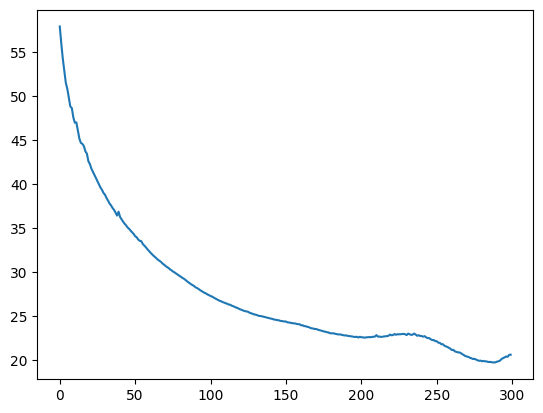

In [36]:
from matplotlib import pyplot as plt
plt.plot(training_loss, label='train_loss')

In [38]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    pred_prob, pred_label = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            pred_prob.append(pred)
            pred_label.append(pred.argmax(1))
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return pred_prob,pred_label

In [39]:
pred_prob, pred_label = test(test_dataloader,model,loss_fn)

Test Error: 
 Accuracy: 63.0%, Avg loss: 102.466583 



In [40]:
pred_label

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 1, 1, 0, 0,

In [41]:
pred_prob

[tensor([[  1.7631,  -1.5696,  -3.9310],
         [  1.7694,  -1.5822,  -3.9668],
         [  1.7652,  -1.5639,  -3.9675],
         [  1.7560,  -1.6016,  -3.9419],
         [  2.3852,  -8.2395,   1.1595],
         [  2.2667,  -8.1510,   1.2629],
         [  2.5017,  -8.3407,   1.0773],
         [  2.3849,  -8.1588,   1.0112],
         [  2.2528,  -8.0697,   1.0174],
         [  2.6101,  -8.4172,   0.9553],
         [  2.5711,  -8.5538,   1.5427],
         [  3.4842,  -7.4991,  -4.1867],
         [  2.5413,  -8.3032,   0.4310],
         [  2.5029,  -8.2677,   0.8133],
         [  2.3773,  -8.2131,   1.0746],
         [  2.2815,  -8.2311,   1.3641],
         [  2.4182,  -8.2106,   0.9095],
         [  2.3193,  -8.1692,   1.1631],
         [  2.3690,  -8.1802,   1.0567],
         [  2.3819,  -8.2126,   1.0365],
         [  2.4499,  -8.2981,   1.1276],
         [  2.5312,  -8.3538,   1.0893],
         [  2.4502,  -8.2836,   1.0493],
         [  2.5750,  -8.4353,   1.0958],
         [  2.34

In [42]:
pred_label_list = torch.cat(pred_label,dim=-1)
pred_label_list.shape

torch.Size([7362])

In [43]:
pred_prob_list = torch.cat(pred_prob,dim=0)
pred_prob_list.shape

torch.Size([7362, 3])

In [44]:
true_label = [y for X,y in testing_data]
len(true_label)

7362

In [45]:
pred_comp = pd.DataFrame({'pred': pred_label_list.tolist(),'true':true_label})
pred_comp

,pred,true
0,0,2
1,0,2
2,0,2
3,0,2
4,0,1
...,...,...
7357,0,0
7358,0,0
7359,0,0
7360,0,0


In [47]:
pd.crosstab(pred_comp['pred'],pred_comp['true'])

true,0,1,2
pred,,,
0,3521,1978,572
1,33,1085,62
2,57,22,32


In [48]:
pred_comp.to_csv('pred_results.300epochs.csv')

## Test for each epoch

In [14]:
def train(dataloader, model, optimizer, loss_fn):
    size = len(dataloader.dataset)
    patho_size = len([y for x,y in dataloader.dataset if y > 0])
    n_total_steps = len(dataloader)
    step_loss = []
    train_loss, correct, patho_correct = 0, 0, 0
    for i, (X,y) in enumerate(dataloader):
        # Forward pass
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)

        # Backprop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #record loss
        #step_loss.append(loss.item())
        #if (i+1) % 100 == 0:
        #    print(f'Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        nonzero_indices = torch.nonzero(y,as_tuple=True)
        #print(y)
        #print(nonzero_indices)
        #print((pred.argmax(1) == y).type(torch.float)[nonzero_indices])
        #print((pred.argmax(1) == y).type(torch.float))
        patho_correct += (pred.argmax(1) == y).type(torch.float)[nonzero_indices].sum().item()
        
    train_loss /= n_total_steps
    correct /= size
    patho_correct /= patho_size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Patho accuracy: {(100*patho_correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")            
    return train_loss

In [15]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    patho_size = len([y for x,y in dataloader.dataset if y > 0])
    model.eval()
    test_loss, correct, patho_correct = 0, 0, 0
    #pred_prob, pred_label = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            nonzero_indices = torch.nonzero(y,as_tuple=True)
            patho_correct += (pred.argmax(1) == y).type(torch.float)[nonzero_indices].sum().item()
            #pred_prob.append(pred)
            #pred_label.append(pred.argmax(1))
            
    test_loss /= num_batches
    correct /= size
    patho_correct /= patho_size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Patho accuracy: {(100*patho_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [16]:
def print_predictions(prefix, dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    pred_prob, pred_label = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            pred_prob.append(pred)
            pred_label.append(pred.argmax(1))
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    pred_label_list = torch.cat(pred_label,dim=-1)
    pred_prob_list = torch.cat(pred_prob,dim=0)
    pred_comp = pd.DataFrame({'pred': pred_label_list.tolist(),'true':[y for X,y in dataloader.dataset]})
    pred_comp.to_csv('pred_results.%s.csv' % prefix,index=False)
    pred_prob = pd.DataFrame(pred_prob_list.numpy(),columns=['Benign','LoF','GoF'])
    pred_prob.to_csv('pred_proba.%s.csv' % prefix,index=False)

In [17]:
# Initialize model, optimizer, loss
model = NeuralNetwork(INPUT_DIM, Z_DIM, H1_DIM, H2_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

In [66]:
epochs = 500
trainingEpoch_loss = []
testingEpoch_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    trainLoss = train(train_dataloader, model, optimizer, loss_fn)
    testLoss = test(test_dataloader, model, loss_fn)
    trainingEpoch_loss.append(trainLoss)
    testingEpoch_loss.append(testLoss)
print("Done!")

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 74.9%, Patho accuracy: 90.9%, Avg loss: 45.938483 

Test Error: 
 Accuracy: 49.0%, Patho accuracy: 0.0%, Avg loss: 94.593339 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 54.6%, Patho accuracy: 26.8%, Avg loss: 57.414889 

Test Error: 
 Accuracy: 49.0%, Patho accuracy: 0.0%, Avg loss: 80.302278 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 55.3%, Patho accuracy: 26.0%, Avg loss: 54.396529 

Test Error: 
 Accuracy: 49.0%, Patho accuracy: 0.0%, Avg loss: 75.676187 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 56.6%, Patho accuracy: 26.1%, Avg loss: 52.549842 

Test Error: 
 Accuracy: 49.0%, Patho accuracy: 0.0%, Avg loss: 74.461877 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 57.3%, Patho accuracy: 26.4%, Avg loss: 51.983817 

Test Error: 
 Accuracy: 49.0%, Patho accuracy: 0.0%, Avg loss: 75.250164 

Epoch 6
-------------------------------


Train Error: 
 Accuracy: 75.9%, Patho accuracy: 59.3%, Avg loss: 35.308577 

Test Error: 
 Accuracy: 57.5%, Patho accuracy: 17.0%, Avg loss: 73.884730 

Epoch 45
-------------------------------
Train Error: 
 Accuracy: 76.3%, Patho accuracy: 60.0%, Avg loss: 35.088252 

Test Error: 
 Accuracy: 57.6%, Patho accuracy: 17.1%, Avg loss: 73.865167 

Epoch 46
-------------------------------
Train Error: 
 Accuracy: 76.7%, Patho accuracy: 60.9%, Avg loss: 34.795660 

Test Error: 
 Accuracy: 57.7%, Patho accuracy: 17.3%, Avg loss: 74.539892 

Epoch 47
-------------------------------
Train Error: 
 Accuracy: 76.8%, Patho accuracy: 61.3%, Avg loss: 34.620862 

Test Error: 
 Accuracy: 57.7%, Patho accuracy: 17.4%, Avg loss: 74.774844 

Epoch 48
-------------------------------
Train Error: 
 Accuracy: 77.0%, Patho accuracy: 61.6%, Avg loss: 34.287349 

Test Error: 
 Accuracy: 57.8%, Patho accuracy: 17.5%, Avg loss: 75.034354 

Epoch 49
-------------------------------
Train Error: 
 Accuracy: 77.1%

Train Error: 
 Accuracy: 81.3%, Patho accuracy: 68.6%, Avg loss: 28.587267 

Test Error: 
 Accuracy: 59.8%, Patho accuracy: 21.9%, Avg loss: 85.501179 

Epoch 88
-------------------------------
Train Error: 
 Accuracy: 81.4%, Patho accuracy: 68.8%, Avg loss: 28.469662 

Test Error: 
 Accuracy: 59.9%, Patho accuracy: 22.0%, Avg loss: 85.847980 

Epoch 89
-------------------------------
Train Error: 
 Accuracy: 81.6%, Patho accuracy: 69.1%, Avg loss: 28.371982 

Test Error: 
 Accuracy: 59.9%, Patho accuracy: 22.1%, Avg loss: 86.173006 

Epoch 90
-------------------------------
Train Error: 
 Accuracy: 81.7%, Patho accuracy: 69.6%, Avg loss: 28.251731 

Test Error: 
 Accuracy: 59.9%, Patho accuracy: 22.1%, Avg loss: 86.664289 

Epoch 91
-------------------------------
Train Error: 
 Accuracy: 81.8%, Patho accuracy: 69.9%, Avg loss: 28.076727 

Test Error: 
 Accuracy: 60.0%, Patho accuracy: 22.3%, Avg loss: 87.148821 

Epoch 92
-------------------------------
Train Error: 
 Accuracy: 81.9%

Train Error: 
 Accuracy: 83.0%, Patho accuracy: 72.1%, Avg loss: 26.611547 

Test Error: 
 Accuracy: 61.5%, Patho accuracy: 25.3%, Avg loss: 85.536887 

Epoch 131
-------------------------------
Train Error: 
 Accuracy: 83.0%, Patho accuracy: 72.0%, Avg loss: 26.559808 

Test Error: 
 Accuracy: 61.6%, Patho accuracy: 25.2%, Avg loss: 86.186792 

Epoch 132
-------------------------------
Train Error: 
 Accuracy: 83.1%, Patho accuracy: 72.2%, Avg loss: 26.560217 

Test Error: 
 Accuracy: 61.6%, Patho accuracy: 25.5%, Avg loss: 85.861690 

Epoch 133
-------------------------------
Train Error: 
 Accuracy: 83.0%, Patho accuracy: 71.9%, Avg loss: 26.461828 

Test Error: 
 Accuracy: 61.6%, Patho accuracy: 25.5%, Avg loss: 86.625903 

Epoch 134
-------------------------------
Train Error: 
 Accuracy: 83.0%, Patho accuracy: 72.0%, Avg loss: 26.380021 

Test Error: 
 Accuracy: 61.7%, Patho accuracy: 25.5%, Avg loss: 86.808547 

Epoch 135
-------------------------------
Train Error: 
 Accuracy: 

Train Error: 
 Accuracy: 85.4%, Patho accuracy: 77.0%, Avg loss: 21.877985 

Test Error: 
 Accuracy: 60.3%, Patho accuracy: 23.1%, Avg loss: 113.732512 

Epoch 173
-------------------------------
Train Error: 
 Accuracy: 85.5%, Patho accuracy: 77.5%, Avg loss: 21.833887 

Test Error: 
 Accuracy: 60.3%, Patho accuracy: 23.1%, Avg loss: 114.610797 

Epoch 174
-------------------------------
Train Error: 
 Accuracy: 85.6%, Patho accuracy: 77.5%, Avg loss: 21.773582 

Test Error: 
 Accuracy: 60.3%, Patho accuracy: 23.1%, Avg loss: 115.015094 

Epoch 175
-------------------------------
Train Error: 
 Accuracy: 85.7%, Patho accuracy: 77.6%, Avg loss: 21.750400 

Test Error: 
 Accuracy: 60.3%, Patho accuracy: 23.1%, Avg loss: 114.916438 

Epoch 176
-------------------------------
Train Error: 
 Accuracy: 85.7%, Patho accuracy: 77.7%, Avg loss: 21.700583 

Test Error: 
 Accuracy: 60.3%, Patho accuracy: 23.0%, Avg loss: 115.652379 

Epoch 177
-------------------------------
Train Error: 
 Accur

Train Error: 
 Accuracy: 85.1%, Patho accuracy: 74.6%, Avg loss: 23.908306 

Test Error: 
 Accuracy: 62.8%, Patho accuracy: 27.8%, Avg loss: 94.504907 

Epoch 215
-------------------------------
Train Error: 
 Accuracy: 85.2%, Patho accuracy: 74.5%, Avg loss: 23.891041 

Test Error: 
 Accuracy: 62.8%, Patho accuracy: 27.7%, Avg loss: 94.945078 

Epoch 216
-------------------------------
Train Error: 
 Accuracy: 85.1%, Patho accuracy: 74.5%, Avg loss: 23.902264 

Test Error: 
 Accuracy: 62.8%, Patho accuracy: 27.8%, Avg loss: 94.722143 

Epoch 217
-------------------------------
Train Error: 
 Accuracy: 85.1%, Patho accuracy: 74.5%, Avg loss: 23.843411 

Test Error: 
 Accuracy: 62.8%, Patho accuracy: 27.9%, Avg loss: 94.706354 

Epoch 218
-------------------------------
Train Error: 
 Accuracy: 85.1%, Patho accuracy: 74.5%, Avg loss: 23.836964 

Test Error: 
 Accuracy: 62.8%, Patho accuracy: 27.8%, Avg loss: 94.747412 

Epoch 219
-------------------------------
Train Error: 
 Accuracy: 

Train Error: 
 Accuracy: 84.6%, Patho accuracy: 74.8%, Avg loss: 23.070451 

Test Error: 
 Accuracy: 62.8%, Patho accuracy: 30.2%, Avg loss: 97.463889 

Epoch 258
-------------------------------
Train Error: 
 Accuracy: 84.6%, Patho accuracy: 75.1%, Avg loss: 22.863593 

Test Error: 
 Accuracy: 62.7%, Patho accuracy: 30.0%, Avg loss: 98.331339 

Epoch 259
-------------------------------
Train Error: 
 Accuracy: 84.8%, Patho accuracy: 75.5%, Avg loss: 22.762763 

Test Error: 
 Accuracy: 62.7%, Patho accuracy: 30.1%, Avg loss: 98.442532 

Epoch 260
-------------------------------
Train Error: 
 Accuracy: 85.0%, Patho accuracy: 75.7%, Avg loss: 22.579864 

Test Error: 
 Accuracy: 62.7%, Patho accuracy: 30.1%, Avg loss: 99.922519 

Epoch 261
-------------------------------
Train Error: 
 Accuracy: 85.1%, Patho accuracy: 75.8%, Avg loss: 22.486777 

Test Error: 
 Accuracy: 62.6%, Patho accuracy: 30.1%, Avg loss: 100.445059 

Epoch 262
-------------------------------
Train Error: 
 Accuracy:

Train Error: 
 Accuracy: 86.1%, Patho accuracy: 77.5%, Avg loss: 21.043273 

Test Error: 
 Accuracy: 63.1%, Patho accuracy: 30.1%, Avg loss: 100.819385 

Epoch 300
-------------------------------
Train Error: 
 Accuracy: 86.2%, Patho accuracy: 77.4%, Avg loss: 20.948176 

Test Error: 
 Accuracy: 63.4%, Patho accuracy: 30.4%, Avg loss: 101.074533 

Epoch 301
-------------------------------
Train Error: 
 Accuracy: 86.2%, Patho accuracy: 77.7%, Avg loss: 21.005337 

Test Error: 
 Accuracy: 63.3%, Patho accuracy: 30.3%, Avg loss: 100.236534 

Epoch 302
-------------------------------
Train Error: 
 Accuracy: 86.1%, Patho accuracy: 77.6%, Avg loss: 20.966245 

Test Error: 
 Accuracy: 63.3%, Patho accuracy: 30.3%, Avg loss: 100.343699 

Epoch 303
-------------------------------
Train Error: 
 Accuracy: 85.9%, Patho accuracy: 76.9%, Avg loss: 21.029896 

Test Error: 
 Accuracy: 63.3%, Patho accuracy: 30.5%, Avg loss: 99.741501 

Epoch 304
-------------------------------
Train Error: 
 Accura

Train Error: 
 Accuracy: 86.4%, Patho accuracy: 78.6%, Avg loss: 21.128329 

Test Error: 
 Accuracy: 64.5%, Patho accuracy: 32.8%, Avg loss: 103.558106 

Epoch 342
-------------------------------
Train Error: 
 Accuracy: 86.2%, Patho accuracy: 78.1%, Avg loss: 21.204755 

Test Error: 
 Accuracy: 64.4%, Patho accuracy: 32.8%, Avg loss: 103.482115 

Epoch 343
-------------------------------
Train Error: 
 Accuracy: 86.0%, Patho accuracy: 77.7%, Avg loss: 21.201178 

Test Error: 
 Accuracy: 64.2%, Patho accuracy: 32.5%, Avg loss: 103.376891 

Epoch 344
-------------------------------
Train Error: 
 Accuracy: 86.0%, Patho accuracy: 77.5%, Avg loss: 21.176963 

Test Error: 
 Accuracy: 64.2%, Patho accuracy: 32.5%, Avg loss: 102.601907 

Epoch 345
-------------------------------
Train Error: 
 Accuracy: 86.0%, Patho accuracy: 77.5%, Avg loss: 21.140491 

Test Error: 
 Accuracy: 64.3%, Patho accuracy: 32.7%, Avg loss: 102.708574 

Epoch 346
-------------------------------
Train Error: 
 Accur

Train Error: 
 Accuracy: 86.4%, Patho accuracy: 79.0%, Avg loss: 20.773215 

Test Error: 
 Accuracy: 64.3%, Patho accuracy: 34.9%, Avg loss: 107.668959 

Epoch 384
-------------------------------
Train Error: 
 Accuracy: 86.6%, Patho accuracy: 79.3%, Avg loss: 20.720041 

Test Error: 
 Accuracy: 64.4%, Patho accuracy: 35.0%, Avg loss: 108.607748 

Epoch 385
-------------------------------
Train Error: 
 Accuracy: 86.5%, Patho accuracy: 79.3%, Avg loss: 20.678649 

Test Error: 
 Accuracy: 63.4%, Patho accuracy: 34.9%, Avg loss: 107.687498 

Epoch 386
-------------------------------
Train Error: 
 Accuracy: 86.3%, Patho accuracy: 78.6%, Avg loss: 20.588141 

Test Error: 
 Accuracy: 63.5%, Patho accuracy: 35.1%, Avg loss: 108.395728 

Epoch 387
-------------------------------
Train Error: 
 Accuracy: 86.7%, Patho accuracy: 79.4%, Avg loss: 20.605085 

Test Error: 
 Accuracy: 63.4%, Patho accuracy: 35.1%, Avg loss: 107.725738 

Epoch 388
-------------------------------
Train Error: 
 Accur

Train Error: 
 Accuracy: 86.7%, Patho accuracy: 79.4%, Avg loss: 20.465112 

Test Error: 
 Accuracy: 64.0%, Patho accuracy: 36.3%, Avg loss: 107.939010 

Epoch 426
-------------------------------
Train Error: 
 Accuracy: 86.6%, Patho accuracy: 79.3%, Avg loss: 20.488650 

Test Error: 
 Accuracy: 64.0%, Patho accuracy: 36.3%, Avg loss: 108.417815 

Epoch 427
-------------------------------
Train Error: 
 Accuracy: 86.5%, Patho accuracy: 79.1%, Avg loss: 20.544526 

Test Error: 
 Accuracy: 64.1%, Patho accuracy: 36.3%, Avg loss: 107.303007 

Epoch 428
-------------------------------
Train Error: 
 Accuracy: 86.4%, Patho accuracy: 79.1%, Avg loss: 20.523805 

Test Error: 
 Accuracy: 64.2%, Patho accuracy: 36.5%, Avg loss: 107.437859 

Epoch 429
-------------------------------
Train Error: 
 Accuracy: 86.5%, Patho accuracy: 79.2%, Avg loss: 20.558188 

Test Error: 
 Accuracy: 64.1%, Patho accuracy: 36.6%, Avg loss: 107.091263 

Epoch 430
-------------------------------
Train Error: 
 Accur

Train Error: 
 Accuracy: 87.4%, Patho accuracy: 80.6%, Avg loss: 19.708501 

Test Error: 
 Accuracy: 63.3%, Patho accuracy: 37.9%, Avg loss: 110.220774 

Epoch 468
-------------------------------
Train Error: 
 Accuracy: 87.4%, Patho accuracy: 80.6%, Avg loss: 19.706700 

Test Error: 
 Accuracy: 63.3%, Patho accuracy: 38.1%, Avg loss: 110.072567 

Epoch 469
-------------------------------
Train Error: 
 Accuracy: 87.4%, Patho accuracy: 80.6%, Avg loss: 19.785042 

Test Error: 
 Accuracy: 63.3%, Patho accuracy: 38.2%, Avg loss: 110.227401 

Epoch 470
-------------------------------
Train Error: 
 Accuracy: 87.3%, Patho accuracy: 80.8%, Avg loss: 19.840856 

Test Error: 
 Accuracy: 63.2%, Patho accuracy: 38.1%, Avg loss: 110.579324 

Epoch 471
-------------------------------
Train Error: 
 Accuracy: 87.1%, Patho accuracy: 80.3%, Avg loss: 19.862040 

Test Error: 
 Accuracy: 63.4%, Patho accuracy: 37.9%, Avg loss: 111.706273 

Epoch 472
-------------------------------
Train Error: 
 Accur

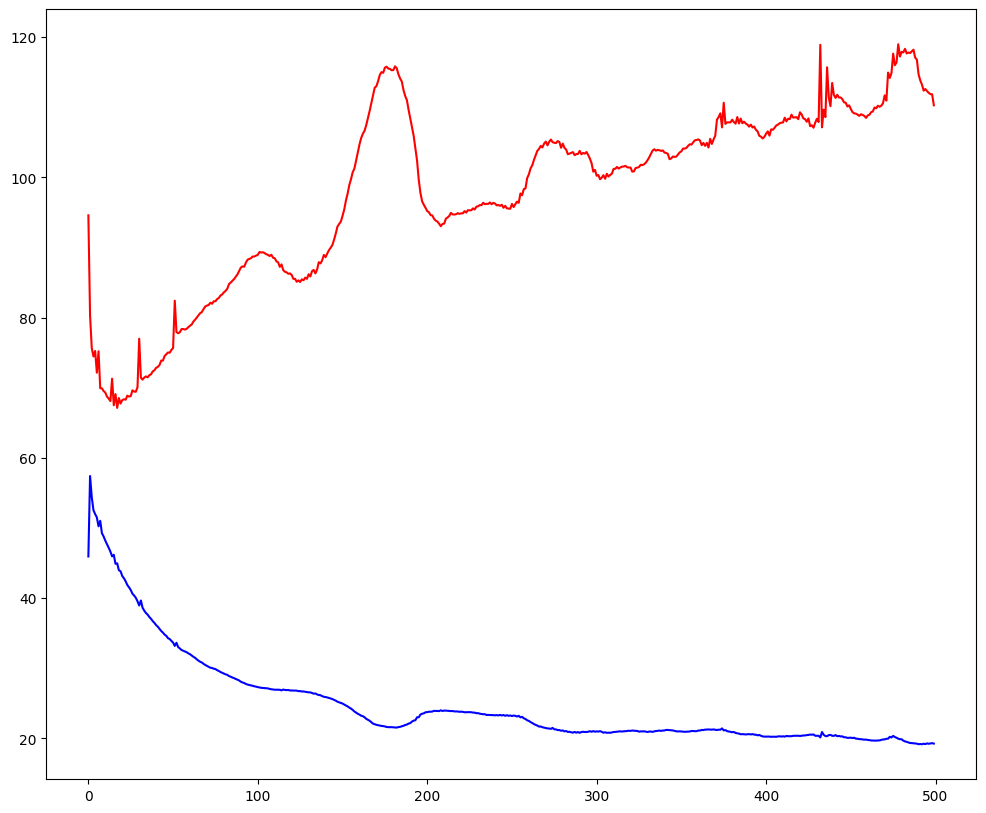

In [67]:
fig,ax = plt.subplots(figsize=(12,10))
ax.plot(trainingEpoch_loss, label='train_loss', color='blue')
ax.plot(testingEpoch_loss, label='test_loss', color='red')

In [72]:
print_predictions('128-16-500epochs',test_dataloader,model,loss_fn)
torch.save(model.state_dict(), "model.128-16-500epochs.pth")

Test Error: 
 Accuracy: 64.4%, Avg loss: 1.737754 

